In [57]:
# load relevant packages for analysis
import ast
import cityseer as cs
import cityseer.tools.graphs as cityseer_graphs
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import graph_tool.all as gt
import geopandas as gpd
import igraph
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import pyogrio
import random
from rtree import index
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.geometry import LineString, MultiLineString
from shapely.ops import nearest_points
import shapely.wkt
from shapely.wkt import loads
from shapely import wkt
import statsmodels.api as sm
import sys
from tqdm import tqdm
from xml import etree

# Final Analysis

In this notebook, we conduct the final analysis for this this research.

There are _ sections to this analysis. These sections are outlined below.

1. First we will read our graph data which contains all intersections and street segments in the UK nodes and conduct an EDA
2. We will then Cluster our data using the following parameters to characterise our urban spaces. These parameters are a maximum edge length of 300m and a minimum node count of 600m. This will help us define the urban spaces within the UK that we will deal with.
3. After we determine the urban spaces in the UK. We will calculate only the topological metrics mentioned by Geoff Boeing and add these attributes to our graph.

**Metrics Calculable on the Raw Graph:**
    - Betweeness Centrality of Nodes and Edges
    - Edge Length
    - Node Angle
    - PageRank (pagerank_max)
    - Self-loop Proportion (self_loop_proportion)
    - Average Node Degree (k_avg)
    - Orientation Entropy (orientation_entropy)
    - Orientation Order (orientation_order)

**Metrics Calculable After Determining Cities:**
    - Node Count
    - Diameter
    - Clustering Coefficients (cc_avg_dir, cc_avg_undir, cc_wt_avg_dir, cc_wt_avg_undir)
    - Proportion of 3-way, 4-way intersections, and dead-ends (prop_3way, prop_4way, prop_deadend)
    - Score: Simplified Fractal Dimension (Diameter / Node Count)
    - Intersection Count (intersect_count, intersect_count_clean, intersect_count_clean_topo)
4. 

## A. Read in Data and Assess

In [3]:
G = nx.read_graphml('Data/road_network.graphml')

In [4]:
list(G.nodes(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 {'pos': '(187422.39, 887423.74)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (187422.39 887423.74)'})

In [5]:
list(G.edges(data=True))[0]

('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D',
 'D3B5B123-54B7-467E-8C60-BE2383A3624B',
 {'length': 179.0,
  'road_classification': 'Unknown',
  'road_function': 'Restricted Local Access Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'})

## B. Supervised Clustering to Define Cities (534)
In this section we cluster our data using 2 parameters, maximum edge length of 300m and a minimum node count of 600. This allows us to determine the Urban Areas in the UK.

In [68]:
# create a copy of our graph, G_urbclus
G_urbclus = nx.Graph()

In [69]:
# Function to find clusters based on the criteria
def find_clusters(graph, max_edge_length, min_node_count):
    clusters = []
    visited = set()

    def dfs(node, cluster):
        stack = [node]
        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                cluster.append(current)
                for neighbor in graph.neighbors(current):
                    edge_data = graph.get_edge_data(current, neighbor)
                    if edge_data['length'] <= max_edge_length:
                        stack.append(neighbor)
    
    for node in graph.nodes():
        if node not in visited:
            cluster = []
            dfs(node, cluster)
            if len(cluster) >= min_node_count:
                clusters.append(cluster)
    
    return clusters

# Find clusters with maximum edge length of 300 and minimum node count of 600
max_edge_length = 300
min_node_count = 600
clusters = find_clusters(G, max_edge_length, min_node_count)

# Print the number of clusters identified
print(f"Number of clusters identified: {len(clusters)}")

Number of clusters identified: 534


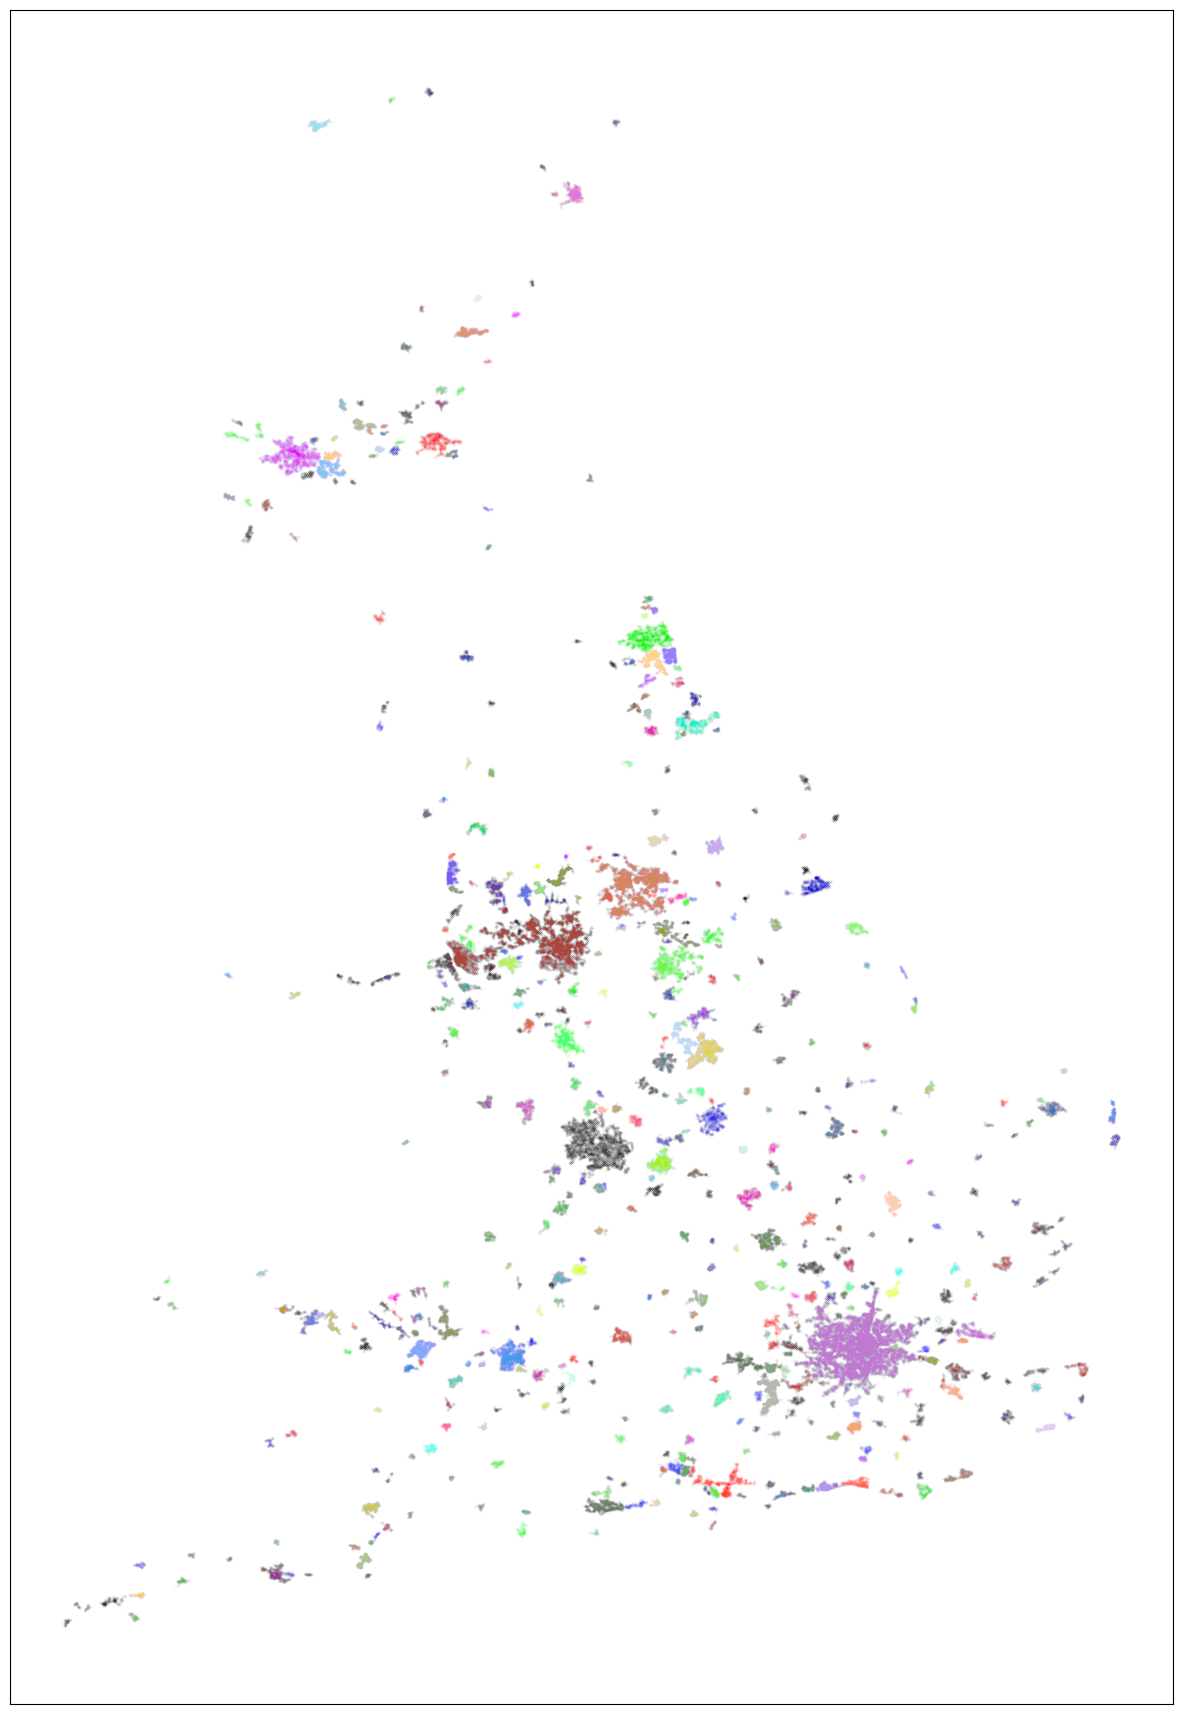

In [71]:
# Parse node positions
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G.nodes(data=True)}

from shapely.geometry import LineString
from shapely.wkt import loads as wkt_loads  # Import WKT loader

def parse_linestring(geometry):
    if isinstance(geometry, LineString):
        return list(geometry.coords)
    elif isinstance(geometry, str):
        # Convert WKT string to LineString object
        geom = wkt_loads(geometry)
        return list(geom.coords)
    else:
        raise TypeError("Unsupported geometry type: {}".format(type(geometry)))

# Example use of the fixed code
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import LineString

# Assuming `clusters` and `G` are defined elsewhere in your code

# Assign a color to each cluster
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(clusters))]

# Prepare node positions and edges for plotting
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G.nodes(data=True)}

# Plotting
fig, ax = plt.subplots(figsize=(15, 22))

for cluster, color in zip(clusters, colors):
    cluster_subgraph = G.subgraph(cluster)
    cluster_pos = {node: pos[node] for node in cluster}
    
    # Plot nodes
    nx.draw_networkx_nodes(cluster_subgraph, cluster_pos, node_size=0.00001, node_color=color, ax=ax)
    
    # Get edges & geometry converted to coordinate lists
    lines = [parse_linestring(data['geometry']) for u, v, data in cluster_subgraph.edges(data=True) if 'geometry' in data]
    
    # LineCollection from the list of lines
    lc = LineCollection(lines, colors=color, linewidths=0.00001)
    
    # Add LineCollection to the plot
    ax.add_collection(lc)

# Adjust the view to make sure everything fits
ax.autoscale()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import networkx as nx
import random
from shapely.geometry import LineString
from shapely.wkt import loads as wkt_loads

def parse_linestring(geometry):
    if isinstance(geometry, LineString):
        return list(geometry.coords)
    elif isinstance(geometry, str):
        geom = wkt_loads(geometry)
        return list(geom.coords)
    else:
        raise TypeError("Unsupported geometry type: {}".format(type(geometry)))

# Create a set of edges that are in any cluster
cluster_edges = set()
for cluster in clusters:
    cluster_edges.update(set(G.edges(cluster)))

# Separate non-clustered edges
non_cluster_edges = [
    parse_linestring(data['geometry'])
    for u, v, data in G.edges(data=True)
    if (u, v) not in cluster_edges and 'geometry' in data
]

# Assign a color to each cluster
colors = ['#'+''.join(random.choices('0123456789ABCDEF', k=6)) for _ in clusters]

# Plotting
fig, ax = plt.subplots(figsize=(15, 22))

# Plot non-clustered edges in pale grey
pale_grey = '#d3d3d3'
if non_cluster_edges:
    lc_non_cluster = LineCollection(non_cluster_edges, colors=pale_grey, linewidths=0.1)
    ax.add_collection(lc_non_cluster)

for cluster, color in zip(clusters, colors):
    cluster_subgraph = G.subgraph(cluster)
    cluster_pos = {node: pos[node] for node in cluster}

    # Plot nodes
    nx.draw_networkx_nodes(cluster_subgraph, cluster_pos, node_size=0.1, node_color=color, ax=ax)

    # Get edges & geometry converted to coordinate lists
    lines = [
        parse_linestring(data['geometry'])

/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_95494/3141579424.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('plasma')  # Using the Plasma colormap


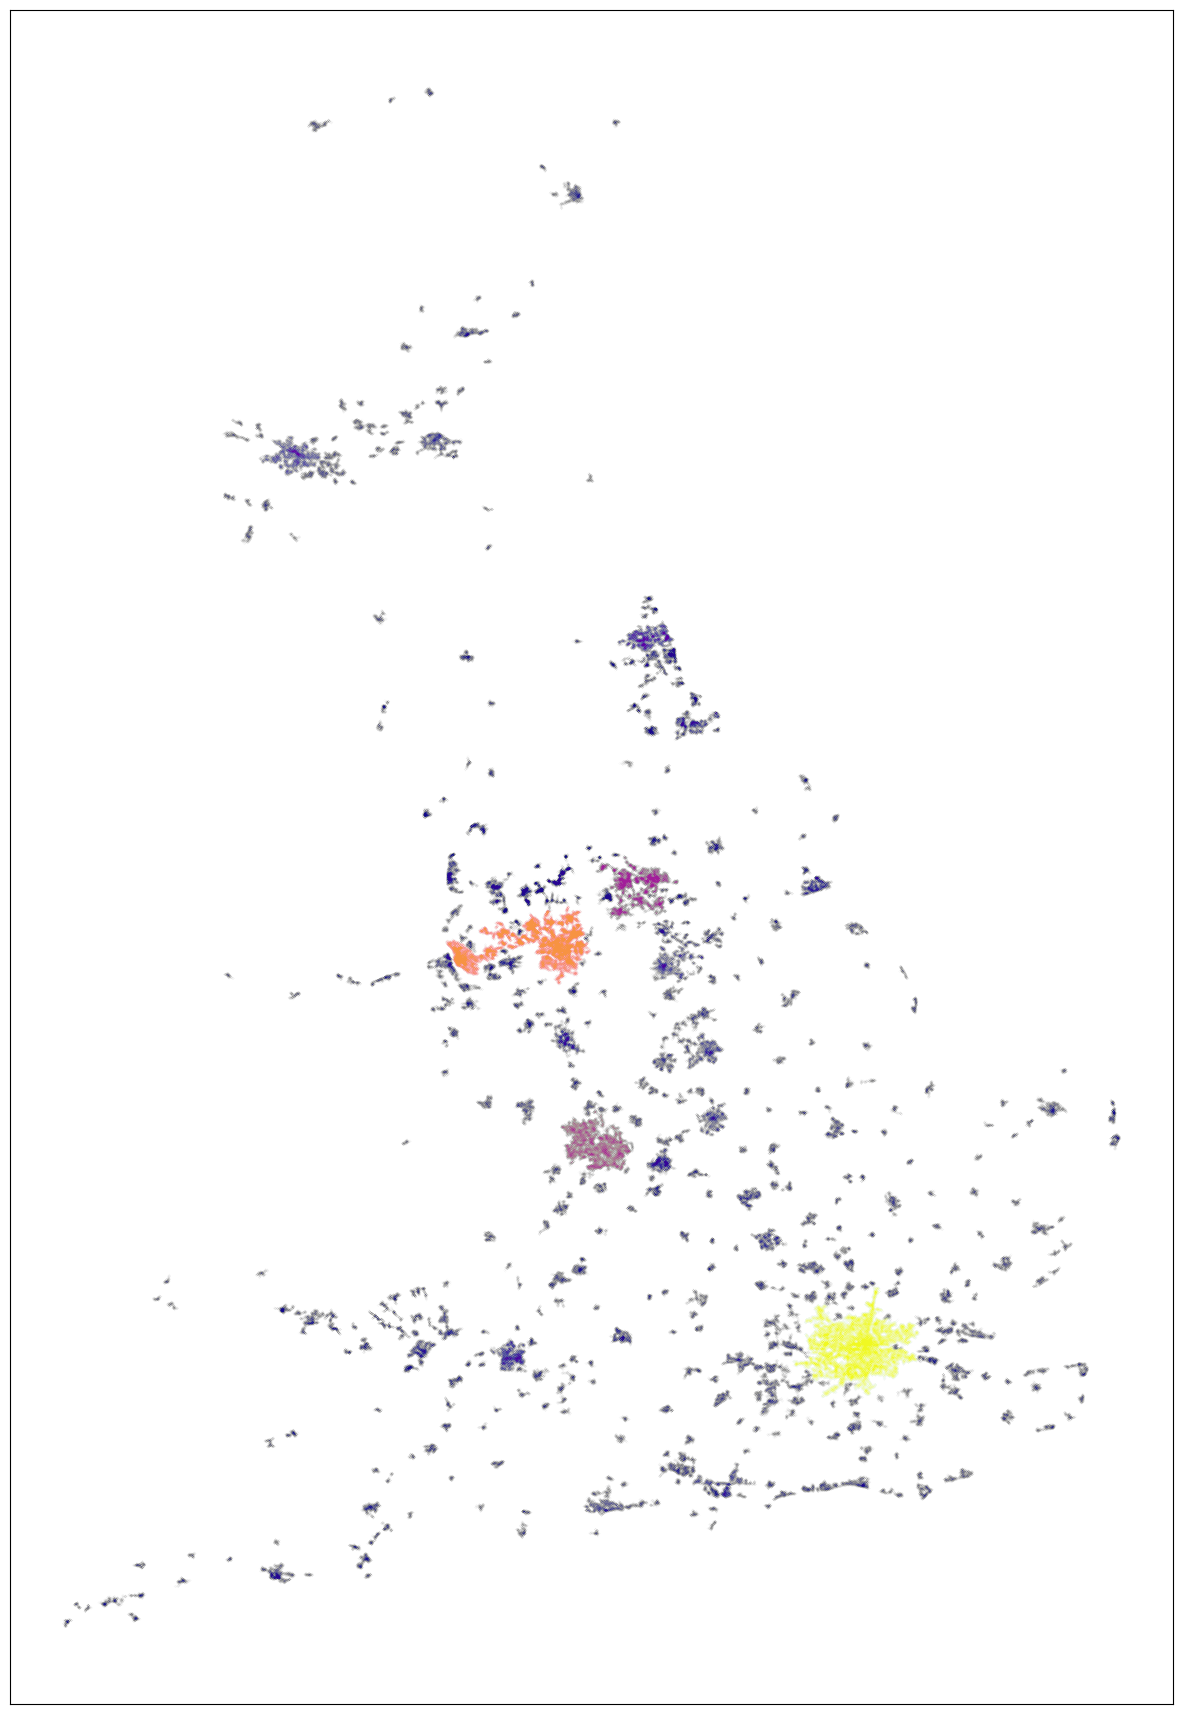

In [149]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import LineString, Polygon
from shapely.wkt import loads as wkt_loads
import matplotlib.cm as cm  # Importing colormap from matplotlib
import matplotlib.colors as mcolors  # Importing color normalization
import geopandas as gpd  # For loading the shapefile

# Load the UK shapefile to get the perimeter
uk_gdf = gpd.read_file('data/gadm41_GBR_shp/gadm41_GBR_0.shp')

# Extract the perimeter (boundary) from the shapefile
uk_perimeter = uk_gdf.geometry.boundary

# Calculate the size of each cluster
cluster_sizes = [len(cluster) for cluster in clusters]

# Normalize cluster sizes to map to the Plasma colormap
norm = mcolors.Normalize(vmin=min(cluster_sizes), vmax=max(cluster_sizes))
colormap = cm.get_cmap('plasma')  # Using the Plasma colormap

# Prepare node positions and edges for plotting
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G.nodes(data=True)}

# Define the parse_linestring function
def parse_linestring(geometry):
    if isinstance(geometry, LineString):
        return list(geometry.coords)
    elif isinstance(geometry, str):
        # Convert WKT string to LineString object
        geom = wkt_loads(geometry)
        return list(geom.coords)
    else:
        raise TypeError("Unsupported geometry type: {}".format(type(geometry)))

# Plotting
fig, ax = plt.subplots(figsize=(15, 22))

# Plot the perimeter of the UK
for boundary in uk_perimeter:
    if isinstance(boundary, LineString):
        x, y = boundary.xy
        ax.plot(x, y, color='black', linewidth=1)  # Adjust the linewidth as needed
    elif isinstance(boundary, Polygon):
        x, y = boundary.exterior.xy
        ax.plot(x, y, color='black', linewidth=1)

# Plot each cluster
for cluster, size in zip(clusters, cluster_sizes):
    cluster_subgraph = G.subgraph(cluster)
    cluster_pos = {node: pos[node] for node in cluster}
    
    # Determine color based on the size of the cluster
    color = colormap(norm(size))
    
    # Plot nodes
    nx.draw_networkx_nodes(cluster_subgraph, cluster_pos, node_size=0.00001, node_color=[color], ax=ax)
    
    # Get edges & geometry converted to coordinate lists
    lines = [parse_linestring(data['geometry']) for u, v, data in cluster_subgraph.edges(data=True) if 'geometry' in data]
    
    # LineCollection from the list of lines
    lc = LineCollection(lines, colors=[color], linewidths=0.00001)
    
    # Add LineCollection to the plot
    ax.add_collection(lc)

# Adjust the view to make sure everything fits
ax.autoscale()
plt.show()

In [74]:
# Create a new graph with only the nodes and edges from the identified clusters
G_urbclus = nx.Graph()

In [75]:
for cluster in clusters:
    for node in cluster:
        G_urbclus.add_node(node, **G.nodes[node])
    for u, v, data in G.subgraph(cluster).edges(data=True):
        G_urbclus.add_edge(u, v, **data)

In [76]:
# Save the new graph to a file
#nx.write_graphml(G_urbclus, 'G_urbclus.graphml')

#print("The new graph has been saved")

## C. Calculate Boeing's Metrics for 534 UK Cities 

In this section we calculate several metrics and add them to our network. These metrics are calculated in 2 parts. The very simlpe metrics, angle and degree are calculated in the first section of our code and added the the graph.

Then the morec omplex metrics are added to our graph later on in the process.

### C1. Read in Data and Check

In [77]:
G_urbclus = nx.read_graphml('Data/G_urbclus.graphml')

In [78]:
list(G_urbclus.nodes(data=True))[0]

('3C8D3199-B498-462C-A14B-886484E4D116',
 {'pos': '(337517.0, 401530.0)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (337517 401530)',
  'degree': 3,
  'angle': 158.57643500780435})

In [79]:
list(G_urbclus.edges(data=True))[0]

('3C8D3199-B498-462C-A14B-886484E4D116',
 '7865FC3D-B352-47C0-8F68-FC1E3B1BED36',
 {'length': 82.0,
  'road_classification': 'Classified Unnumbered',
  'road_function': 'Minor Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (337517 401530, 337541.4 401538.63, 337565.8 401547.25, 337580.4 401551.63, 337595 401556)'})

### C2. Calculate the Metrics unrelated to clusters
Node Angle and Node Degree

In [80]:
import math
import networkx as nx

# Function to calculate the angle between three points
def calculate_angle_between(pos, pos1, pos2):
    # Vector 1
    v1 = (pos1[0] - pos[0], pos1[1] - pos[1])
    # Vector 2hi
    v2 = (pos2[0] - pos[0], pos2[1] - pos[1])
    # Calculate the angle
    angle = math.atan2(v2[1], v2[0]) - math.atan2(v1[1], v1[0])
    # Ensure the angle is between 0 and 360 degrees
    angle = math.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

# Function to calculate node angles in a graph
def calculate_node_angle(G_urbclus):
    node_angles = {}
    for node in G_urbclus.nodes:
        pos = G_urbclus.nodes[node].get('pos', None)
        if pos:
            pos = tuple(map(float, pos.strip('()').split(',')))
            neighbors = list(G_urbclus.neighbors(node))
            if len(neighbors) < 2:
                node_angles[node] = 0.0
            else:
                angles = []
                for i in range(len(neighbors) - 1):
                    for j in range(i + 1, len(neighbors)):
                        pos1 = G_urbclus.nodes[neighbors[i]].get('pos', None)
                        pos2 = G_urbclus.nodes[neighbors[j]].get('pos', None)
                        if pos1 and pos2:
                            pos1 = tuple(map(float, pos1.strip('()').split(',')))
                            pos2 = tuple(map(float, pos2.strip('()').split(',')))
                            angle = calculate_angle_between(pos, pos1, pos2)
                            angles.append(angle)
                if angles:
                    node_angles[node] = sum(angles) / len(angles)
                else:
                    node_angles[node] = float('nan')  # No angles were calculated, assign NaN for debugging
        else:
            node_angles[node] = float('nan')  # Node has no position, assign NaN for debugging
    return node_angles

# Function to add node attributes to the graph
def add_node_attributes(G_urbclus):
    # Calculate node degree
    node_degree = dict(G_urbclus.degree())
    
    # Calculate node angles
    node_angles = calculate_node_angle(G_urbclus)

    # Add attributes to nodes
    nx.set_node_attributes(G_urbclus, node_degree, 'degree')
    nx.set_node_attributes(G_urbclus, node_angles, 'angle')

    return G_urbclus

# Add node attributes
G_urbclus = add_node_attributes(G_urbclus)

In [119]:
gdf = gpd.read_file('Data/clusterinfo_gdf.gpkg')

In [82]:
import time
import graph_tool.all as gt
from tqdm import tqdm

# Function to calculate local closeness centrality for a cluster
def calculate_local_closeness(vertices_within_polygon, G_gt):
    # Create subgraph using the vertices within the polygon
    vfilt = G_gt.new_vertex_property("bool")
    for v in vertices_within_polygon:
        vfilt[v] = True
    subgraph = gt.GraphView(G_gt, vfilt)
    subgraph.purge_vertices()
    
    # Calculate closeness centrality for vertices
    node_closeness = gt.closeness(subgraph)
    
    return node_closeness, subgraph

# Initialize properties to store the aggregated closeness centrality values
aggregated_node_closeness = G_gt.new_vertex_property("double")

# Ensure vertex positions are in the correct format
pos = G_gt.vertex_properties['pos']

# Iterate through each city (cluster) to calculate metrics
start_time = time.time()  # Start the total processing timer

# Use tqdm for progress tracking
for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Calculating local closeness centrality for clusters"):
    polygon = row.geometry
    
    # Timing the edge filtering
    filter_start_time = time.time()
    edges_within_polygon, vertices_within_polygon = get_edges_within_polygon(polygon, G_gt, pos)
    filter_end_time = time.time()
    
    print(f"Cluster {i}: Number of edges within polygon = {len(edges_within_polygon)}")
    
    if len(vertices_within_polygon) > 0:
        # Timing the closeness calculation
        closeness_start_time = time.time()
        node_closeness, subgraph = calculate_local_closeness(vertices_within_polygon, G_gt)
        closeness_end_time = time.time()
        
        # Verify closeness values
        closeness_values = [node_closeness[v] for v in subgraph.vertices()]
        print(f"Cluster {i}: Closeness values = {closeness_values[:10]} (showing first 10)")

        # Update the aggregated node closeness
        for v in subgraph.vertices():
            aggregated_node_closeness[v] = node_closeness[v]
        
        # Print the timing for each step
        print(f"Cluster {i}: Filter Time = {filter_end_time - filter_start_time:.2f}s, Closeness Time = {closeness_end_time - closeness_start_time:.2f}s")

# Set this new property to the graph
G_gt.vertex_properties["closeness"] = aggregated_node_closeness

# Total processing time
end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f}s")

Calculating local closeness centrality for clusters:   0%| | 1/534 [00:24<3:38:0

Cluster 0: Number of edges within polygon = 1237
Cluster 0: Closeness values = [0.0647463836775946, 0.06138092101323432, 0.058004640371229696, 0.055015833825344855, 0.05239482696927874, 0.050114897570038626, 0.052553322395406075, 0.05235200980642525, 0.05531271922724084, 0.05840788648925865] (showing first 10)
Cluster 0: Filter Time = 24.41s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:   0%| | 2/534 [00:46<3:22:4

Cluster 1: Number of edges within polygon = 5333
Cluster 1: Closeness values = [0.0194775558419244, 0.01910551264044944, 0.019106183503634258, 0.01874806188195569, 0.01874838487380481, 0.018403429557100094, 0.018403429557100094, 0.01986328873637907, 0.020263476398845542, 0.020676781015171522] (showing first 10)
Cluster 1: Filter Time = 21.49s, Closeness Time = 0.18s
Cluster 2: Number of edges within polygon = 19207


Calculating local closeness centrality for clusters:   1%| | 3/534 [01:09<3:22:2

Cluster 2: Closeness values = [0.010214439247929181, 0.010319843859636264, 0.010427404406482267, 0.010537216370481097, 0.01042734824057435, 0.010649336539526044, 0.01076383845137507, 0.01088081409032755, 0.010763748678596426, 0.01064913150477516] (showing first 10)
Cluster 2: Filter Time = 21.24s, Closeness Time = 1.62s
Cluster 3: Number of edges within polygon = 10891


Calculating local closeness centrality for clusters:   1%| | 4/534 [01:31<3:18:3

Cluster 3: Closeness values = [0.01670082204366072, 0.016683148241688664, 0.01667952899001718, 0.016686175379174658, 0.016719635946860788, 0.01658785372979129, 0.016317215009750318, 0.016412345303147214, 0.016683148241688664, 0.01670082204366072] (showing first 10)
Cluster 3: Filter Time = 21.20s, Closeness Time = 0.69s
Cluster 4: Number of edges within polygon = 199492


Calculating local closeness centrality for clusters:   1%| | 5/534 [06:45<18:47:

Cluster 4: Closeness values = [0.06645215444879687, 0.06299317021417677, 0.0594567530354237, 0.05633635770622072, 0.05361173814898419, 0.0512986662346779, 0.05383961462170587, 0.053587545126353796, 0.056726577894548276, 0.05997474747474747] (showing first 10)
Cluster 4: Filter Time = 23.44s, Closeness Time = 291.31s
Cluster 5: Number of edges within polygon = 7244


Calculating local closeness centrality for clusters:   1%| | 6/534 [07:07<13:27:

Cluster 5: Closeness values = [0.02136010406396785, 0.02106703146374829, 0.02120146601923685, 0.021446046144002407, 0.02120501656060437, 0.02115368908754761, 0.021394992565446597, 0.021651568579766536, 0.02119279192159634, 0.022127639744316637] (showing first 10)
Cluster 5: Filter Time = 21.33s, Closeness Time = 0.28s
Cluster 6: Number of edges within polygon = 85470


Calculating local closeness centrality for clusters:   1%| | 7/534 [08:37<13:19:

Cluster 6: Closeness values = [0.007412031942503826, 0.0074190478855604295, 0.007412821623399309, 0.007421932441546961, 0.00742622945869236, 0.007436641724922984, 0.0074502340100774615, 0.007463523789570009, 0.007479126361023345, 0.007423620514204153] (showing first 10)
Cluster 6: Filter Time = 21.84s, Closeness Time = 67.60s


Calculating local closeness centrality for clusters:   1%| | 8/534 [08:58<10:03:

Cluster 7: Number of edges within polygon = 4608
Cluster 7: Closeness values = [0.017689250523246245, 0.017959382476112257, 0.017733121472589337, 0.017518526971824096, 0.017323255353351115, 0.017142752959301344, 0.017320702407213815, 0.017025880606068838, 0.017436334892604974, 0.017138066009578363] (showing first 10)
Cluster 7: Filter Time = 21.31s, Closeness Time = 0.13s
Cluster 8: Number of edges within polygon = 11887


Calculating local closeness centrality for clusters:   2%| | 9/534 [09:20<7:55:3

Cluster 8: Closeness values = [0.009395500120916157, 0.009484604194062753, 0.009574905703074395, 0.009509536834327871, 0.009437472119227665, 0.009433468367958522, 0.0093552646301891, 0.009279088268092935, 0.009204572076793134, 0.00913199317044698] (showing first 10)
Cluster 8: Filter Time = 21.44s, Closeness Time = 0.94s


Calculating local closeness centrality for clusters:   2%| | 10/534 [09:42<6:26:

Cluster 9: Number of edges within polygon = 754
Cluster 9: Closeness values = [0.046742502585315406, 0.04597545263443412, 0.046642817831590536, 0.04681673801961055, 0.0462073195665508, 0.04747234280913038, 0.04728692983679732, 0.048314686809662936, 0.049717679841607396, 0.04795247188627202] (showing first 10)
Cluster 9: Filter Time = 21.44s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   2%| | 11/534 [10:04<5:25:

Cluster 10: Number of edges within polygon = 1023
Cluster 10: Closeness values = [0.04127672150527042, 0.03964236718860874, 0.03977030041288975, 0.03827183047131896, 0.03687568756875688, 0.03556574144809439, 0.035571780286951356, 0.03435130149620824, 0.03435130149620824, 0.036862710596929575] (showing first 10)
Cluster 10: Filter Time = 21.61s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:   2%| | 12/534 [10:25<4:42:

Cluster 11: Number of edges within polygon = 4521
Cluster 11: Closeness values = [0.024844511002280054, 0.024577091188148544, 0.024368457965567893, 0.02419031730497665, 0.02362684594757573, 0.023089171974522295, 0.022568508260208835, 0.023081936801995464, 0.022575148335213062, 0.022080468108321993] (showing first 10)
Cluster 11: Filter Time = 21.30s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:   2%| | 13/534 [10:46<4:12:

Cluster 12: Number of edges within polygon = 3491
Cluster 12: Closeness values = [0.03333948382037503, 0.03448892918495896, 0.03519086571233811, 0.0353608865295938, 0.034153602608479924, 0.03531251145122085, 0.03471838597333974, 0.03456604134533759, 0.034303139609387974, 0.034163288940359006] (showing first 10)
Cluster 12: Filter Time = 21.31s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:   3%| | 14/534 [11:08<3:52:

Cluster 13: Number of edges within polygon = 3851
Cluster 13: Closeness values = [0.024651418115279048, 0.025274279968182024, 0.025652352735083095, 0.025029912529076465, 0.02616755627034629, 0.026840503020353516, 0.02738745771532657, 0.028079770559594475, 0.027344986887721547, 0.026892366656020444] (showing first 10)
Cluster 13: Filter Time = 21.27s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:   3%| | 15/534 [11:29<3:37:

Cluster 14: Number of edges within polygon = 2528
Cluster 14: Closeness values = [0.02011822756363281, 0.020531075812418358, 0.02095866288006026, 0.02052861942791055, 0.02140354889343964, 0.021408444846480967, 0.02141267497244119, 0.021863551898062116, 0.02233818647340899, 0.022840218307671828] (showing first 10)
Cluster 14: Filter Time = 21.34s, Closeness Time = 0.07s
Cluster 15: Number of edges within polygon = 12938


Calculating local closeness centrality for clusters:   3%| | 16/534 [11:51<3:29:

Cluster 15: Closeness values = [0.012507834299710615, 0.012666246720910322, 0.012828692274201388, 0.012995326960080633, 0.013166282335495738, 0.0130113502226865, 0.012860472876577182, 0.012697469100875464, 0.0125384865644759, 0.012383349476586073] (showing first 10)
Cluster 15: Filter Time = 21.12s, Closeness Time = 0.86s
Cluster 16: Number of edges within polygon = 27369


Calculating local closeness centrality for clusters:   3%| | 17/534 [12:17<3:33:

Cluster 16: Closeness values = [0.005488209025759342, 0.0055184043182526935, 0.005518349773231705, 0.005548611095582355, 0.005548369849583823, 0.005578891146670477, 0.005547941172744137, 0.00561002630170848, 0.005579206139824919, 0.005610213744320262] (showing first 10)
Cluster 16: Filter Time = 21.63s, Closeness Time = 4.47s


Calculating local closeness centrality for clusters:   3%| | 18/534 [12:39<3:24:

Cluster 17: Number of edges within polygon = 1469
Cluster 17: Closeness values = [0.0457951404044813, 0.043791304347826084, 0.04710239814433761, 0.045204840041650214, 0.043457250353802074, 0.04164874789109795, 0.04198766049691513, 0.04139268805891636, 0.04026738309985287, 0.038858024691358024] (showing first 10)
Cluster 17: Filter Time = 21.30s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   4%| | 19/534 [13:00<3:17:

Cluster 18: Number of edges within polygon = 3765
Cluster 18: Closeness values = [0.75, 0.75, 0.5, 0.5, 0.02224607540587683, 0.022752066966276716, 0.02226818523691845, 0.02243375075264016, 0.02272182213116439, 0.023168882709278034] (showing first 10)
Cluster 18: Filter Time = 21.23s, Closeness Time = 0.11s
Cluster 19: Number of edges within polygon = 17450


Calculating local closeness centrality for clusters:   4%| | 20/534 [13:23<3:16:

Cluster 19: Closeness values = [0.012606291880893248, 0.012767228047970694, 0.012867316799735538, 0.01270609482734915, 0.012548016486572904, 0.01239252572547839, 0.012513814206027143, 0.012636708739037496, 0.012730169987406696, 0.012860131258809693] (showing first 10)
Cluster 19: Filter Time = 21.20s, Closeness Time = 1.34s
Cluster 20: Number of edges within polygon = 9687


Calculating local closeness centrality for clusters:   4%| | 21/534 [13:44<3:12:

Cluster 20: Closeness values = [0.024353473997625583, 0.024276008891393506, 0.02471087259272951, 0.02416585116528395, 0.023705796210863578, 0.02315905798724669, 0.02263763148598505, 0.022178301646640218, 0.021697157599601537, 0.02210678770185202] (showing first 10)
Cluster 20: Filter Time = 21.28s, Closeness Time = 0.45s
Cluster 21: Number of edges within polygon = 27127


Calculating local closeness centrality for clusters:   4%| | 22/534 [14:09<3:19:

Cluster 21: Closeness values = [0.01441127732357378, 0.01420655194177014, 0.014453942031314391, 0.014516171015813106, 0.014477863608101424, 0.01437702254421803, 0.014173370430919511, 0.01397533719800347, 0.013782727567617665, 0.013782727567617665] (showing first 10)
Cluster 21: Filter Time = 21.54s, Closeness Time = 3.66s


Calculating local closeness centrality for clusters:   4%| | 23/534 [14:31<3:13:

Cluster 22: Number of edges within polygon = 1607
Cluster 22: Closeness values = [0.03448909902810612, 0.03432141363446257, 0.03437442731104537, 0.03536890876276163, 0.036447923606484564, 0.036076384118697624, 0.03575708061002179, 0.03485439728172865, 0.033683076370539494, 0.03258630531357804] (showing first 10)
Cluster 22: Filter Time = 21.30s, Closeness Time = 0.06s
Cluster 23: Number of edges within polygon = 16870


Calculating local closeness centrality for clusters:   4%| | 24/534 [14:53<3:12:

Cluster 23: Closeness values = [0.01945674222200114, 0.019405340223944877, 0.019194436189847845, 0.01921782982237053, 0.01905469445639789, 0.01894045881617088, 0.018588459868015467, 0.01824925835252523, 0.01888518275615569, 0.0188690875809216] (showing first 10)
Cluster 23: Filter Time = 21.22s, Closeness Time = 1.33s
Cluster 24: Number of edges within polygon = 8166


Calculating local closeness centrality for clusters:   5%| | 25/534 [15:15<3:10:

Cluster 24: Closeness values = [0.02482816915533365, 0.025014975786138555, 0.025120492842906326, 0.025359985951767736, 0.02473373414447041, 0.02413682641819524, 0.024137330687001638, 0.023568531318742966, 0.023568691584018715, 0.02302607540275702] (showing first 10)
Cluster 24: Filter Time = 21.38s, Closeness Time = 0.35s


Calculating local closeness centrality for clusters:   5%| | 26/534 [15:36<3:06:

Cluster 25: Number of edges within polygon = 1386
Cluster 25: Closeness values = [0.039528659093876484, 0.04101608806096529, 0.03940646252969315, 0.03791365329826868, 0.042758279782501234, 0.0412901905963381, 0.04304859407770787, 0.041585110401428524, 0.040204508482454104, 0.0389940752189593] (showing first 10)
Cluster 25: Filter Time = 21.05s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   5%| | 27/534 [15:58<3:05:

Cluster 26: Number of edges within polygon = 721
Cluster 26: Closeness values = [0.05194593714378766, 0.054787462430227564, 0.0575189325640101, 0.06016597510373444, 0.06240219092331768, 0.05993424142790042, 0.0579578488372093, 0.05818513451892385, 0.054990518876055855, 0.05957605752171071] (showing first 10)
Cluster 26: Filter Time = 21.66s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:   5%| | 28/534 [16:19<3:03:

Cluster 27: Number of edges within polygon = 993
Cluster 27: Closeness values = [0.044229995979091274, 0.04235860409145608, 0.044660982541615914, 0.046216060080878106, 0.045591130452802824, 0.04372236299498186, 0.04199675479622029, 0.040320733104238254, 0.03875968992248062, 0.03876651982378855] (showing first 10)
Cluster 27: Filter Time = 21.44s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   5%| | 29/534 [16:41<3:02:

Cluster 28: Number of edges within polygon = 1086
Cluster 28: Closeness values = [0.03262166821376475, 0.03159212765274344, 0.031615473589512916, 0.030655160596903326, 0.029746070133010883, 0.02888764935560579, 0.029746070133010883, 0.02888764935560579, 0.03261626172561238, 0.031587057010785825] (showing first 10)
Cluster 28: Filter Time = 21.21s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   6%| | 30/534 [17:03<3:02:

Cluster 29: Number of edges within polygon = 1075
Cluster 29: Closeness values = [0.03629777482072891, 0.03765481805283945, 0.03629777482072891, 0.03503389225829468, 0.03503514217417675, 0.03384922960256454, 0.03910792512943051, 0.039521873868072606, 0.03805611533095644, 0.03666231099495987] (showing first 10)
Cluster 29: Filter Time = 21.75s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:   6%| | 31/534 [17:24<3:00:

Cluster 30: Number of edges within polygon = 763
Cluster 30: Closeness values = [0.035921926910299, 0.035139389630833295, 0.03394819466248038, 0.03620004184975936, 0.03505394863482093, 0.0339781989590494, 0.03288504490804543, 0.03184537505752416, 0.03086392221577985, 0.03086392221577985] (showing first 10)
Cluster 30: Filter Time = 21.24s, Closeness Time = 0.05s
Cluster 31: Number of edges within polygon = 88072


Calculating local closeness centrality for clusters:   6%| | 32/534 [18:37<5:09:

Cluster 31: Closeness values = [0.043869129494989195, 0.04202748493975904, 0.04429563492063492, 0.04583012573774698, 0.04522205904694384, 0.04338110274471703, 0.04168028004667445, 0.04002868797346362, 0.038489720270677985, 0.038496357287580295] (showing first 10)
Cluster 31: Filter Time = 22.41s, Closeness Time = 50.44s


Calculating local closeness centrality for clusters:   6%| | 33/534 [18:58<4:30:

Cluster 32: Number of edges within polygon = 3863
Cluster 32: Closeness values = [0.02046540810865674, 0.020892598104783253, 0.021337728721596193, 0.020893647753320563, 0.02047397214752091, 0.020837639277728717, 0.021278773032816767, 0.02083607327383748, 0.022474718474934645, 0.021981434376135575] (showing first 10)
Cluster 32: Filter Time = 21.54s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:   6%| | 34/534 [19:20<4:02:

Cluster 33: Number of edges within polygon = 4659
Cluster 33: Closeness values = [0.02179662466412927, 0.02228218342732252, 0.021799386512784506, 0.021337067793894982, 0.02126038174974641, 0.020817892598026612, 0.02164624716250151, 0.02212221061373195, 0.021643523978760095, 0.022619575876104546] (showing first 10)
Cluster 33: Filter Time = 21.26s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:   7%| | 35/534 [19:41<3:42:

Cluster 34: Number of edges within polygon = 2504
Cluster 34: Closeness values = [0.033245289144003896, 0.03431992322573766, 0.03546523525430132, 0.035769853618264374, 0.035871226595338174, 0.03597834592229444, 0.035435671594841144, 0.03480020388934369, 0.033918463206070094, 0.03454779648541725] (showing first 10)
Cluster 34: Filter Time = 21.12s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:   7%| | 36/534 [20:02<3:27:

Cluster 35: Number of edges within polygon = 938
Cluster 35: Closeness values = [0.03277777777777778, 0.032803812549642576, 0.033648362392048235, 0.03371428571428572, 0.033366996566350234, 0.0333966765050742, 0.034329412742612524, 0.033748723186925435, 0.033780467855390156, 0.03460845518917333] (showing first 10)
Cluster 35: Filter Time = 21.07s, Closeness Time = 0.06s
Cluster 36: Number of edges within polygon = 20807


Calculating local closeness centrality for clusters:   7%| | 37/534 [20:26<3:24:

Cluster 36: Closeness values = [0.014322002922448064, 0.01453009077169946, 0.014744289095873614, 0.01466531344613026, 0.014765840315409317, 0.014874354573062677, 0.014990313156860325, 0.015111587285897853, 0.015247972116772592, 0.015393176407977159] (showing first 10)
Cluster 36: Filter Time = 21.43s, Closeness Time = 2.32s
Cluster 37: Number of edges within polygon = 12921


Calculating local closeness centrality for clusters:   7%| | 38/534 [20:48<3:18:

Cluster 37: Closeness values = [0.006760367433925892, 0.006805170285176465, 0.006850893534317611, 0.006804311901380704, 0.0067587590405969, 0.0067592110264821405, 0.006713844910322414, 0.006713398971106235, 0.00689739390282447, 0.0069448462615578676] (showing first 10)
Cluster 37: Filter Time = 21.30s, Closeness Time = 1.04s


Calculating local closeness centrality for clusters:   7%| | 39/534 [21:10<3:11:

Cluster 38: Number of edges within polygon = 1775
Cluster 38: Closeness values = [0.031067222177710123, 0.032062678298259394, 0.031222320637732504, 0.032052739258922484, 0.03105789062656441, 0.0330274057196397, 0.03197740345957982, 0.030989630162440808, 0.030058722068257136, 0.030058722068257136] (showing first 10)
Cluster 38: Filter Time = 21.36s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:   7%| | 40/534 [21:31<3:06:

Cluster 39: Number of edges within polygon = 1155
Cluster 39: Closeness values = [0.03226742311907679, 0.032235210768685796, 0.033118279569892474, 0.03205764611689351, 0.03415915915915916, 0.035213001723713375, 0.035208047553726564, 0.035237793501601715, 0.03419182948490231, 0.03319515834853259] (showing first 10)
Cluster 39: Filter Time = 21.15s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:   8%| | 41/534 [21:53<3:03:

Cluster 40: Number of edges within polygon = 1135
Cluster 40: Closeness values = [0.040556578678125635, 0.03900499862242689, 0.037556372456133705, 0.036200913242009136, 0.034937422880310244, 0.03620355825083111, 0.03494235041077536, 0.03376375591973016, 0.03754783465312772, 0.03619033707044517] (showing first 10)
Cluster 40: Filter Time = 21.43s, Closeness Time = 0.06s
Cluster 41: Number of edges within polygon = 11788


Calculating local closeness centrality for clusters:   8%| | 42/534 [22:14<3:01:

Cluster 41: Closeness values = [0.01864126526204931, 0.018300164536542, 0.018634392723206147, 0.018512376514635113, 0.018651507106556317, 0.018685408211885707, 0.018916019360955404, 0.018853653128425747, 0.019186887624478573, 0.019250178261982696] (showing first 10)
Cluster 41: Filter Time = 21.28s, Closeness Time = 0.65s


Calculating local closeness centrality for clusters:   8%| | 43/534 [22:36<2:58:

Cluster 42: Number of edges within polygon = 5397
Cluster 42: Closeness values = [0.02353798885590793, 0.024105252491853812, 0.024580981281473988, 0.024689739556021672, 0.025086442775714993, 0.025496246072619175, 0.02586004679981921, 0.025210412123307917, 0.02478980765961181, 0.02462369867565904] (showing first 10)
Cluster 42: Filter Time = 20.84s, Closeness Time = 0.20s


Calculating local closeness centrality for clusters:   8%| | 44/534 [22:57<2:57:

Cluster 43: Number of edges within polygon = 649
Cluster 43: Closeness values = [0.04951407506702413, 0.0520704845814978, 0.05488484398216939, 0.052496002842423166, 0.049898682877406286, 0.04753096348721248, 0.04753096348721248, 0.05528531337698784, 0.05794117647058823, 0.06077745783628137] (showing first 10)
Cluster 43: Filter Time = 21.22s, Closeness Time = 0.07s
Cluster 44: Number of edges within polygon = 39513


Calculating local closeness centrality for clusters:   8%| | 45/534 [23:25<3:12:

Cluster 44: Closeness values = [0.009369937466150363, 0.009458478189925809, 0.009544064213586789, 0.009635892210992241, 0.00955520458776339, 0.009559420203425971, 0.009643226997352395, 0.009725450573643093, 0.0098102982214502, 0.009719204756340855] (showing first 10)
Cluster 44: Filter Time = 21.84s, Closeness Time = 6.45s


Calculating local closeness centrality for clusters:   9%| | 46/534 [23:47<3:07:

Cluster 45: Number of edges within polygon = 2579
Cluster 45: Closeness values = [0.03190327152474312, 0.031820122804175933, 0.03188350202130485, 0.03196414572455515, 0.03158617867165575, 0.03163148804121901, 0.03098429994981719, 0.030842788838935275, 0.031420387629585475, 0.032241219825142484] (showing first 10)
Cluster 45: Filter Time = 21.38s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:   9%| | 47/534 [24:08<3:03:

Cluster 46: Number of edges within polygon = 2990
Cluster 46: Closeness values = [0.020089793565805637, 0.019694581573782195, 0.019314337377508168, 0.019708061780198197, 0.019347770514552824, 0.019027985289047235, 0.018741112298103248, 0.018396472099725687, 0.018765274678567635, 0.018741112298103248] (showing first 10)
Cluster 46: Filter Time = 21.48s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:   9%| | 48/534 [24:30<3:00:

Cluster 47: Number of edges within polygon = 1311
Cluster 47: Closeness values = [0.04429972360001515, 0.044387116354945175, 0.043205317577548, 0.04435010045108222, 0.04557139518579107, 0.04390079171513264, 0.04521739130434783, 0.04326923076923077, 0.041476124641072, 0.041476124641072] (showing first 10)
Cluster 47: Filter Time = 21.49s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:   9%| | 49/534 [24:51<2:57:

Cluster 48: Number of edges within polygon = 3726
Cluster 48: Closeness values = [0.031421691483610986, 0.030483037433970902, 0.029581582989433163, 0.029602948257342863, 0.028991947185142194, 0.028688083273510412, 0.028405910419646904, 0.027621540827523047, 0.02789216541615774, 0.027135994024479262] (showing first 10)
Cluster 48: Filter Time = 21.20s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:   9%| | 50/534 [25:13<2:56:

Cluster 49: Number of edges within polygon = 1534
Cluster 49: Closeness values = [0.040651440931356954, 0.04237260037797155, 0.04423676012461059, 0.04623901009443178, 0.04620891636836968, 0.0441694891822769, 0.0468217622275142, 0.04814647377938517, 0.05018653053210288, 0.0478795144612618] (showing first 10)
Cluster 49: Filter Time = 21.34s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  10%| | 51/534 [25:34<2:54:

Cluster 50: Number of edges within polygon = 3299
Cluster 50: Closeness values = [0.023425965418812957, 0.022889934359747056, 0.023825612533473487, 0.024200723649089508, 0.024556123984351492, 0.02489409549709743, 0.02536502184802302, 0.025945945945945948, 0.02540202077700299, 0.02529582654290371] (showing first 10)
Cluster 50: Filter Time = 21.32s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  10%| | 52/534 [25:55<2:53:

Cluster 51: Number of edges within polygon = 1625
Cluster 51: Closeness values = [0.029658576717400246, 0.03048368002705902, 0.02960438522654951, 0.028770375690828194, 0.028012510441556424, 0.02804356281602489, 0.027317849429773045, 0.0266140046509911, 0.02595719403092542, 0.025316011235955057] (showing first 10)
Cluster 51: Filter Time = 21.32s, Closeness Time = 0.07s
Cluster 52: Number of edges within polygon = 6705


Calculating local closeness centrality for clusters:  10%| | 53/534 [26:17<2:52:

Cluster 52: Closeness values = [0.023043530688532494, 0.022524575478740542, 0.022943471735867936, 0.022856026567689, 0.02234643404235415, 0.021858736059479553, 0.0213915515871091, 0.02094361334867664, 0.02094361334867664, 0.021391232318558842] (showing first 10)
Cluster 52: Filter Time = 21.12s, Closeness Time = 0.27s


Calculating local closeness centrality for clusters:  10%| | 54/534 [26:38<2:52:

Cluster 53: Number of edges within polygon = 861
Cluster 53: Closeness values = [0.04326335665889148, 0.04521708846064546, 0.043670815113802, 0.04191552327145548, 0.04056024159116943, 0.03898118494795837, 0.03930571673646501, 0.03819001862927738, 0.036984285239519535, 0.0361183234421365] (showing first 10)
Cluster 53: Filter Time = 21.46s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  10%| | 55/534 [27:00<2:51:

Cluster 54: Number of edges within polygon = 4087
Cluster 54: Closeness values = [0.028224800148127872, 0.028904021500766704, 0.028092273422914513, 0.02966786545377618, 0.02881328073635766, 0.030477150829733044, 0.030399195366420422, 0.0299478944221406, 0.029816981902299634, 0.029068417736211983] (showing first 10)
Cluster 54: Filter Time = 21.27s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  10%| | 56/534 [27:21<2:50:

Cluster 55: Number of edges within polygon = 3210
Cluster 55: Closeness values = [0.028328520322399894, 0.029154098651525906, 0.030027869152046784, 0.030732363083757087, 0.03031421158835399, 0.029864479558337403, 0.02958386784597034, 0.028734124642053032, 0.030009702642543233, 0.030100411032619272] (showing first 10)
Cluster 55: Filter Time = 21.19s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  11%| | 57/534 [27:42<2:50:

Cluster 56: Number of edges within polygon = 4233
Cluster 56: Closeness values = [0.027827927012570433, 0.028405633126762496, 0.02762127021170195, 0.029097997207856635, 0.028471524180176462, 0.02909084524969496, 0.02972303939154768, 0.03038972948188904, 0.029735307312696274, 0.02927277384706433] (showing first 10)
Cluster 56: Filter Time = 21.27s, Closeness Time = 0.13s
Cluster 57: Number of edges within polygon = 5798


Calculating local closeness centrality for clusters:  11%| | 58/534 [28:04<2:50:

Cluster 57: Closeness values = [0.017470185504467703, 0.0171702789642989, 0.017780625525609706, 0.017470060522814097, 0.018102029621503014, 0.01833629302026979, 0.018605147271702194, 0.018907660622202952, 0.01855771167152394, 0.018219665599749312] (showing first 10)
Cluster 57: Filter Time = 21.38s, Closeness Time = 0.22s


Calculating local closeness centrality for clusters:  11%| | 59/534 [28:25<2:49:

Cluster 58: Number of edges within polygon = 1101
Cluster 58: Closeness values = [0.05654671908073783, 0.05649546827794562, 0.05416208075073858, 0.051393393063266096, 0.048883776859936216, 0.048883776859936216, 0.05208623475015319, 0.05027692638597624, 0.04863459037711314, 0.04723653632413863] (showing first 10)
Cluster 58: Filter Time = 21.00s, Closeness Time = 0.06s


Calculating local closeness centrality for clusters:  11%| | 60/534 [28:47<2:49:

Cluster 59: Number of edges within polygon = 3338
Cluster 59: Closeness values = [0.24390243902439024, 0.3125, 0.24390243902439024, 0.37037037037037035, 0.41666666666666663, 0.2857142857142857, 0.3571428571428571, 0.43478260869565216, 0.3333333333333333, 0.2564102564102564] (showing first 10)
Cluster 59: Filter Time = 21.46s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  11%| | 61/534 [29:08<2:48:

Cluster 60: Number of edges within polygon = 819
Cluster 60: Closeness values = [0.0348428792207184, 0.03609898107714701, 0.0348428792207184, 0.0374414976599064, 0.03861725319215197, 0.03921775341310421, 0.03919296212400569, 0.03914553298958223, 0.03909000157620974, 0.03903053194837897] (showing first 10)
Cluster 60: Filter Time = 21.01s, Closeness Time = 0.06s
Cluster 61: Number of edges within polygon = 10298


Calculating local closeness centrality for clusters:  12%| | 62/534 [29:30<2:49:

Cluster 61: Closeness values = [0.015057209286747999, 0.015287367430140203, 0.01511449112010376, 0.015136265371938903, 0.015162542024488695, 0.015269631809170717, 0.015376722500742554, 0.015363530410509503, 0.015348430208844304, 0.015116443689389114] (showing first 10)
Cluster 61: Filter Time = 21.43s, Closeness Time = 0.58s
Cluster 62: Number of edges within polygon = 20564


Calculating local closeness centrality for clusters:  12%| | 63/534 [29:53<2:51:

Cluster 62: Closeness values = [0.00599071540273587, 0.005955042798542807, 0.006026702510534058, 0.006063114853487104, 0.0060999649376229, 0.006062993137628057, 0.006026457188648343, 0.006026457188648343, 0.006137245737741562, 0.0060998121705410704] (showing first 10)
Cluster 62: Filter Time = 21.38s, Closeness Time = 1.40s


Calculating local closeness centrality for clusters:  12%| | 64/534 [30:14<2:50:

Cluster 63: Number of edges within polygon = 778
Cluster 63: Closeness values = [0.027790174043571744, 0.028583350719799706, 0.02935504606813799, 0.030131081199964813, 0.029251003501579984, 0.030961851383113363, 0.03183973226736079, 0.032768848067355534, 0.03375049270792274, 0.034729263841005886] (showing first 10)
Cluster 63: Filter Time = 21.33s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  12%| | 65/534 [30:35<2:48:

Cluster 64: Number of edges within polygon = 2593
Cluster 64: Closeness values = [0.03943618178991553, 0.04105450556564585, 0.04269923504217555, 0.04449078224266282, 0.046023586332022984, 0.04433870654496019, 0.042688855646970836, 0.04111661413777578, 0.03949348694794748, 0.03973267895368872] (showing first 10)
Cluster 64: Filter Time = 20.94s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  12%| | 66/534 [30:56<2:47:

Cluster 65: Number of edges within polygon = 1033
Cluster 65: Closeness values = [0.17391304347826086, 0.20512820512820515, 0.24, 0.1951219512195122, 0.2823529411764706, 0.23529411764705882, 0.32432432432432434, 0.27586206896551724, 0.2285714285714286, 0.1875] (showing first 10)
Cluster 65: Filter Time = 21.22s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  13%|▏| 67/534 [31:18<2:46:

Cluster 66: Number of edges within polygon = 4941
Cluster 66: Closeness values = [0.02151604046393636, 0.02198904282048683, 0.02151604046393636, 0.022482818806588853, 0.022248129796949383, 0.022045845946495238, 0.021826615550801683, 0.021947829976199224, 0.021831586418020327, 0.021622925966920385] (showing first 10)
Cluster 66: Filter Time = 21.20s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  13%|▏| 68/534 [31:39<2:47:

Cluster 67: Number of edges within polygon = 683
Cluster 67: Closeness values = [0.04510511452776906, 0.047231805487103665, 0.04510511452776906, 0.04955187866253016, 0.05207389965585944, 0.054782774390243906, 0.05777733118971061, 0.06110520722635494, 0.06202804746494067, 0.05845872305815372] (showing first 10)
Cluster 67: Filter Time = 21.59s, Closeness Time = 0.06s
Cluster 68: Number of edges within polygon = 8136


Calculating local closeness centrality for clusters:  13%|▏| 69/534 [32:01<2:47:

Cluster 68: Closeness values = [0.013269794311667844, 0.013100324243600189, 0.012935010786742113, 0.013091680359354955, 0.013260925416370346, 0.013088264477388154, 0.01292029972628482, 0.012755609119284554, 0.012594975094731967, 0.012594975094731967] (showing first 10)
Cluster 68: Filter Time = 21.46s, Closeness Time = 0.32s


Calculating local closeness centrality for clusters:  13%|▏| 70/534 [32:23<2:47:

Cluster 69: Number of edges within polygon = 2868
Cluster 69: Closeness values = [0.03419362339058912, 0.03306354157884383, 0.0353994283135249, 0.03498884758364312, 0.034602432317171805, 0.03344942782002985, 0.033811357627313486, 0.03270599355053931, 0.03424139235716988, 0.0331100666985619] (showing first 10)
Cluster 69: Filter Time = 21.61s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  13%|▏| 71/534 [32:44<2:46:

Cluster 70: Number of edges within polygon = 992
Cluster 70: Closeness values = [0.029426669819926348, 0.028590185458723126, 0.027796393808839956, 0.029426669819926348, 0.030313576723627885, 0.0312511212371282, 0.03222226332729089, 0.03121751908533744, 0.03325062034739454, 0.03433594827926045] (showing first 10)
Cluster 70: Filter Time = 21.25s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  13%|▏| 72/534 [33:06<2:45:

Cluster 71: Number of edges within polygon = 717
Cluster 71: Closeness values = [0.05465587044534413, 0.057799702159344754, 0.054771564649850064, 0.05194913836372762, 0.04938762525846986, 0.04938762525846986, 0.05196652719665272, 0.04940334128878282, 0.04941120305537874, 0.04708826205641493] (showing first 10)
Cluster 71: Filter Time = 21.36s, Closeness Time = 0.07s
Cluster 72: Number of edges within polygon = 40487


Calculating local closeness centrality for clusters:  14%|▏| 73/534 [33:35<3:03:

Cluster 72: Closeness values = [0.007895774706646248, 0.007958612185064811, 0.008022343185653676, 0.00795969805326907, 0.007898192341958512, 0.007837754414620651, 0.007776916940864327, 0.007716905054782606, 0.007717051405049545, 0.007657956377431177] (showing first 10)
Cluster 72: Filter Time = 21.77s, Closeness Time = 7.58s
Cluster 73: Number of edges within polygon = 12405


Calculating local closeness centrality for clusters:  14%|▏| 74/534 [33:57<2:58:

Cluster 73: Closeness values = [0.014903717327227107, 0.0151161390147409, 0.015335448243449654, 0.015549251208803776, 0.015311245765124333, 0.015080370099919584, 0.015771920213965777, 0.015785425290544386, 0.015982510506431208, 0.016179309524124344] (showing first 10)
Cluster 73: Filter Time = 21.20s, Closeness Time = 0.79s


Calculating local closeness centrality for clusters:  14%|▏| 75/534 [34:18<2:53:

Cluster 74: Number of edges within polygon = 1913
Cluster 74: Closeness values = [0.04249198024339325, 0.04076100229570654, 0.041874702059864016, 0.04285640920295809, 0.04109622771594603, 0.044535169174938626, 0.04655768801606784, 0.04449480138629699, 0.04260261384521135, 0.04086279502497307] (showing first 10)
Cluster 74: Filter Time = 21.17s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  14%|▏| 76/534 [34:40<2:51:

Cluster 75: Number of edges within polygon = 1034
Cluster 75: Closeness values = [0.052650451204207256, 0.053722787974876514, 0.05245608812146472, 0.05118224597687794, 0.05048421293908659, 0.04927844277883432, 0.046966627572235846, 0.048194748358862144, 0.04691910315811897, 0.04593086908920286] (showing first 10)
Cluster 75: Filter Time = 21.71s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  14%|▏| 77/534 [35:01<2:48:

Cluster 76: Number of edges within polygon = 2504
Cluster 76: Closeness values = [0.03475828362888057, 0.033591249495043655, 0.034691912708600774, 0.033541741005631655, 0.03246148764301372, 0.03144498581921315, 0.030488492779783393, 0.02958766131570664, 0.028737771161207997, 0.03048677308364826] (showing first 10)
Cluster 76: Filter Time = 21.22s, Closeness Time = 0.11s
Cluster 77: Number of edges within polygon = 18526


Calculating local closeness centrality for clusters:  15%|▏| 78/534 [35:25<2:50:

Cluster 77: Closeness values = [0.014543670098587263, 0.01475829598598435, 0.014853456668039049, 0.01484079377726603, 0.014894706837327343, 0.014676124423424391, 0.015015695442292507, 0.014989573989725427, 0.015026347928901949, 0.015041087563852295] (showing first 10)
Cluster 77: Filter Time = 21.69s, Closeness Time = 1.54s


Calculating local closeness centrality for clusters:  15%|▏| 79/534 [35:46<2:47:

Cluster 78: Number of edges within polygon = 1040
Cluster 78: Closeness values = [0.04843131282363691, 0.0462410935000727, 0.044236297876286745, 0.04239434742034395, 0.04067189631650751, 0.04069271455383041, 0.03910316842234701, 0.0391159949157407, 0.037645016178675716, 0.03765095903386218] (showing first 10)
Cluster 78: Filter Time = 21.22s, Closeness Time = 0.07s
Cluster 79: Number of edges within polygon = 13700


Calculating local closeness centrality for clusters:  15%|▏| 80/534 [36:08<2:47:

Cluster 79: Closeness values = [0.020702147847839213, 0.02050008096820174, 0.02048855966492668, 0.02007780148073786, 0.019682987713510014, 0.019303078438863534, 0.01974800719979429, 0.019997604453633158, 0.020405271361768458, 0.020829679400134162] (showing first 10)
Cluster 79: Filter Time = 21.55s, Closeness Time = 0.84s
Cluster 80: Number of edges within polygon = 10324


Calculating local closeness centrality for clusters:  15%|▏| 81/534 [36:30<2:45:

Cluster 80: Closeness values = [0.03884093711467324, 0.040406199893105295, 0.04208416833667335, 0.043866774979691305, 0.042028018679119414, 0.045773795107774275, 0.04381592674162513, 0.041981341625944024, 0.042, 0.040311400234616615] (showing first 10)
Cluster 80: Filter Time = 21.07s, Closeness Time = 0.43s


Calculating local closeness centrality for clusters:  15%|▏| 82/534 [36:51<2:43:

Cluster 81: Number of edges within polygon = 4733
Cluster 81: Closeness values = [0.028401450038005028, 0.02767352926514887, 0.02767313512551184, 0.027010307845222455, 0.027010683329973795, 0.02640519678190911, 0.026402864500173255, 0.026722596616696466, 0.02705016741032584, 0.02774247897539872] (showing first 10)
Cluster 81: Filter Time = 20.94s, Closeness Time = 0.15s
Cluster 82: Number of edges within polygon = 8814


Calculating local closeness centrality for clusters:  16%|▏| 83/534 [37:12<2:42:

Cluster 82: Closeness values = [0.022486034810526346, 0.022528793823566637, 0.02278204407816695, 0.022432675845067605, 0.02265123064030541, 0.023069531022797678, 0.023419323990847916, 0.023854350526246976, 0.02332889003966998, 0.023033198988786384] (showing first 10)
Cluster 82: Filter Time = 21.04s, Closeness Time = 0.33s


Calculating local closeness centrality for clusters:  16%|▏| 84/534 [37:33<2:41:

Cluster 83: Number of edges within polygon = 1487
Cluster 83: Closeness values = [0.04541461106981145, 0.04474779424005327, 0.04371016001040718, 0.043468417477926194, 0.043935926773455376, 0.04327108821635544, 0.041480201228357154, 0.03982930298719772, 0.043019012867294024, 0.04124597207303974] (showing first 10)
Cluster 83: Filter Time = 21.16s, Closeness Time = 0.08s
Cluster 84: Number of edges within polygon = 10045


Calculating local closeness centrality for clusters:  16%|▏| 85/534 [37:55<2:41:

Cluster 84: Closeness values = [0.013303093692860401, 0.013482431090141545, 0.013303093692860401, 0.013666583810281952, 0.013855748373101951, 0.014050041242782512, 0.014246425273916103, 0.014446382750150916, 0.014651983760872608, 0.014653540836602984] (showing first 10)
Cluster 84: Filter Time = 21.26s, Closeness Time = 0.55s


Calculating local closeness centrality for clusters:  16%|▏| 86/534 [38:16<2:40:

Cluster 85: Number of edges within polygon = 1017
Cluster 85: Closeness values = [0.04060532004887678, 0.03902967881826806, 0.03756521739130435, 0.03756521739130435, 0.03902262770425907, 0.04230524408754835, 0.04414018596096863, 0.04227626363947742, 0.04613166746756367, 0.047038327526132406] (showing first 10)
Cluster 85: Filter Time = 21.13s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  16%|▏| 87/534 [38:38<2:39:

Cluster 86: Number of edges within polygon = 4762
Cluster 86: Closeness values = [0.013064850754172715, 0.013237758860681584, 0.013415047627577295, 0.013264260503244906, 0.013090663928260415, 0.013118589673411552, 0.012977368508995044, 0.012853241965191435, 0.012690171017755346, 0.012744311551925321] (showing first 10)
Cluster 86: Filter Time = 21.22s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  16%|▏| 88/534 [38:59<2:39:

Cluster 87: Number of edges within polygon = 2097
Cluster 87: Closeness values = [0.03248083648309725, 0.03206402343341354, 0.03107048726093127, 0.030134696686658143, 0.030134696686658143, 0.033052355362245905, 0.03280530878732741, 0.033575549550865405, 0.03434879246904126, 0.03320873286743594] (showing first 10)
Cluster 87: Filter Time = 21.23s, Closeness Time = 0.10s
Cluster 88: Number of edges within polygon = 8199


Calculating local closeness centrality for clusters:  17%|▏| 89/534 [39:21<2:39:

Cluster 88: Closeness values = [0.018660207927292654, 0.01901498229939312, 0.019380490109748502, 0.01906278386885523, 0.018706240250418487, 0.01875795764583604, 0.018415534456105262, 0.01808443746351924, 0.018065701193952906, 0.018326335189914552] (showing first 10)
Cluster 88: Filter Time = 21.41s, Closeness Time = 0.36s
Cluster 89: Number of edges within polygon = 14644


Calculating local closeness centrality for clusters:  17%|▏| 90/534 [39:43<2:41:

Cluster 89: Closeness values = [0.017551450101540224, 0.017477262297865653, 0.017486440075876603, 0.01757168213512728, 0.017542821726391704, 0.017675502525578667, 0.017965047927470484, 0.018271874458988785, 0.018244999252854534, 0.017918625212400598] (showing first 10)
Cluster 89: Filter Time = 21.32s, Closeness Time = 1.15s


Calculating local closeness centrality for clusters:  17%|▏| 91/534 [40:05<2:39:

Cluster 90: Number of edges within polygon = 928
Cluster 90: Closeness values = [0.03734382865772734, 0.03746040490290594, 0.037313091590836345, 0.035972491624052194, 0.03724326791419443, 0.03590759075907591, 0.037258572667914706, 0.0372755927093326, 0.03727899858376353, 0.0359503039915411] (showing first 10)
Cluster 90: Filter Time = 20.96s, Closeness Time = 0.07s
Cluster 91: Number of edges within polygon = 242013


Calculating local closeness centrality for clusters:  17%|▏| 92/534 [47:58<19:16

Cluster 91: Closeness values = [0.0035201210616318582, 0.0035325560205531213, 0.0035450749470926483, 0.0035325518524167016, 0.0035576846648936998, 0.003545073681109106, 0.0035325510584870707, 0.003520116922788308, 0.0035201172512675984, 0.0035077698175465] (showing first 10)
Cluster 91: Filter Time = 23.87s, Closeness Time = 448.98s
Cluster 92: Number of edges within polygon = 5150


Calculating local closeness centrality for clusters:  17%|▏| 93/534 [48:19<14:15

Cluster 92: Closeness values = [0.023224333525269973, 0.023775298096114665, 0.023377125193199382, 0.022844480658207218, 0.02233491688768422, 0.022334374438361886, 0.02284368618995335, 0.021847070506454815, 0.022769590365264242, 0.022262786092295178] (showing first 10)
Cluster 92: Filter Time = 21.48s, Closeness Time = 0.31s


Calculating local closeness centrality for clusters:  18%|▏| 94/534 [48:41<10:44

Cluster 93: Number of edges within polygon = 1185
Cluster 93: Closeness values = [0.029169395328530887, 0.030043280310269236, 0.03031076329817398, 0.030962173434513122, 0.03178236955552252, 0.03278738805054595, 0.033684144189563905, 0.03332709814191296, 0.0322531981655805, 0.03315551144469946] (showing first 10)
Cluster 93: Filter Time = 21.08s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  18%|▏| 95/534 [49:02<8:17:

Cluster 94: Number of edges within polygon = 2688
Cluster 94: Closeness values = [0.02755231818707365, 0.026890699406441128, 0.02626213645731163, 0.025698263776555593, 0.025182288914720487, 0.025118318558885223, 0.02453160387070208, 0.023944454492474024, 0.02397818518443984, 0.023452877726163293] (showing first 10)
Cluster 94: Filter Time = 21.40s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  18%|▏| 96/534 [49:24<6:34:

Cluster 95: Number of edges within polygon = 2766
Cluster 95: Closeness values = [0.02109113549692583, 0.02065566273427112, 0.02154498476215715, 0.02196960825819469, 0.02242057655537579, 0.022913456841155914, 0.023429844953793542, 0.022969345952818195, 0.022540756349118334, 0.022495849474266742] (showing first 10)
Cluster 95: Filter Time = 21.55s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  18%|▏| 97/534 [49:45<5:22:

Cluster 96: Number of edges within polygon = 4823
Cluster 96: Closeness values = [0.015454176611850882, 0.015696465696465697, 0.0154658784970151, 0.015469217062970837, 0.015707428707294965, 0.01546491680474628, 0.015229450327786182, 0.015229560042936697, 0.015001153116074438, 0.015952971184285493] (showing first 10)
Cluster 96: Filter Time = 21.04s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  18%|▏| 98/534 [50:06<4:31:

Cluster 97: Number of edges within polygon = 1543
Cluster 97: Closeness values = [0.035594767264983264, 0.0369075471202124, 0.038260300850228905, 0.039164272364640575, 0.03768925158380758, 0.040622649152248134, 0.042007001166861145, 0.04032397036015854, 0.03876204411805306, 0.03876632520639479] (showing first 10)
Cluster 97: Filter Time = 21.18s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  19%|▏| 99/534 [50:27<3:55:

Cluster 98: Number of edges within polygon = 2722
Cluster 98: Closeness values = [0.026649104444261502, 0.027378392093371673, 0.026649104444261502, 0.028147320042233404, 0.02804004306237858, 0.028420207695780866, 0.02883832213398493, 0.029419783700972434, 0.02857935627081021, 0.03025044054039622] (showing first 10)
Cluster 98: Filter Time = 20.93s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  19%|▏| 100/534 [50:48<3:29

Cluster 99: Number of edges within polygon = 1188
Cluster 99: Closeness values = [0.039575971731448764, 0.040196195717191054, 0.040875912408759124, 0.04028938007114593, 0.03971787698490878, 0.03919586265894155, 0.03871562451989553, 0.03826007743110909, 0.03837953091684435, 0.03697589963684384] (showing first 10)
Cluster 99: Filter Time = 20.94s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  19%|▏| 101/534 [51:10<3:12

Cluster 100: Number of edges within polygon = 1404
Cluster 100: Closeness values = [0.035513756316676026, 0.03682035161252765, 0.03811388972582103, 0.039511494252873564, 0.04076437226089198, 0.04065693899852156, 0.040587801199987165, 0.040570878768441315, 0.03899026014054987, 0.04063473707879606] (showing first 10)
Cluster 100: Filter Time = 21.19s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  19%|▏| 102/534 [51:31<3:00

Cluster 101: Number of edges within polygon = 4853
Cluster 101: Closeness values = [0.016627343896587102, 0.016907388914598403, 0.01719738385056237, 0.016907869364889277, 0.016628007713159882, 0.016357002878675416, 0.01609419256614462, 0.015839573453407314, 0.015592768549404555, 0.015353423647590084] (showing first 10)
Cluster 101: Filter Time = 21.21s, Closeness Time = 0.18s
Cluster 102: Number of edges within polygon = 9139


Calculating local closeness centrality for clusters:  19%|▏| 103/534 [51:53<2:53

Cluster 102: Closeness values = [0.01808370676922922, 0.017822987306555384, 0.017705163985598977, 0.017462816977508868, 0.01739229503150005, 0.017615921355652563, 0.017343695234411826, 0.017129296946807267, 0.01718097856149114, 0.017029123955408617] (showing first 10)
Cluster 102: Filter Time = 21.41s, Closeness Time = 0.37s
Cluster 103: Number of edges within polygon = 12788


Calculating local closeness centrality for clusters:  19%|▏| 104/534 [52:15<2:48

Cluster 103: Closeness values = [0.013942389272577385, 0.014139355646460555, 0.014341848648485207, 0.014550144664830759, 0.014341690958893566, 0.014138934166900397, 0.014139049113379322, 0.013941942198725119, 0.013941979453784377, 0.01375029154307656] (showing first 10)
Cluster 103: Filter Time = 21.39s, Closeness Time = 0.93s
Cluster 104: Number of edges within polygon = 5684
Cluster 104: Closeness values = [0.026038118037013166, 0.025804018419275758, 0.025311470714592582, 0.025543291724623805, 0.025586894105725386, 0.025831516642511782, 0.025901389100900625, 0.025643505700571872, 0.025907558508819074, 0.025656844244447672] (showing first 10)
Cluster 104: Filter Time = 20.92s, Closeness Time = 0.20s


Calculating local closeness centrality for clusters:  20%|▏| 106/534 [52:57<2:39

Cluster 105: Number of edges within polygon = 825
Cluster 105: Closeness values = [0.035511726534157684, 0.03681729088308524, 0.038214108978941, 0.039605653065876455, 0.03827935668649482, 0.037175715431933674, 0.03627348643006263, 0.03551354113438937, 0.03433115984983205, 0.03320909785932722] (showing first 10)
Cluster 105: Filter Time = 21.11s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  20%|▏| 107/534 [53:19<2:36

Cluster 106: Number of edges within polygon = 3177
Cluster 106: Closeness values = [0.031681290558449864, 0.03232688272324551, 0.03337706575510646, 0.03410194920986288, 0.03487743217578326, 0.03571934615434158, 0.03300640369462232, 0.032112004076244295, 0.03144918003039445, 0.030633775587985107] (showing first 10)
Cluster 106: Filter Time = 21.15s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  20%|▏| 108/534 [53:40<2:33

Cluster 107: Number of edges within polygon = 1880
Cluster 107: Closeness values = [0.03567111318473904, 0.036989795918367346, 0.03567262624334584, 0.03444462647444299, 0.03840445692627349, 0.03883808996028447, 0.03928896778865245, 0.037804549132428304, 0.039772055520087016, 0.039239472763326726] (showing first 10)
Cluster 107: Filter Time = 20.73s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  20%|▏| 109/534 [54:01<2:32

Cluster 108: Number of edges within polygon = 3729
Cluster 108: Closeness values = [0.030457474469608472, 0.031362467866323906, 0.0323672223056515, 0.03231093654743701, 0.03130173790966742, 0.032279966052618445, 0.03335431088735053, 0.03449342779105497, 0.03570836876925966, 0.034482023059119654] (showing first 10)
Cluster 108: Filter Time = 21.19s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  21%|▏| 110/534 [54:22<2:31

Cluster 109: Number of edges within polygon = 1999
Cluster 109: Closeness values = [0.03364914655237236, 0.032554332999909064, 0.034474125146852067, 0.035175286904574755, 0.036006678333635064, 0.035008801095247406, 0.03430696105489114, 0.033170876341196746, 0.03210647151671689, 0.0336687670459889] (showing first 10)
Cluster 109: Filter Time = 20.98s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  21%|▏| 111/534 [54:43<2:30

Cluster 110: Number of edges within polygon = 927
Cluster 110: Closeness values = [0.060610856148124705, 0.06451612903225806, 0.06484381613476678, 0.06438597965873749, 0.06579060379627244, 0.06977591546729824, 0.06793791574279379, 0.06739398205173325, 0.06699903787282428, 0.0674592690444738] (showing first 10)
Cluster 110: Filter Time = 21.08s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  21%|▏| 112/534 [55:04<2:29

Cluster 111: Number of edges within polygon = 880
Cluster 111: Closeness values = [0.03849335734098983, 0.040032390303153, 0.0392926332521981, 0.03780890014817648, 0.03978673104974599, 0.04141144442699335, 0.04211479075710787, 0.04041487839771102, 0.04304527644754027, 0.04264610739702394] (showing first 10)
Cluster 111: Filter Time = 20.99s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  21%|▏| 113/534 [55:26<2:29

Cluster 112: Number of edges within polygon = 4378
Cluster 112: Closeness values = [0.017314836585939335, 0.017619838349228832, 0.017710948848932626, 0.017402812241521917, 0.017916141557954974, 0.017600887214738473, 0.01782446628261606, 0.01814463471726007, 0.01824108752947704, 0.018339850073468982] (showing first 10)
Cluster 112: Filter Time = 21.28s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  21%|▏| 114/534 [55:47<2:28

Cluster 113: Number of edges within polygon = 2069
Cluster 113: Closeness values = [0.024541284403669726, 0.025158363530746037, 0.02580654314331924, 0.02648591979964472, 0.02585606459041094, 0.02522779912070233, 0.02460868271169014, 0.024017957351290687, 0.024017957351290687, 0.02462667370672732] (showing first 10)
Cluster 113: Filter Time = 20.93s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  22%|▏| 115/534 [56:08<2:27

Cluster 114: Number of edges within polygon = 694
Cluster 114: Closeness values = [0.04555190632586034, 0.04357030663115482, 0.047715204547154284, 0.045558411882319336, 0.04357625845229151, 0.04357625845229151, 0.05006277463904583, 0.047708068496223735, 0.04553890078515346, 0.04555190632586034] (showing first 10)
Cluster 114: Filter Time = 21.02s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  22%|▏| 116/534 [56:29<2:27

Cluster 115: Number of edges within polygon = 5160
Cluster 115: Closeness values = [0.6666666666666666, 0.8, 0.5, 0.5, 0.4444444444444444, 0.22058823529411764, 0.18292682926829268, 0.26785714285714285, 0.32608695652173914, 0.375] (showing first 10)
Cluster 115: Filter Time = 21.01s, Closeness Time = 0.19s
Cluster 116: Number of edges within polygon = 8249


Calculating local closeness centrality for clusters:  22%|▏| 117/534 [56:51<2:28

Cluster 116: Closeness values = [0.018202053928264277, 0.018539272289765013, 0.01888902305216793, 0.019179871263510003, 0.019553497674014174, 0.01917874666517416, 0.018817893211855587, 0.018817893211855587, 0.01994180407371484, 0.019704271631982476] (showing first 10)
Cluster 116: Filter Time = 21.23s, Closeness Time = 0.37s


Calculating local closeness centrality for clusters:  22%|▏| 118/534 [57:12<2:27

Cluster 117: Number of edges within polygon = 791
Cluster 117: Closeness values = [0.04070470378260119, 0.04242933445357979, 0.044295470208633544, 0.04480638823753089, 0.04550720906282183, 0.046333311488301984, 0.04504332313965342, 0.04392668530599565, 0.04341951728796905, 0.04161516275236918] (showing first 10)
Cluster 117: Filter Time = 21.09s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  22%|▏| 119/534 [57:33<2:27

Cluster 118: Number of edges within polygon = 1648
Cluster 118: Closeness values = [0.03596400960447505, 0.03684082493175122, 0.035569821759440484, 0.03436972035201856, 0.03325039032006245, 0.03219634336467142, 0.031205641283941574, 0.03119921258040149, 0.03218417945690673, 0.03217658168083097] (showing first 10)
Cluster 118: Filter Time = 21.29s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  22%|▏| 120/534 [57:54<2:26

Cluster 119: Number of edges within polygon = 769
Cluster 119: Closeness values = [0.040583569733109476, 0.042297713147891144, 0.04326626342426861, 0.04147438172997279, 0.04463830871115639, 0.04449663577504126, 0.04451924298234472, 0.04361080004976982, 0.044400810742335955, 0.04531643933027345] (showing first 10)
Cluster 119: Filter Time = 20.87s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  23%|▏| 121/534 [58:15<2:26

Cluster 120: Number of edges within polygon = 926
Cluster 120: Closeness values = [0.4545454545454546, 0.7142857142857142, 0.5555555555555556, 0.38461538461538464, 0.5555555555555556, 0.38461538461538464, 0.025132594021215045, 0.02574074074074074, 0.025157612138397033, 0.024594514892362133] (showing first 10)
Cluster 120: Filter Time = 21.18s, Closeness Time = 0.05s
Cluster 121: Number of edges within polygon = 13153


Calculating local closeness centrality for clusters:  23%|▏| 122/534 [58:38<2:27

Cluster 121: Closeness values = [0.03601756954612006, 0.03736188631962638, 0.03880432210742172, 0.039342689216744636, 0.037863629367400335, 0.03648363056616366, 0.03648633616374356, 0.03520320549513451, 0.03786654352343569, 0.03774163853942927] (showing first 10)
Cluster 121: Filter Time = 21.37s, Closeness Time = 0.88s


Calculating local closeness centrality for clusters:  23%|▏| 123/534 [58:59<2:27

Cluster 122: Number of edges within polygon = 1076
Cluster 122: Closeness values = [0.042983903330806615, 0.044912411479686914, 0.04441372955540198, 0.043639655952919874, 0.04181668329501584, 0.044199908298945434, 0.04340973566893322, 0.04160552438498058, 0.043008833764611405, 0.04456360946745562] (showing first 10)
Cluster 122: Filter Time = 21.41s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  23%|▏| 124/534 [59:20<2:26

Cluster 123: Number of edges within polygon = 1263
Cluster 123: Closeness values = [0.04561868629153906, 0.047755766102019336, 0.05001252818842396, 0.047641779644834834, 0.045477329687856005, 0.045477329687856005, 0.052482120319730756, 0.049882541110611286, 0.04751928387772593, 0.04752154659301938] (showing first 10)
Cluster 123: Filter Time = 21.17s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  23%|▏| 125/534 [59:42<2:26

Cluster 124: Number of edges within polygon = 1686
Cluster 124: Closeness values = [0.03400090924317469, 0.03288362298382431, 0.03518633155874706, 0.033991149384044975, 0.03645365690977656, 0.03781166014741492, 0.03906744013416545, 0.03989555842551519, 0.03836807430608057, 0.036951320990222594] (showing first 10)
Cluster 124: Filter Time = 21.25s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  24%|▏| 126/534 [1:00:03<2:

Cluster 125: Number of edges within polygon = 4475
Cluster 125: Closeness values = [0.01729534528823284, 0.017294314963660858, 0.017440248433427605, 0.01759137118538993, 0.017292254682746235, 0.01699992342376836, 0.016717015565339877, 0.016443226427672025, 0.016178122240417012, 0.01592129631582722] (showing first 10)
Cluster 125: Filter Time = 20.89s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  24%|▏| 127/534 [1:00:24<2:

Cluster 126: Number of edges within polygon = 2222
Cluster 126: Closeness values = [0.0272606982828617, 0.027696726195022836, 0.028364023216883867, 0.028969991371320825, 0.029713030794696563, 0.030420483908856003, 0.030605354670988218, 0.030772103128129405, 0.031042394356550918, 0.030114278121055077] (showing first 10)
Cluster 126: Filter Time = 20.90s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  24%|▏| 128/534 [1:00:45<2:

Cluster 127: Number of edges within polygon = 1259
Cluster 127: Closeness values = [0.030490748189863234, 0.029593961478396668, 0.028745512463973305, 0.027942983534037846, 0.02874405905551623, 0.029644887104343747, 0.028793557536466775, 0.027988381252461596, 0.029025834779944856, 0.02820779994045847] (showing first 10)
Cluster 127: Filter Time = 21.07s, Closeness Time = 0.11s
Cluster 128: Number of edges within polygon = 14511


Calculating local closeness centrality for clusters:  24%|▏| 129/534 [1:01:07<2:

Cluster 128: Closeness values = [0.017132296743990957, 0.016939198686279695, 0.01704573303514037, 0.01715559840226862, 0.017350573672229246, 0.017327775689865273, 0.017443068558482, 0.017372910990235947, 0.0171384721527988, 0.016996059572780612] (showing first 10)
Cluster 128: Filter Time = 21.30s, Closeness Time = 0.96s
Cluster 129: Number of edges within polygon = 10364


Calculating local closeness centrality for clusters:  24%|▏| 130/534 [1:01:29<2:

Cluster 129: Closeness values = [0.013265304601034447, 0.013443618247781433, 0.013265601283469663, 0.013091948238465637, 0.01309225648285219, 0.01326558150422778, 0.013443719816982877, 0.013265660621549205, 0.013092044563277233, 0.012922876701783232] (showing first 10)
Cluster 129: Filter Time = 21.35s, Closeness Time = 0.64s


Calculating local closeness centrality for clusters:  25%|▏| 131/534 [1:01:50<2:

Cluster 130: Number of edges within polygon = 1152
Cluster 130: Closeness values = [0.04737399727561677, 0.048941936828937764, 0.05090534533232137, 0.05329776365081167, 0.055447298494242694, 0.05746985739641349, 0.0596569250317662, 0.058153217315910076, 0.05504748505100246, 0.052720229071921844] (showing first 10)
Cluster 130: Filter Time = 21.16s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  25%|▏| 132/534 [1:02:12<2:

Cluster 131: Number of edges within polygon = 5006
Cluster 131: Closeness values = [0.024142417302948777, 0.02416560599632301, 0.024118989366707443, 0.02419526124510313, 0.024282220866959955, 0.02370670967518166, 0.024414928767465812, 0.024079902294666132, 0.02391365194877895, 0.023355278144790194] (showing first 10)
Cluster 131: Filter Time = 20.84s, Closeness Time = 0.19s


Calculating local closeness centrality for clusters:  25%|▏| 133/534 [1:02:33<2:

Cluster 132: Number of edges within polygon = 752
Cluster 132: Closeness values = [0.057839306947511465, 0.05468122691504738, 0.06134029904521708, 0.05780003395009336, 0.0652673950546291, 0.06329584533878613, 0.06110363391655451, 0.061367937280346035, 0.06037234042553192, 0.05693979933110368] (showing first 10)
Cluster 132: Filter Time = 21.24s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  25%|▎| 134/534 [1:02:54<2:

Cluster 133: Number of edges within polygon = 2485
Cluster 133: Closeness values = [0.03806756533093036, 0.039570270683590765, 0.04119321008537143, 0.03956573263503956, 0.038060565944067516, 0.04294962237530085, 0.04485859789793044, 0.045785317732410256, 0.04381879762912786, 0.04201083757838979] (showing first 10)
Cluster 133: Filter Time = 21.42s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  25%|▎| 135/534 [1:03:15<2:

Cluster 134: Number of edges within polygon = 1010
Cluster 134: Closeness values = [0.05212628469444274, 0.050782421008453746, 0.049622121975511156, 0.04822638501394978, 0.04649247996486991, 0.04699289835774523, 0.045947705327112946, 0.045228814011854544, 0.04427832087406555, 0.043411408948798115] (showing first 10)
Cluster 134: Filter Time = 21.00s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  25%|▎| 136/534 [1:03:37<2:

Cluster 135: Number of edges within polygon = 2946
Cluster 135: Closeness values = [0.021443062391911665, 0.021912756810032796, 0.021526827151013322, 0.0210961145194274, 0.020660428749959943, 0.02068296282038944, 0.020284725499449423, 0.019901687669287814, 0.01952796686530322, 0.019154071818485646] (showing first 10)
Cluster 135: Filter Time = 20.99s, Closeness Time = 0.12s
Cluster 136: Number of edges within polygon = 9030


Calculating local closeness centrality for clusters:  26%|▎| 137/534 [1:03:58<2:

Cluster 136: Closeness values = [0.023971599482137854, 0.02409890367405362, 0.02424115006896464, 0.0244934743076007, 0.02391066648233564, 0.023778872112788722, 0.023745038815805895, 0.023412070906887024, 0.023637944958687953, 0.02356255999009196] (showing first 10)
Cluster 136: Filter Time = 21.26s, Closeness Time = 0.40s


Calculating local closeness centrality for clusters:  26%|▎| 138/534 [1:04:19<2:

Cluster 137: Number of edges within polygon = 3241
Cluster 137: Closeness values = [0.03376150660723235, 0.03471845502875122, 0.03472975906229651, 0.034445177002462295, 0.03395180435272742, 0.03373881413340011, 0.03440074176599433, 0.03504353063571155, 0.034642813646020815, 0.03382708545303188] (showing first 10)
Cluster 137: Filter Time = 20.86s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  26%|▎| 139/534 [1:04:41<2:

Cluster 138: Number of edges within polygon = 1631
Cluster 138: Closeness values = [0.02661777315600314, 0.027337967734077834, 0.028096054227888075, 0.027328750444864856, 0.02889509436951657, 0.028125301204819278, 0.027393402301871914, 0.02666349896745189, 0.026696675266692282, 0.026009448257420447] (showing first 10)
Cluster 138: Filter Time = 21.24s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  26%|▎| 140/534 [1:05:02<2:

Cluster 139: Number of edges within polygon = 4085
Cluster 139: Closeness values = [0.02395857323311629, 0.023398150230709985, 0.023401978227230277, 0.022870047765290558, 0.022358848776548285, 0.02236117896108126, 0.021872232522283173, 0.0218739048711332, 0.021406346454827183, 0.020957846219590365] (showing first 10)
Cluster 139: Filter Time = 20.97s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  26%|▎| 141/534 [1:05:23<2:

Cluster 140: Number of edges within polygon = 2603
Cluster 140: Closeness values = [0.03651573071447994, 0.03789903550855758, 0.03688087622370845, 0.035569612364452205, 0.03599016300406722, 0.03562678485042368, 0.03524997683969984, 0.03405023266913256, 0.036178945533492865, 0.037132215409137484] (showing first 10)
Cluster 140: Filter Time = 21.28s, Closeness Time = 0.12s
Cluster 141: Number of edges within polygon = 20578


Calculating local closeness centrality for clusters:  27%|▎| 142/534 [1:05:46<2:

Cluster 141: Closeness values = [0.011786325609656695, 0.011926890992595371, 0.012070593163488012, 0.011934130442611733, 0.011793587746413396, 0.011656128810995717, 0.011659751645677258, 0.011532789345692207, 0.011401308720574753, 0.011408979568415504] (showing first 10)
Cluster 141: Filter Time = 21.31s, Closeness Time = 1.58s


Calculating local closeness centrality for clusters:  27%|▎| 143/534 [1:06:08<2:

Cluster 142: Number of edges within polygon = 1606
Cluster 142: Closeness values = [0.03276241742109126, 0.033871294141455024, 0.03463528194516296, 0.03436505492249256, 0.034217520188081364, 0.03416426402673947, 0.03482444733420026, 0.03367028766847717, 0.032579075425790756, 0.03155191102313964] (showing first 10)
Cluster 142: Filter Time = 21.44s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  27%|▎| 144/534 [1:06:29<2:

Cluster 143: Number of edges within polygon = 1416
Cluster 143: Closeness values = [0.04320729621888657, 0.04515667818420112, 0.04536024894279103, 0.04555836037985335, 0.04405952104161823, 0.044534095805099684, 0.04651638505911713, 0.04445052582196333, 0.04872717922345075, 0.04654875951854581] (showing first 10)
Cluster 143: Filter Time = 21.03s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  27%|▎| 145/534 [1:06:50<2:

Cluster 144: Number of edges within polygon = 1628
Cluster 144: Closeness values = [0.05389248881993246, 0.05113882393695332, 0.05349458712687412, 0.054271402968613575, 0.055886806738595494, 0.052969142447075714, 0.05031526925698705, 0.047906863540483534, 0.047906863540483534, 0.05032384523606613] (showing first 10)
Cluster 144: Filter Time = 21.23s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  27%|▎| 146/534 [1:07:11<2:

Cluster 145: Number of edges within polygon = 2232
Cluster 145: Closeness values = [0.026166820702402956, 0.02666117356247425, 0.026001980283266606, 0.025367492650146997, 0.02477745415760758, 0.024785588247363453, 0.02538739597052148, 0.025188706785103633, 0.025807921835609805, 0.026443289942210027] (showing first 10)
Cluster 145: Filter Time = 21.12s, Closeness Time = 0.10s
Cluster 146: Number of edges within polygon = 6419


Calculating local closeness centrality for clusters:  28%|▎| 147/534 [1:07:33<2:

Cluster 146: Closeness values = [0.02049837486457205, 0.020927267388777385, 0.020958710976837863, 0.02135606716715032, 0.020988809733192414, 0.020559366504394005, 0.020145272075392802, 0.020146832188465618, 0.019750227755845732, 0.01936778314634346] (showing first 10)
Cluster 146: Filter Time = 21.10s, Closeness Time = 0.24s


Calculating local closeness centrality for clusters:  28%|▎| 148/534 [1:07:54<2:

Cluster 147: Number of edges within polygon = 2677
Cluster 147: Closeness values = [0.027701059887165685, 0.028489924739014325, 0.02784335591330241, 0.027623789178819014, 0.028214899679020956, 0.027521752386313, 0.026894165100609616, 0.02675802626778548, 0.02613556641908219, 0.02556171515078907] (showing first 10)
Cluster 147: Filter Time = 20.88s, Closeness Time = 0.12s
Cluster 148: Number of edges within polygon = 9925


Calculating local closeness centrality for clusters:  28%|▎| 149/534 [1:08:15<2:

Cluster 148: Closeness values = [0.12679425837320574, 0.1127659574468085, 0.14402173913043478, 0.12801932367149757, 0.11422413793103448, 0.10271317829457365, 0.11373390557939914, 0.16158536585365854, 0.1394736842105263, 0.1394736842105263] (showing first 10)
Cluster 148: Filter Time = 21.44s, Closeness Time = 0.46s


Calculating local closeness centrality for clusters:  28%|▎| 150/534 [1:08:37<2:

Cluster 149: Number of edges within polygon = 1048
Cluster 149: Closeness values = [0.018563226552514658, 0.01891394671021353, 0.018563226552514658, 0.01927655002422736, 0.0196507956961536, 0.01927248983718432, 0.020038105249326588, 0.01968885159124653, 0.019349927041258694, 0.018983008651272795] (showing first 10)
Cluster 149: Filter Time = 21.07s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  28%|▎| 151/534 [1:08:58<2:

Cluster 150: Number of edges within polygon = 2041
Cluster 150: Closeness values = [0.02913260635649702, 0.030004300506136495, 0.029142903044421242, 0.028318086733897407, 0.028327815603722904, 0.027549548181334954, 0.02681131573502025, 0.02681131573502025, 0.027553732816890712, 0.02681527909176916] (showing first 10)
Cluster 150: Filter Time = 21.17s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  28%|▎| 152/534 [1:09:19<2:

Cluster 151: Number of edges within polygon = 1116
Cluster 151: Closeness values = [0.03422747150580214, 0.0354064258744746, 0.03665867600958879, 0.03799984708311033, 0.036628956774883, 0.03535102069848496, 0.034156901824679564, 0.03303642648231853, 0.03198095299379042, 0.03198301103639113] (showing first 10)
Cluster 151: Filter Time = 20.99s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  29%|▎| 153/534 [1:09:40<2:

Cluster 152: Number of edges within polygon = 4207
Cluster 152: Closeness values = [0.025421069895463427, 0.026083584535690246, 0.025421069895463427, 0.024791032113600647, 0.026780348557692308, 0.026092748192171444, 0.025439209921648658, 0.024817955251103408, 0.024226649994563445, 0.02366129503278732] (showing first 10)
Cluster 152: Filter Time = 21.27s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  29%|▎| 154/534 [1:10:02<2:

Cluster 153: Number of edges within polygon = 983
Cluster 153: Closeness values = [0.03892229103566747, 0.03747551686615887, 0.03890470380913651, 0.03744943673611413, 0.040466231141608314, 0.04213359432346464, 0.04353541993224453, 0.045220588235294124, 0.047069757270938116, 0.04638508781381317] (showing first 10)
Cluster 153: Filter Time = 21.10s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  29%|▎| 155/534 [1:10:23<2:

Cluster 154: Number of edges within polygon = 1166
Cluster 154: Closeness values = [0.026389914403697323, 0.02607192067651906, 0.026745378454033977, 0.026049399379133486, 0.02745455062732937, 0.028202355554256656, 0.027429578465649074, 0.028992038455760854, 0.02817600513883617, 0.029827218495966368] (showing first 10)
Cluster 154: Filter Time = 21.22s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  29%|▎| 156/534 [1:10:44<2:

Cluster 155: Number of edges within polygon = 1918
Cluster 155: Closeness values = [0.028197113785994547, 0.02780099991803951, 0.027049441786283893, 0.027424727531451115, 0.026693107952846372, 0.027693865221012064, 0.026948010677513668, 0.028390639124175568, 0.02913488627774342, 0.028315274554652155] (showing first 10)
Cluster 155: Filter Time = 20.95s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  29%|▎| 157/534 [1:11:05<2:

Cluster 156: Number of edges within polygon = 756
Cluster 156: Closeness values = [0.03617213681578808, 0.03491476689258575, 0.033738526420243116, 0.03749448610498456, 0.03881943255123594, 0.04024144869215292, 0.038686920407350514, 0.04177160759260397, 0.043262501590533145, 0.04491413474240422] (showing first 10)
Cluster 156: Filter Time = 21.16s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  30%|▎| 158/534 [1:11:26<2:

Cluster 157: Number of edges within polygon = 2073
Cluster 157: Closeness values = [0.023939799591905696, 0.02338038180341186, 0.024525990626331484, 0.025140922925737372, 0.02578387458006719, 0.02514229556529217, 0.025140922925737372, 0.025780265920223935, 0.02513749198247745, 0.02452141963311057] (showing first 10)
Cluster 157: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  30%|▎| 159/534 [1:11:48<2:

Cluster 158: Number of edges within polygon = 1515
Cluster 158: Closeness values = [0.03194223473259087, 0.031073648117722695, 0.030140656396517078, 0.030957181828964536, 0.029259433644985535, 0.030256659942964458, 0.029390567992432774, 0.028580814717477004, 0.027856045081967214, 0.028269393237007993] (showing first 10)
Cluster 158: Filter Time = 21.34s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  30%|▎| 160/534 [1:12:09<2:

Cluster 159: Number of edges within polygon = 3546
Cluster 159: Closeness values = [0.03589318767231448, 0.036139710673791216, 0.034939394703021445, 0.034325254375758174, 0.033186529117499225, 0.03388774150973371, 0.03280259297813949, 0.03250383880534033, 0.03202818202818203, 0.03305637345476653] (showing first 10)
Cluster 159: Filter Time = 21.02s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  30%|▎| 161/534 [1:12:30<2:

Cluster 160: Number of edges within polygon = 2494
Cluster 160: Closeness values = [0.02001103811711086, 0.020419471164763697, 0.020844537581366025, 0.0212872740357755, 0.021748805170178596, 0.021655363748458695, 0.021654946536942492, 0.02174796354700772, 0.021882178873184596, 0.022059112140361894] (showing first 10)
Cluster 160: Filter Time = 21.13s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  30%|▎| 162/534 [1:12:52<2:

Cluster 161: Number of edges within polygon = 1342
Cluster 161: Closeness values = [0.04217814371257485, 0.04053811013992302, 0.03967611336032389, 0.038221528861154444, 0.03780356903260432, 0.039234116623150565, 0.03885804916732752, 0.04036243822075782, 0.040977347925680835, 0.03943041074802323] (showing first 10)
Cluster 161: Filter Time = 21.12s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  31%|▎| 163/534 [1:13:13<2:

Cluster 162: Number of edges within polygon = 1142
Cluster 162: Closeness values = [0.03058216654384672, 0.02971271740103219, 0.030533415082771305, 0.031430464830067215, 0.03241976433825923, 0.03340488328414274, 0.03239551146527891, 0.031379962192816635, 0.031472177457578916, 0.030615067777333787] (showing first 10)
Cluster 162: Filter Time = 21.00s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  31%|▎| 164/534 [1:13:34<2:

Cluster 163: Number of edges within polygon = 1897
Cluster 163: Closeness values = [0.03493961054966724, 0.03398533495834249, 0.03288036649720681, 0.032036311586560194, 0.031049211448598128, 0.030955414012738852, 0.030028598665395617, 0.02915366948891098, 0.02915366948891098, 0.03184141068119279] (showing first 10)
Cluster 163: Filter Time = 20.90s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  31%|▎| 165/534 [1:13:55<2:

Cluster 164: Number of edges within polygon = 915
Cluster 164: Closeness values = [0.03886873835898441, 0.03886111927864354, 0.03743391238670695, 0.036109466782022676, 0.03485254691689008, 0.03744451789592974, 0.03610782260267735, 0.03485101520611761, 0.03485714285714286, 0.03368447880383995] (showing first 10)
Cluster 164: Filter Time = 21.05s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  31%|▎| 166/534 [1:14:16<2:

Cluster 165: Number of edges within polygon = 1713
Cluster 165: Closeness values = [0.03149673875729489, 0.03251888443391002, 0.03360190441311115, 0.03361267573384622, 0.034745562130177515, 0.03359113999359297, 0.03251816409711147, 0.03151973203933525, 0.0315339505509849, 0.03058205908087163] (showing first 10)
Cluster 165: Filter Time = 20.92s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  31%|▎| 167/534 [1:14:37<2:

Cluster 166: Number of edges within polygon = 1131
Cluster 166: Closeness values = [0.026019957054439814, 0.026714389459487498, 0.026019957054439814, 0.027443979643494713, 0.028211448918104627, 0.027438131010415836, 0.02746886417580073, 0.026735191818512177, 0.02676158802743712, 0.026087176759618066] (showing first 10)
Cluster 166: Filter Time = 21.00s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  31%|▎| 168/534 [1:14:58<2:

Cluster 167: Number of edges within polygon = 2448
Cluster 167: Closeness values = [0.024196618519762625, 0.023625232316606536, 0.024792629900301736, 0.02539454974910984, 0.02476592135874486, 0.026029558786331168, 0.025369507284488325, 0.02670076852744211, 0.026971032038241204, 0.027245792094811826] (showing first 10)
Cluster 167: Filter Time = 20.96s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  32%|▎| 169/534 [1:15:19<2:

Cluster 168: Number of edges within polygon = 916
Cluster 168: Closeness values = [0.061496538518191195, 0.059081582112785684, 0.05725452550740538, 0.0571565473338353, 0.05591642670595325, 0.055115511551155114, 0.05236422927379908, 0.049889466451574355, 0.04757563671585665, 0.04546692077320991] (showing first 10)
Cluster 168: Filter Time = 21.21s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  32%|▎| 170/534 [1:15:41<2:

Cluster 169: Number of edges within polygon = 5029
Cluster 169: Closeness values = [0.020314325747497385, 0.020243670072536458, 0.02013325245273749, 0.02038951280437034, 0.019982187193686905, 0.02047517079636994, 0.020563657217761756, 0.02064569195969566, 0.02072849083579794, 0.020491677807145555] (showing first 10)
Cluster 169: Filter Time = 21.08s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  32%|▎| 171/534 [1:16:02<2:

Cluster 170: Number of edges within polygon = 3852
Cluster 170: Closeness values = [0.017619418118104014, 0.017935318108684536, 0.017619418118104014, 0.018262288627978893, 0.01806918563009688, 0.01774859449151758, 0.018400394111362052, 0.01820368377745427, 0.018010458089363437, 0.017820849650522975] (showing first 10)
Cluster 170: Filter Time = 21.14s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  32%|▎| 172/534 [1:16:23<2:

Cluster 171: Number of edges within polygon = 1115
Cluster 171: Closeness values = [0.050190500381000765, 0.04779411764705883, 0.049164012738853506, 0.04755258218222072, 0.04539606689946701, 0.048275188116876776, 0.048024109269430806, 0.04725237935817112, 0.04687351741151912, 0.04596631618125989] (showing first 10)
Cluster 171: Filter Time = 21.27s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  32%|▎| 173/534 [1:16:45<2:

Cluster 172: Number of edges within polygon = 3951
Cluster 172: Closeness values = [0.01469019138217458, 0.01448914978930121, 0.014496745673856542, 0.01470879913451136, 0.014920595726390205, 0.015140196455996917, 0.01514905312614616, 0.01537707529253201, 0.015596470599481872, 0.015367805319153948] (showing first 10)
Cluster 172: Filter Time = 21.27s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  33%|▎| 174/534 [1:17:06<2:

Cluster 173: Number of edges within polygon = 885
Cluster 173: Closeness values = [0.03526074034044853, 0.036547796863330845, 0.03526074034044853, 0.037925021795989534, 0.03891263293907166, 0.03992860785313616, 0.038412480376766096, 0.0369932911272796, 0.037000283527076835, 0.03568173532628509] (showing first 10)
Cluster 173: Filter Time = 21.34s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  33%|▎| 175/534 [1:17:27<2:

Cluster 174: Number of edges within polygon = 1446
Cluster 174: Closeness values = [0.03131173449229553, 0.030683605565638233, 0.029797433848756875, 0.028935898313593937, 0.02895836663850001, 0.02816275764036958, 0.027391933637208096, 0.027407327353290822, 0.026689118080404126, 0.025997990691571157] (showing first 10)
Cluster 174: Filter Time = 21.04s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  33%|▎| 176/534 [1:17:48<2:

Cluster 175: Number of edges within polygon = 2213
Cluster 175: Closeness values = [0.04005874194337929, 0.04069538550796709, 0.04027974322689144, 0.04048566304549484, 0.0400407747196738, 0.03968237932636938, 0.03817149965015937, 0.036768697931292706, 0.036768697931292706, 0.040573482626120726] (showing first 10)
Cluster 175: Filter Time = 21.10s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  33%|▎| 177/534 [1:18:10<2:

Cluster 176: Number of edges within polygon = 1045
Cluster 176: Closeness values = [0.04322252918634703, 0.04516038921737511, 0.04321097647897363, 0.047270955165692005, 0.04653394099304389, 0.045875898600075675, 0.0454651980314038, 0.043505561535701474, 0.041700700743734144, 0.04003632161135876] (showing first 10)
Cluster 176: Filter Time = 21.26s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  33%|▎| 178/534 [1:18:31<2:

Cluster 177: Number of edges within polygon = 2352
Cluster 177: Closeness values = [0.032721482753685416, 0.03307115089051623, 0.0334601734294391, 0.03389799095559345, 0.03335460928239263, 0.03294427032674088, 0.03223873230747537, 0.032601333285800865, 0.032311633247946295, 0.03130080605137508] (showing first 10)
Cluster 177: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  34%|▎| 179/534 [1:18:53<2:

Cluster 178: Number of edges within polygon = 787
Cluster 178: Closeness values = [0.031521345875542686, 0.030559452823570674, 0.03253664457100178, 0.0336000771307366, 0.03446229913473424, 0.03535917207792208, 0.03630964784330069, 0.03731263383297644, 0.03850403270356867, 0.03932520875648838] (showing first 10)
Cluster 178: Filter Time = 21.31s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  34%|▎| 180/534 [1:19:14<2:

Cluster 179: Number of edges within polygon = 3337
Cluster 179: Closeness values = [0.026935148969047275, 0.027680458925930705, 0.027861581187189066, 0.02710872650220641, 0.026393489164379676, 0.026394488293301533, 0.025715971748391023, 0.025715971748391023, 0.028112368837504665, 0.027961301318361824] (showing first 10)
Cluster 179: Filter Time = 21.40s, Closeness Time = 0.13s
Cluster 180: Number of edges within polygon = 8116


Calculating local closeness centrality for clusters:  34%|▎| 181/534 [1:19:35<2:

Cluster 180: Closeness values = [0.015399431498879554, 0.015640245924157598, 0.015888635198956797, 0.01564069042611645, 0.015400221535591441, 0.015166686570454817, 0.015166895563384486, 0.014940399029009802, 0.014720502155470258, 0.014940331429217805] (showing first 10)
Cluster 180: Filter Time = 21.01s, Closeness Time = 0.34s


Calculating local closeness centrality for clusters:  34%|▎| 182/534 [1:19:57<2:

Cluster 181: Number of edges within polygon = 1698
Cluster 181: Closeness values = [0.03364690541610394, 0.03456689711264742, 0.035789473684210524, 0.03480921179417999, 0.03542795498565719, 0.0360250305402508, 0.036613794151928246, 0.0353214373013933, 0.03738680465717982, 0.03643928886647334] (showing first 10)
Cluster 181: Filter Time = 20.96s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  34%|▎| 183/534 [1:20:18<2:

Cluster 182: Number of edges within polygon = 709
Cluster 182: Closeness values = [0.03926197428092191, 0.040795249160857215, 0.03919866029895181, 0.04245314704104252, 0.04072689779610775, 0.04425150539140177, 0.04616845642486668, 0.04596029379681478, 0.04402340484814712, 0.042288390766142527] (showing first 10)
Cluster 182: Filter Time = 20.91s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  34%|▎| 184/534 [1:20:39<2:

Cluster 183: Number of edges within polygon = 2327
Cluster 183: Closeness values = [0.03771094560196097, 0.03697882962004253, 0.03664144513859627, 0.03663674665689687, 0.03641859533477794, 0.035673515981735154, 0.035405123121315656, 0.035407630344339205, 0.03419738731960879, 0.03554986757674328] (showing first 10)
Cluster 183: Filter Time = 21.09s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  35%|▎| 185/534 [1:21:00<2:

Cluster 184: Number of edges within polygon = 1415
Cluster 184: Closeness values = [0.035449517533537304, 0.036751250457484445, 0.03806785872243634, 0.03889982890531685, 0.037468905472636815, 0.0361167725692363, 0.03851316798772693, 0.03708605195124954, 0.03754127983051903, 0.03669976244137175] (showing first 10)
Cluster 184: Filter Time = 21.19s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  35%|▎| 186/534 [1:21:22<2:

Cluster 185: Number of edges within polygon = 1880
Cluster 185: Closeness values = [0.03427310394523509, 0.0354852999463757, 0.03475996893984379, 0.03455243024813276, 0.034762350684055456, 0.03509661947147535, 0.035546628675526076, 0.03433495758888287, 0.03481642456822601, 0.034307095843476694] (showing first 10)
Cluster 185: Filter Time = 21.40s, Closeness Time = 0.10s
Cluster 186: Number of edges within polygon = 6910


Calculating local closeness centrality for clusters:  35%|▎| 187/534 [1:21:43<2:

Cluster 186: Closeness values = [0.5, 0.75, 0.75, 0.5, 0.23529411764705882, 0.30000000000000004, 0.3870967741935484, 0.4444444444444444, 0.48, 0.3333333333333333] (showing first 10)
Cluster 186: Filter Time = 21.28s, Closeness Time = 0.29s


Calculating local closeness centrality for clusters:  35%|▎| 188/534 [1:22:05<2:

Cluster 187: Number of edges within polygon = 648
Cluster 187: Closeness values = [0.0517975805077526, 0.05183732628527581, 0.04930262731106065, 0.04698972099853157, 0.04698972099853157, 0.052045882554357124, 0.0523010752688172, 0.05241379310344827, 0.0526042567918325, 0.05001233857037098] (showing first 10)
Cluster 187: Filter Time = 21.44s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  35%|▎| 189/534 [1:22:26<2:

Cluster 188: Number of edges within polygon = 1084
Cluster 188: Closeness values = [0.030713890426120643, 0.029799546593485264, 0.03168210072307497, 0.032709056381376465, 0.03380024360535932, 0.03479381443298969, 0.03583213773314203, 0.03461538461538461, 0.03347406513872135, 0.03240140114167099] (showing first 10)
Cluster 188: Filter Time = 21.30s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  36%|▎| 190/534 [1:22:47<2:

Cluster 189: Number of edges within polygon = 920
Cluster 189: Closeness values = [0.06240276577355229, 0.06259753771458297, 0.06092827004219409, 0.0594924192485168, 0.05795938026812234, 0.0559993795082603, 0.05513554791905307, 0.05682354793011176, 0.05626997116358819, 0.05714285714285714] (showing first 10)
Cluster 189: Filter Time = 21.25s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  36%|▎| 191/534 [1:23:08<2:

Cluster 190: Number of edges within polygon = 1924
Cluster 190: Closeness values = [0.036740513270454044, 0.038104554347331544, 0.03840774116621953, 0.03884868726226923, 0.03774818019967097, 0.03790193016993641, 0.03732257848882551, 0.037622694908020934, 0.0362593354259119, 0.03829534282905416] (showing first 10)
Cluster 190: Filter Time = 20.97s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  36%|▎| 192/534 [1:23:30<2:

Cluster 191: Number of edges within polygon = 1798
Cluster 191: Closeness values = [0.02726077281003439, 0.028024263431542462, 0.02881223049784398, 0.028143274853801168, 0.027376155487082245, 0.026647111169704363, 0.0266479894528675, 0.02595672274303326, 0.029516455834839278, 0.028670721112076452] (showing first 10)
Cluster 191: Filter Time = 21.25s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  36%|▎| 193/534 [1:23:51<2:

Cluster 192: Number of edges within polygon = 3171
Cluster 192: Closeness values = [0.023208120246099532, 0.023297631146900165, 0.02342992425896968, 0.022916025838203628, 0.02242437417434491, 0.02193452356611844, 0.021463898714727016, 0.021464929410634825, 0.021014032860870176, 0.021014362164745705] (showing first 10)
Cluster 192: Filter Time = 21.17s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  36%|▎| 194/534 [1:24:12<2:

Cluster 193: Number of edges within polygon = 1636
Cluster 193: Closeness values = [0.03841657810839533, 0.038179225854147965, 0.03708928617231385, 0.0371092747523482, 0.03801761535427895, 0.03832087772300843, 0.03891071524675744, 0.039256142256006515, 0.03934800946964544, 0.04053940396422664] (showing first 10)
Cluster 193: Filter Time = 21.21s, Closeness Time = 0.10s
Cluster 194: Number of edges within polygon = 6600


Calculating local closeness centrality for clusters:  37%|▎| 195/534 [1:24:34<2:

Cluster 194: Closeness values = [0.11441048034934498, 0.12312030075187969, 0.12669245647969052, 0.11293103448275862, 0.10155038759689922, 0.10155038759689922, 0.12944664031620554, 0.115929203539823, 0.10446570972886762, 0.09506531204644413] (showing first 10)
Cluster 194: Filter Time = 20.95s, Closeness Time = 0.25s


Calculating local closeness centrality for clusters:  37%|▎| 196/534 [1:24:55<2:

Cluster 195: Number of edges within polygon = 3985
Cluster 195: Closeness values = [0.023808154580481914, 0.024388627476969977, 0.024419916388329757, 0.02387027027027027, 0.02390679813480778, 0.024489614835737684, 0.025027581725029092, 0.025665664424537365, 0.026269035532994926, 0.026938875106755054] (showing first 10)
Cluster 195: Filter Time = 21.31s, Closeness Time = 0.16s
Cluster 196: Number of edges within polygon = 5652


Calculating local closeness centrality for clusters:  37%|▎| 197/534 [1:25:17<2:

Cluster 196: Closeness values = [1.0, 0.6666666666666666, 0.6666666666666666, 0.02043174798488508, 0.02085658393342867, 0.02097200887523468, 0.02087261546824305, 0.02113578505573139, 0.021342006192004236, 0.021489438913591907] (showing first 10)
Cluster 196: Filter Time = 21.43s, Closeness Time = 0.24s


Calculating local closeness centrality for clusters:  37%|▎| 198/534 [1:25:38<1:

Cluster 197: Number of edges within polygon = 1801
Cluster 197: Closeness values = [0.025758048364060218, 0.02627744561121439, 0.026932385807714097, 0.026226493940660258, 0.02765732416710735, 0.026960152585184805, 0.02640080767289248, 0.02584843492586491, 0.025264886799136903, 0.024964994908350302] (showing first 10)
Cluster 197: Filter Time = 21.20s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  37%|▎| 199/534 [1:25:59<1:

Cluster 198: Number of edges within polygon = 1827
Cluster 198: Closeness values = [0.033466236851034954, 0.03317147001324336, 0.034266356865214655, 0.03457720709073778, 0.03426189287187615, 0.033127597934248645, 0.0346988587637707, 0.03555175055197585, 0.036693407743285666, 0.03793086870823518] (showing first 10)
Cluster 198: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  37%|▎| 200/534 [1:26:21<1:

Cluster 199: Number of edges within polygon = 1863
Cluster 199: Closeness values = [0.03431402911117993, 0.033176301501117854, 0.03552952242507162, 0.03436369275302388, 0.033255962862173846, 0.03218622305711021, 0.03287703750593449, 0.03183115316109015, 0.0331842504592285, 0.03211904531838825] (showing first 10)
Cluster 199: Filter Time = 21.25s, Closeness Time = 0.11s
Cluster 200: Number of edges within polygon = 12778


Calculating local closeness centrality for clusters:  38%|▍| 201/534 [1:26:43<2:

Cluster 200: Closeness values = [0.75, 0.75, 0.75, 0.75, 0.14084507042253522, 0.16194331983805668, 0.18867924528301885, 0.1990049751243781, 0.20833333333333331, 0.17316017316017315] (showing first 10)
Cluster 200: Filter Time = 21.47s, Closeness Time = 0.92s
Cluster 201: Number of edges within polygon = 5298


Calculating local closeness centrality for clusters:  38%|▍| 202/534 [1:27:04<1:

Cluster 201: Closeness values = [0.01978159760757038, 0.01978159760757038, 0.020180631779093385, 0.020595823502172043, 0.020221264803308145, 0.019820553956895602, 0.01990147279421792, 0.01963917742545944, 0.019260988455780153, 0.01941586113709594] (showing first 10)
Cluster 201: Filter Time = 21.14s, Closeness Time = 0.23s


Calculating local closeness centrality for clusters:  38%|▍| 203/534 [1:27:26<1:

Cluster 202: Number of edges within polygon = 2183
Cluster 202: Closeness values = [0.029146537842190012, 0.02916955407648547, 0.03000961634114799, 0.030905831127806708, 0.030151590871231048, 0.031017050809699253, 0.03190045647614516, 0.032851153420331416, 0.033863423760523856, 0.032818987869666916] (showing first 10)
Cluster 202: Filter Time = 21.00s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  38%|▍| 204/534 [1:27:47<1:

Cluster 203: Number of edges within polygon = 1546
Cluster 203: Closeness values = [0.03538606450955933, 0.034282050017264344, 0.03324483987467413, 0.032268548611755966, 0.031347962382445145, 0.03039580144325388, 0.03048111924915574, 0.029580132365772168, 0.031101067281229723, 0.03017671833615562] (showing first 10)
Cluster 203: Filter Time = 21.01s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  38%|▍| 205/534 [1:28:08<1:

Cluster 204: Number of edges within polygon = 3736
Cluster 204: Closeness values = [0.02220559864561597, 0.021723360958292946, 0.021723360958292946, 0.02270912324262658, 0.022206910128949698, 0.02220472440944882, 0.02270424765342476, 0.02220035426097225, 0.02322931396641909, 0.02270241984717461] (showing first 10)
Cluster 204: Filter Time = 21.38s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  39%|▍| 206/534 [1:28:29<1:

Cluster 205: Number of edges within polygon = 4177
Cluster 205: Closeness values = [0.022147535842559008, 0.022649021850285306, 0.023169440850763542, 0.022644911096187936, 0.023713737241907996, 0.02383939774153074, 0.023285037978935844, 0.022755321024506198, 0.022755321024506198, 0.023986363082917326] (showing first 10)
Cluster 205: Filter Time = 21.05s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  39%|▍| 207/534 [1:28:51<1:

Cluster 206: Number of edges within polygon = 3215
Cluster 206: Closeness values = [0.028344127696465906, 0.028524213249030032, 0.02865066600684564, 0.02903532509324947, 0.029571379926789817, 0.02993192882684934, 0.029316201447348988, 0.029723514626450613, 0.030231824461777794, 0.0310010932375449] (showing first 10)
Cluster 206: Filter Time = 21.05s, Closeness Time = 0.14s
Cluster 207: Number of edges within polygon = 10536


Calculating local closeness centrality for clusters:  39%|▍| 208/534 [1:29:13<1:

Cluster 207: Closeness values = [0.019538774836259563, 0.019470655706821764, 0.019782908923509316, 0.02011366127756853, 0.02044654349491904, 0.02075089522386315, 0.020756381347982703, 0.020401228321352452, 0.020060045009188555, 0.019665884687826662] (showing first 10)
Cluster 207: Filter Time = 21.40s, Closeness Time = 0.46s


Calculating local closeness centrality for clusters:  39%|▍| 209/534 [1:29:34<1:

Cluster 208: Number of edges within polygon = 1002
Cluster 208: Closeness values = [0.034587448599208336, 0.034103827207275485, 0.03414264036418816, 0.035312119904264916, 0.03410899719548245, 0.03656752803510483, 0.0370919881305638, 0.03766793621562801, 0.038292983874399014, 0.038996490315871574] (showing first 10)
Cluster 208: Filter Time = 21.13s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  39%|▍| 210/534 [1:29:55<1:

Cluster 209: Number of edges within polygon = 2928
Cluster 209: Closeness values = [0.045731137463396396, 0.04373212583412774, 0.047919568245125346, 0.0466278454208576, 0.04525277435265105, 0.04422930141003495, 0.04347568560090031, 0.04176149294492489, 0.040126831401705663, 0.038579462830912625] (showing first 10)
Cluster 209: Filter Time = 21.29s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  40%|▍| 211/534 [1:30:16<1:

Cluster 210: Number of edges within polygon = 5179
Cluster 210: Closeness values = [0.02019882995471419, 0.01979900933511145, 0.020607466674598337, 0.020194806772085794, 0.01979646359060323, 0.019413349771868624, 0.019044433958374376, 0.018688941739235986, 0.018346154015896763, 0.018346154015896763] (showing first 10)
Cluster 210: Filter Time = 20.78s, Closeness Time = 0.19s


Calculating local closeness centrality for clusters:  40%|▍| 212/534 [1:30:37<1:

Cluster 211: Number of edges within polygon = 867
Cluster 211: Closeness values = [0.054897067997504684, 0.0520915548539858, 0.049534054662580526, 0.047210300429184546, 0.04508966695132365, 0.04314665504467204, 0.050788764909580605, 0.05340165868788349, 0.056354062900241926, 0.055141683492306616] (showing first 10)
Cluster 211: Filter Time = 21.15s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  40%|▍| 213/534 [1:30:59<1:

Cluster 212: Number of edges within polygon = 649
Cluster 212: Closeness values = [0.036241693330051686, 0.03760214504596527, 0.039063536278020956, 0.040631898454746136, 0.03905835543766578, 0.03759254531529232, 0.03759254531529232, 0.04230713977876741, 0.04356508875739645, 0.04178490351872872] (showing first 10)
Cluster 212: Filter Time = 21.07s, Closeness Time = 0.09s
Cluster 213: Number of edges within polygon = 5912


Calculating local closeness centrality for clusters:  40%|▍| 214/534 [1:31:20<1:

Cluster 213: Closeness values = [0.02140136880450381, 0.02165878453861622, 0.02213648214047841, 0.022080282445392466, 0.02181332333223946, 0.02202624403544649, 0.021974441075628345, 0.021864265810829224, 0.021397235328201307, 0.02130660353598952] (showing first 10)
Cluster 213: Filter Time = 20.96s, Closeness Time = 0.23s


Calculating local closeness centrality for clusters:  40%|▍| 215/534 [1:31:41<1:

Cluster 214: Number of edges within polygon = 944
Cluster 214: Closeness values = [0.059215040483052005, 0.059607680618870014, 0.06017711456662716, 0.05729650776789271, 0.055609253173529216, 0.05274093992544155, 0.05013069997095556, 0.04774550484094053, 0.04557216032106458, 0.05013943760167325] (showing first 10)
Cluster 214: Filter Time = 21.07s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  40%|▍| 216/534 [1:32:02<1:

Cluster 215: Number of edges within polygon = 1778
Cluster 215: Closeness values = [0.034076558391818314, 0.035277980196322174, 0.036565589248028434, 0.0352764680668667, 0.03794725193655478, 0.03943365036774395, 0.04103714784343057, 0.040033077147582447, 0.03849662043641977, 0.0370704022341336] (showing first 10)
Cluster 215: Filter Time = 21.12s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  41%|▍| 217/534 [1:32:23<1:

Cluster 216: Number of edges within polygon = 1750
Cluster 216: Closeness values = [0.04260434958800486, 0.044498998278732466, 0.04596595546228285, 0.044220739162133364, 0.04290222536590674, 0.04141934128276514, 0.039779033397235396, 0.03825812712275594, 0.038259983502353344, 0.03685096041501145] (showing first 10)
Cluster 216: Filter Time = 20.72s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  41%|▍| 218/534 [1:32:44<1:

Cluster 217: Number of edges within polygon = 858
Cluster 217: Closeness values = [0.029132362254591513, 0.030000407614233886, 0.029207508234453748, 0.028434554164734973, 0.02769937149523917, 0.026997285599002274, 0.02629792403615965, 0.025628525663347033, 0.025005096147312632, 0.025018696036440274] (showing first 10)
Cluster 217: Filter Time = 21.00s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  41%|▍| 219/534 [1:33:05<1:

Cluster 218: Number of edges within polygon = 1756
Cluster 218: Closeness values = [0.039310447909919784, 0.040917930766238814, 0.04021406727828746, 0.03940566862279935, 0.0389696984664016, 0.03751604773905187, 0.03679865677906814, 0.03748752791371692, 0.03613381878134231, 0.0389389265885256] (showing first 10)
Cluster 218: Filter Time = 21.08s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  41%|▍| 220/534 [1:33:27<1:

Cluster 219: Number of edges within polygon = 2393
Cluster 219: Closeness values = [0.03550774729814032, 0.03636803205083926, 0.037566892615055296, 0.037715575135657875, 0.03903325054676205, 0.039745597976862244, 0.04050545265708845, 0.040956029637696664, 0.04002812992986524, 0.0398878745407023] (showing first 10)
Cluster 219: Filter Time = 21.65s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  41%|▍| 221/534 [1:33:48<1:

Cluster 220: Number of edges within polygon = 2417
Cluster 220: Closeness values = [0.0343823245553564, 0.0356059253971087, 0.0343823245553564, 0.036917098445595854, 0.038192782617019236, 0.0371785314945956, 0.03585421084792064, 0.03471980508179603, 0.03418554439836869, 0.03305716652858326] (showing first 10)
Cluster 220: Filter Time = 20.95s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  42%|▍| 222/534 [1:34:10<1:

Cluster 221: Number of edges within polygon = 1688
Cluster 221: Closeness values = [0.0493540789379773, 0.048502490004909866, 0.04626036928017126, 0.048027503819975, 0.047709396991858694, 0.04556836902800659, 0.04585847867895749, 0.043865770109109366, 0.04203136396790664, 0.04033951697584879] (showing first 10)
Cluster 221: Filter Time = 21.29s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  42%|▍| 223/534 [1:34:31<1:

Cluster 222: Number of edges within polygon = 873
Cluster 222: Closeness values = [0.048736345420464094, 0.051201955724568794, 0.04872374798061389, 0.04646290362336702, 0.04646290362336702, 0.05389949245836014, 0.05673438675696012, 0.05895691609977324, 0.055678629449121254, 0.061400651465798047] (showing first 10)
Cluster 222: Filter Time = 21.15s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  42%|▍| 224/534 [1:34:52<1:

Cluster 223: Number of edges within polygon = 2855
Cluster 223: Closeness values = [0.029288383799862712, 0.028989154231359622, 0.02887109507161385, 0.02886205341484191, 0.02858667196049481, 0.02835762111067349, 0.028783449516527997, 0.029074389551391255, 0.02937426691825182, 0.02979978270991774] (showing first 10)
Cluster 223: Filter Time = 21.16s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  42%|▍| 225/534 [1:35:13<1:

Cluster 224: Number of edges within polygon = 1025
Cluster 224: Closeness values = [0.04252916823485134, 0.042766581511968965, 0.04443133785510665, 0.04416650381082665, 0.04230031350896074, 0.04444662962780864, 0.0431277133724536, 0.044578135016519554, 0.044914791076663185, 0.045031133250311335] (showing first 10)
Cluster 224: Filter Time = 21.02s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  42%|▍| 226/534 [1:35:34<1:

Cluster 225: Number of edges within polygon = 3092
Cluster 225: Closeness values = [0.03042340086501252, 0.03079422133130573, 0.03086533798295651, 0.030952187959564142, 0.03131700115988893, 0.03118182984729886, 0.030601380668353387, 0.030550317160980625, 0.029644992070269608, 0.03097801522824991] (showing first 10)
Cluster 225: Filter Time = 20.85s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  43%|▍| 227/534 [1:35:55<1:

Cluster 226: Number of edges within polygon = 975
Cluster 226: Closeness values = [0.04926986317120846, 0.051620286712444285, 0.04908924275403826, 0.05421991648740985, 0.057194340630005336, 0.06051405168761474, 0.060136130797838756, 0.05999719966395968, 0.060207952789096526, 0.056792577866136514] (showing first 10)
Cluster 226: Filter Time = 20.90s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  43%|▍| 228/534 [1:36:17<1:

Cluster 227: Number of edges within polygon = 2448
Cluster 227: Closeness values = [0.04128998256780314, 0.04160369265961358, 0.04337734241908007, 0.044053720884967236, 0.04377820760799484, 0.04278872411040625, 0.0411033536462327, 0.03953727606218824, 0.03803424388968762, 0.03848697262266896] (showing first 10)
Cluster 227: Filter Time = 21.18s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  43%|▍| 229/534 [1:36:38<1:

Cluster 228: Number of edges within polygon = 775
Cluster 228: Closeness values = [0.04231653513950165, 0.044183481476675536, 0.0423323180207621, 0.040625186422478074, 0.03904144929197959, 0.03904144929197959, 0.04619141287390626, 0.04415483368994359, 0.04837678482631243, 0.05074137545637434] (showing first 10)
Cluster 228: Filter Time = 20.89s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  43%|▍| 230/534 [1:36:59<1:

Cluster 229: Number of edges within polygon = 859
Cluster 229: Closeness values = [0.032936439952030154, 0.03403859773371105, 0.032930798218568, 0.031882255389718075, 0.0318875435395588, 0.030903391737662756, 0.030903391737662756, 0.03520417505951291, 0.03599850201292014, 0.03708526234567901] (showing first 10)
Cluster 229: Filter Time = 21.11s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  43%|▍| 231/534 [1:37:20<1:

Cluster 230: Number of edges within polygon = 2202
Cluster 230: Closeness values = [0.020189345249025728, 0.020605139311149056, 0.02036762586966366, 0.020701053358298728, 0.021075163468296736, 0.021323133283051396, 0.020903089516767892, 0.020817554489607003, 0.021040880335973632, 0.02060964560574029] (showing first 10)
Cluster 230: Filter Time = 21.33s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  43%|▍| 232/534 [1:37:41<1:

Cluster 231: Number of edges within polygon = 966
Cluster 231: Closeness values = [0.03511385401149181, 0.0363901018922853, 0.0377591651791844, 0.03923153740073232, 0.04056047197640118, 0.03901816118047673, 0.03756146421416864, 0.03620326487625066, 0.03620326487625066, 0.037575150300601205] (showing first 10)
Cluster 231: Filter Time = 21.10s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  44%|▍| 233/534 [1:38:03<1:

Cluster 232: Number of edges within polygon = 2687
Cluster 232: Closeness values = [0.013619786715522754, 0.013438308273882272, 0.01326234649282745, 0.013261900086954081, 0.013438461057454536, 0.013438613844500912, 0.013619315923192588, 0.013619315923192588, 0.013438919429016469, 0.013439301429204898] (showing first 10)
Cluster 232: Filter Time = 21.45s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  44%|▍| 234/534 [1:38:24<1:

Cluster 233: Number of edges within polygon = 774
Cluster 233: Closeness values = [0.03941531111363895, 0.04103019538188277, 0.04277249722256512, 0.0410253374378404, 0.039410828025477705, 0.044652061855670104, 0.046541302887844194, 0.04827249930342714, 0.0461016498137307, 0.04410641547861507] (showing first 10)
Cluster 233: Filter Time = 21.34s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  44%|▍| 235/534 [1:38:46<1:

Cluster 234: Number of edges within polygon = 1478
Cluster 234: Closeness values = [0.0516522165876002, 0.0528429772812853, 0.0550830825592045, 0.05767123287671233, 0.05754248485124607, 0.055680465546885334, 0.052745875965754856, 0.05744042204839003, 0.05696373804798845, 0.05625835189309577] (showing first 10)
Cluster 234: Filter Time = 21.36s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  44%|▍| 236/534 [1:39:07<1:

Cluster 235: Number of edges within polygon = 2484
Cluster 235: Closeness values = [0.026522900671496305, 0.027245194387786636, 0.02800650604859205, 0.027474445275492396, 0.026958266059983367, 0.02725698738560475, 0.027194432791254348, 0.026477336889273312, 0.025797087878646003, 0.025797087878646003] (showing first 10)
Cluster 235: Filter Time = 21.30s, Closeness Time = 0.13s
Cluster 236: Number of edges within polygon = 5202


Calculating local closeness centrality for clusters:  44%|▍| 237/534 [1:39:29<1:

Cluster 236: Closeness values = [0.024090609456463113, 0.02352978736989975, 0.022988983795417802, 0.023069940212230928, 0.022852595077028026, 0.022342134780368023, 0.023078729678244304, 0.022558232071255853, 0.023616496298907295, 0.024181244497427118] (showing first 10)
Cluster 236: Filter Time = 21.43s, Closeness Time = 0.23s


Calculating local closeness centrality for clusters:  45%|▍| 238/534 [1:39:50<1:

Cluster 237: Number of edges within polygon = 1488
Cluster 237: Closeness values = [0.04342246731176083, 0.04271288209606987, 0.04311591707417867, 0.04385442572419349, 0.04436727027889011, 0.04447286160841148, 0.04460754622866712, 0.04340590764110387, 0.041690253404815025, 0.040634838207133823] (showing first 10)
Cluster 237: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  45%|▍| 239/534 [1:40:11<1:

Cluster 238: Number of edges within polygon = 1916
Cluster 238: Closeness values = [0.029606951675588473, 0.028769929633918234, 0.02947295423023578, 0.028629675589434498, 0.028716216216216218, 0.029468114223154825, 0.030322374720714973, 0.03124576779460986, 0.03222395147452013, 0.03138786854022117] (showing first 10)
Cluster 238: Filter Time = 21.02s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  45%|▍| 240/534 [1:40:33<1:

Cluster 239: Number of edges within polygon = 992
Cluster 239: Closeness values = [0.045110172922329536, 0.04526199733070272, 0.047304263448359515, 0.04737897102593695, 0.0476801760498808, 0.04914314516129032, 0.05047890240745535, 0.0528169014084507, 0.053582468915298484, 0.05091716169462758] (showing first 10)
Cluster 239: Filter Time = 21.06s, Closeness Time = 0.10s
Cluster 240: Number of edges within polygon = 6191


Calculating local closeness centrality for clusters:  45%|▍| 241/534 [1:40:54<1:

Cluster 240: Closeness values = [0.25925925925925924, 0.2692307692307693, 0.2222222222222222, 0.18421052631578946, 0.3181818181818182, 0.358974358974359, 0.35000000000000003, 0.358974358974359, 0.30434782608695654, 0.2545454545454545] (showing first 10)
Cluster 240: Filter Time = 21.36s, Closeness Time = 0.22s


Calculating local closeness centrality for clusters:  45%|▍| 242/534 [1:41:15<1:

Cluster 241: Number of edges within polygon = 715
Cluster 241: Closeness values = [0.03309164258845336, 0.034222247279697804, 0.035414235705950994, 0.03422417681551646, 0.03311149901811041, 0.03205534431770173, 0.03106130385835636, 0.033109692903507335, 0.03205026664554623, 0.03309344673427107] (showing first 10)
Cluster 241: Filter Time = 20.98s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  46%|▍| 243/534 [1:41:37<1:

Cluster 242: Number of edges within polygon = 1207
Cluster 242: Closeness values = [0.047125217055759214, 0.04517501271558699, 0.047125217055759214, 0.04932848631727759, 0.051863255122624484, 0.054584054975138276, 0.05210388779265106, 0.049849482116434515, 0.047936803885972226, 0.04584486884707428] (showing first 10)
Cluster 242: Filter Time = 21.35s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  46%|▍| 244/534 [1:41:58<1:

Cluster 243: Number of edges within polygon = 1343
Cluster 243: Closeness values = [0.02836663108128717, 0.02832415420928403, 0.0290829489484794, 0.029929199742544516, 0.030775170283760308, 0.03172437318778782, 0.03076498966230186, 0.029847552821610057, 0.029881118132162363, 0.03267265860584946] (showing first 10)
Cluster 243: Filter Time = 21.61s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  46%|▍| 245/534 [1:42:20<1:

Cluster 244: Number of edges within polygon = 1341
Cluster 244: Closeness values = [0.04764554794520548, 0.048897284948598546, 0.04700764454956287, 0.04558299545398698, 0.04393305439330544, 0.04212398758610249, 0.040422750054478096, 0.0404521334593298, 0.03890248164977281, 0.037447008949599625] (showing first 10)
Cluster 244: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  46%|▍| 246/534 [1:42:41<1:

Cluster 245: Number of edges within polygon = 932
Cluster 245: Closeness values = [0.0427519507638202, 0.0424394501418285, 0.041704636826588044, 0.04231710633668752, 0.042335528105784406, 0.04061814764540044, 0.04245797860729098, 0.04259512729263619, 0.04085705283058502, 0.04295969077857537] (showing first 10)
Cluster 245: Filter Time = 21.51s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  46%|▍| 247/534 [1:43:03<1:

Cluster 246: Number of edges within polygon = 1122
Cluster 246: Closeness values = [0.050498586892763826, 0.05318133318357949, 0.056145135471631, 0.0558240980900731, 0.05289320822162645, 0.05023872679045093, 0.05780734952997192, 0.055718992704165686, 0.05398780001140186, 0.054120470910961255] (showing first 10)
Cluster 246: Filter Time = 21.14s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  46%|▍| 248/534 [1:43:24<1:

Cluster 247: Number of edges within polygon = 2864
Cluster 247: Closeness values = [0.011811102637177379, 0.011951604632389154, 0.012095613926912484, 0.012242562929061786, 0.012096546266463172, 0.011952029407882044, 0.011952636282394995, 0.011811991630245522, 0.011675139491630503, 0.01167427097798056] (showing first 10)
Cluster 247: Filter Time = 21.16s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  47%|▍| 249/534 [1:43:45<1:

Cluster 248: Number of edges within polygon = 3589
Cluster 248: Closeness values = [0.03094955222986532, 0.030980791909016408, 0.03153996418687937, 0.030575912099184314, 0.032345238467879095, 0.032332756211018165, 0.032364148875084826, 0.03166108342184819, 0.030985127138973292, 0.030340102764864204] (showing first 10)
Cluster 248: Filter Time = 21.18s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  47%|▍| 250/534 [1:44:07<1:

Cluster 249: Number of edges within polygon = 3766
Cluster 249: Closeness values = [0.022946181530716262, 0.02280511926339947, 0.02313112530932375, 0.022894267092863962, 0.02337392631103074, 0.023049595987740316, 0.02320297873235585, 0.023683758481491023, 0.023136624248356875, 0.022613580449401344] (showing first 10)
Cluster 249: Filter Time = 21.26s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  47%|▍| 251/534 [1:44:28<1:

Cluster 250: Number of edges within polygon = 4438
Cluster 250: Closeness values = [0.024268555979764597, 0.02487071510605579, 0.02486522954765133, 0.025486728017447738, 0.02485345990247951, 0.026145797095517766, 0.025479781696835135, 0.026844556501033023, 0.026156502275813596, 0.02549266080062784] (showing first 10)
Cluster 250: Filter Time = 21.00s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  47%|▍| 252/534 [1:44:49<1:

Cluster 251: Number of edges within polygon = 1246
Cluster 251: Closeness values = [0.029218256229601617, 0.030075989868017596, 0.029219769972023628, 0.02839235822698784, 0.027628098363867936, 0.028410951313502755, 0.027645703641978332, 0.026903904405275837, 0.026199656245645003, 0.026919313652960408] (showing first 10)
Cluster 251: Filter Time = 21.10s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  47%|▍| 253/534 [1:45:10<1:

Cluster 252: Number of edges within polygon = 2333
Cluster 252: Closeness values = [0.5, 0.4, 0.30000000000000004, 0.5454545454545454, 0.5, 0.3529411764705882, 0.3529411764705882, 0.23943661971830987, 0.3090909090909091, 0.37777777777777777] (showing first 10)
Cluster 252: Filter Time = 21.30s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  48%|▍| 254/534 [1:45:32<1:

Cluster 253: Number of edges within polygon = 752
Cluster 253: Closeness values = [0.6666666666666666, 1.0, 0.6666666666666666, 0.4, 0.6000000000000001, 0.4, 0.6666666666666666, 0.42857142857142855, 0.5, 0.3529411764705882] (showing first 10)
Cluster 253: Filter Time = 21.27s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  48%|▍| 255/534 [1:45:53<1:

Cluster 254: Number of edges within polygon = 923
Cluster 254: Closeness values = [0.04831288343558282, 0.04608891389983118, 0.04833854689252198, 0.04986604968339016, 0.04752233956133225, 0.045368934190117435, 0.04537898936170213, 0.0434114279656525, 0.0434114279656525, 0.05156131956685973] (showing first 10)
Cluster 254: Filter Time = 20.95s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  48%|▍| 256/534 [1:46:14<1:

Cluster 255: Number of edges within polygon = 3341
Cluster 255: Closeness values = [0.029213483146067414, 0.030092257698342922, 0.030876391664287753, 0.030010099552734093, 0.029349831759470313, 0.02877361000266028, 0.028099637323467975, 0.027747278119259935, 0.02730210016155089, 0.026576766952026185] (showing first 10)
Cluster 255: Filter Time = 21.30s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  48%|▍| 257/534 [1:46:36<1:

Cluster 256: Number of edges within polygon = 845
Cluster 256: Closeness values = [0.05380718452563709, 0.056862426995457495, 0.060254426680419464, 0.06049361408353469, 0.05708469055374593, 0.054022811344019726, 0.0512576776835332, 0.0512576776835332, 0.05400616332819723, 0.060787374262920565] (showing first 10)
Cluster 256: Filter Time = 21.39s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  48%|▍| 258/534 [1:46:57<1:

Cluster 257: Number of edges within polygon = 1143
Cluster 257: Closeness values = [0.05289646672144618, 0.05166014645400742, 0.051126774545815545, 0.04906163665809279, 0.04864915926695636, 0.04836816154026767, 0.04613868482350833, 0.04816910629939672, 0.046035577009028335, 0.04404532820183878] (showing first 10)
Cluster 257: Filter Time = 21.36s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  49%|▍| 259/534 [1:47:19<1:

Cluster 258: Number of edges within polygon = 848
Cluster 258: Closeness values = [0.045984943538268507, 0.04459722560233633, 0.04492247349390207, 0.044180579832439275, 0.04399759903961585, 0.04479071188512069, 0.04526647316741802, 0.04331895278056853, 0.04152268736192149, 0.04152268736192149] (showing first 10)
Cluster 258: Filter Time = 21.23s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  49%|▍| 260/534 [1:47:40<1:

Cluster 259: Number of edges within polygon = 1017
Cluster 259: Closeness values = [0.04392222005081102, 0.04593296546086246, 0.04812118616850444, 0.04592357989374744, 0.043909348441926344, 0.043909348441926344, 0.05050561797752809, 0.04808000855706493, 0.05312610802505614, 0.051580698835274545] (showing first 10)
Cluster 259: Filter Time = 21.27s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  49%|▍| 261/534 [1:48:01<1:

Cluster 260: Number of edges within polygon = 1396
Cluster 260: Closeness values = [0.02645480105648803, 0.027170702894270527, 0.02645480105648803, 0.025773516777687855, 0.02792391744233104, 0.028710788506437965, 0.02953696877452496, 0.030421044896759498, 0.029567204685044993, 0.028732707166982837] (showing first 10)
Cluster 260: Filter Time = 21.46s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  49%|▍| 262/534 [1:48:23<1:

Cluster 261: Number of edges within polygon = 772
Cluster 261: Closeness values = [0.05100127503187579, 0.053619302949061656, 0.05623087736707186, 0.0591715976331361, 0.05587051187248377, 0.055925651780574064, 0.052967751986290695, 0.05300077942322681, 0.050351721584598295, 0.047941342357586014] (showing first 10)
Cluster 261: Filter Time = 21.41s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  49%|▍| 263/534 [1:48:45<1:

Cluster 262: Number of edges within polygon = 1356
Cluster 262: Closeness values = [0.03648573373769883, 0.03528461124079727, 0.03415213487051735, 0.03308823529411765, 0.032086871325930764, 0.03111638954869359, 0.03017815091635098, 0.030199795081967212, 0.02932398149529921, 0.02849477958236659] (showing first 10)
Cluster 262: Filter Time = 21.72s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  49%|▍| 264/534 [1:49:06<1:

Cluster 263: Number of edges within polygon = 1142
Cluster 263: Closeness values = [0.029573633603238867, 0.028728568794936394, 0.02792712066905615, 0.02792712066905615, 0.03017102291061633, 0.030725247280733465, 0.031374786081004, 0.030857067423517376, 0.030431244914564688, 0.030579539508110938] (showing first 10)
Cluster 263: Filter Time = 20.81s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  50%|▍| 265/534 [1:49:27<1:

Cluster 264: Number of edges within polygon = 793
Cluster 264: Closeness values = [0.04931200670531535, 0.051866000587716725, 0.05424093423478795, 0.054724439965894114, 0.05685753402593219, 0.05604064137164629, 0.05673416907746705, 0.0593127782911871, 0.0603573565871591, 0.0595981765996961] (showing first 10)
Cluster 264: Filter Time = 21.20s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  50%|▍| 266/534 [1:49:49<1:

Cluster 265: Number of edges within polygon = 2968
Cluster 265: Closeness values = [0.02086156392758903, 0.021143439859208208, 0.02070581792410283, 0.020886137648664455, 0.020458994477424282, 0.020638335447204073, 0.0203680670537999, 0.02011453785851758, 0.02017942499234736, 0.020253663147943912] (showing first 10)
Cluster 265: Filter Time = 21.34s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  50%|▌| 267/534 [1:50:10<1:

Cluster 266: Number of edges within polygon = 1325
Cluster 266: Closeness values = [0.04389674197575611, 0.04591020133097465, 0.047047651933701654, 0.048257847434364905, 0.04828991671096934, 0.04707406607644137, 0.045939225355080715, 0.044881824919706825, 0.044852275532877954, 0.04377158461167778] (showing first 10)
Cluster 266: Filter Time = 21.27s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  50%|▌| 268/534 [1:50:31<1:

Cluster 267: Number of edges within polygon = 3059
Cluster 267: Closeness values = [0.022231060175640797, 0.022235211027495677, 0.022302562474045485, 0.022462419118069166, 0.022195570610114828, 0.021714140749490643, 0.021252822458623335, 0.022259425107071164, 0.02177490519688044, 0.02177490519688044] (showing first 10)
Cluster 267: Filter Time = 21.21s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  50%|▌| 269/534 [1:50:53<1:

Cluster 268: Number of edges within polygon = 1561
Cluster 268: Closeness values = [1.0, 1.0, 0.051382514272920635, 0.04959481361426256, 0.04847226133483525, 0.04742225436512037, 0.045276690888764674, 0.046440254966105696, 0.04439787199742061, 0.042522311089151714] (showing first 10)
Cluster 268: Filter Time = 21.21s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  51%|▌| 270/534 [1:51:14<1:

Cluster 269: Number of edges within polygon = 1057
Cluster 269: Closeness values = [0.04574600440233515, 0.045265151515151515, 0.04335797541838632, 0.04158329708568943, 0.03994484602849622, 0.03842443729903537, 0.03700979443304557, 0.03569028597028299, 0.03569028597028299, 0.0370040642539191] (showing first 10)
Cluster 269: Filter Time = 21.07s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  51%|▌| 271/534 [1:51:35<1:

Cluster 270: Number of edges within polygon = 1288
Cluster 270: Closeness values = [0.3529411764705882, 0.5, 0.6666666666666666, 0.6000000000000001, 0.46153846153846156, 0.5, 0.4, 0.034766058683584455, 0.03359901900674433, 0.03433046202036022] (showing first 10)
Cluster 270: Filter Time = 21.09s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  51%|▌| 272/534 [1:51:56<1:

Cluster 271: Number of edges within polygon = 1331
Cluster 271: Closeness values = [0.038078268329703686, 0.03793058112016829, 0.036545586977863635, 0.03797051855751513, 0.03880817863868711, 0.038293071409609775, 0.03688197129981783, 0.03855920876770917, 0.0388539106427393, 0.0377124183006536] (showing first 10)
Cluster 271: Filter Time = 20.89s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  51%|▌| 273/534 [1:52:17<1:

Cluster 272: Number of edges within polygon = 3844
Cluster 272: Closeness values = [0.02147858150286824, 0.021949895292018927, 0.02244176441434, 0.021949895292018927, 0.02147858150286824, 0.02295556246535711, 0.022440578062947275, 0.0234927882120992, 0.023493275776191265, 0.02295416601891218] (showing first 10)
Cluster 272: Filter Time = 21.25s, Closeness Time = 0.16s
Cluster 273: Number of edges within polygon = 5629


Calculating local closeness centrality for clusters:  51%|▌| 274/534 [1:52:39<1:

Cluster 273: Closeness values = [0.0236657186696768, 0.02386196226824137, 0.024182353822339842, 0.02375824768819446, 0.02320700379036548, 0.02383835400669423, 0.023615520024186036, 0.02307080350039777, 0.02348588082964371, 0.023174133781216653] (showing first 10)
Cluster 273: Filter Time = 21.13s, Closeness Time = 0.28s


Calculating local closeness centrality for clusters:  51%|▌| 275/534 [1:53:00<1:

Cluster 274: Number of edges within polygon = 706
Cluster 274: Closeness values = [0.052320745300282814, 0.055204493593119186, 0.05827311469334815, 0.06170296252697666, 0.06293776265759456, 0.059216720015063076, 0.06426236207601144, 0.060550635348479015, 0.05709876543209876, 0.057244266472515466] (showing first 10)
Cluster 274: Filter Time = 21.22s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  52%|▌| 276/534 [1:53:21<1:

Cluster 275: Number of edges within polygon = 3254
Cluster 275: Closeness values = [0.02096180261273636, 0.02141044776119403, 0.02096364061495294, 0.02053333715038218, 0.020535394746260108, 0.02012485970819304, 0.0197469852981664, 0.019384218313998662, 0.019765351043381812, 0.020162055419299073] (showing first 10)
Cluster 275: Filter Time = 20.88s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  52%|▌| 277/534 [1:53:42<1:

Cluster 276: Number of edges within polygon = 710
Cluster 276: Closeness values = [0.05401749481468122, 0.057096558955295015, 0.0605233909265434, 0.05757400999615533, 0.054518976972786015, 0.052091486216192716, 0.05235556332488419, 0.05020955574182733, 0.04908629025649431, 0.04776333625707679] (showing first 10)
Cluster 276: Filter Time = 21.08s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  52%|▌| 278/534 [1:54:03<1:

Cluster 277: Number of edges within polygon = 3344
Cluster 277: Closeness values = [0.6666666666666666, 1.0, 0.6666666666666666, 0.024834980489405932, 0.025466750184643287, 0.026017191977077362, 0.026611177867002723, 0.02592261281665747, 0.02526784471963267, 0.02526784471963267] (showing first 10)
Cluster 277: Filter Time = 21.06s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  52%|▌| 279/534 [1:54:25<1:

Cluster 278: Number of edges within polygon = 673
Cluster 278: Closeness values = [0.041666666666666664, 0.04347527943495851, 0.04544151376146789, 0.04346931779225232, 0.0475797373358349, 0.047200714711137584, 0.04721477509681263, 0.04550674705713466, 0.04360685053992709, 0.04179301252471984] (showing first 10)
Cluster 278: Filter Time = 21.22s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  52%|▌| 280/534 [1:54:46<1:

Cluster 279: Number of edges within polygon = 4046
Cluster 279: Closeness values = [0.027453875723262362, 0.028228634612052248, 0.028220717190632138, 0.028426370631346287, 0.028925095754665134, 0.028114034006393663, 0.027345467334916027, 0.02734634169737568, 0.02661863226449008, 0.02661863226449008] (showing first 10)
Cluster 279: Filter Time = 21.25s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  53%|▌| 281/534 [1:55:07<1:

Cluster 280: Number of edges within polygon = 980
Cluster 280: Closeness values = [0.04286424664346097, 0.04477224328676051, 0.04287917226284634, 0.04176356589147287, 0.04009115855076508, 0.04250493096646943, 0.04176558941809196, 0.04112595419847328, 0.044359818855496086, 0.04638398622470943] (showing first 10)
Cluster 280: Filter Time = 20.94s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  53%|▌| 282/534 [1:55:29<1:

Cluster 281: Number of edges within polygon = 1017
Cluster 281: Closeness values = [0.03708993528230306, 0.03807734604105572, 0.03927778040364891, 0.03828787320309621, 0.03866375098869399, 0.038986629134412386, 0.03995576497740167, 0.04131656142793218, 0.04030067895247333, 0.041796599939643894] (showing first 10)
Cluster 281: Filter Time = 21.20s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  53%|▌| 283/534 [1:55:50<1:

Cluster 282: Number of edges within polygon = 844
Cluster 282: Closeness values = [0.03831182134808441, 0.03983596953719976, 0.03831182134808441, 0.04147720971498281, 0.03982748522442894, 0.04324949407343163, 0.04148641153632834, 0.039848702786212775, 0.03833145434047351, 0.03691821726469572] (showing first 10)
Cluster 282: Filter Time = 21.33s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  53%|▌| 284/534 [1:56:11<1:

Cluster 283: Number of edges within polygon = 3711
Cluster 283: Closeness values = [0.07019381875327396, 0.07545045045045044, 0.0704521556256572, 0.06604238541153278, 0.062037037037037036, 0.062037037037037036, 0.06604238541153278, 0.0704521556256572, 0.06946604458268534, 0.07452725250278086] (showing first 10)
Cluster 283: Filter Time = 21.28s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  53%|▌| 285/534 [1:56:33<1:

Cluster 284: Number of edges within polygon = 1085
Cluster 284: Closeness values = [0.04271067996873707, 0.04460556009026744, 0.04659677985654813, 0.04704512077783967, 0.04815467551316608, 0.045949154219012765, 0.04393265865884801, 0.049541382252559725, 0.04910407526824885, 0.05120996637451078] (showing first 10)
Cluster 284: Filter Time = 21.30s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  54%|▌| 286/534 [1:56:54<1:

Cluster 285: Number of edges within polygon = 2058
Cluster 285: Closeness values = [0.028903590468238167, 0.02809207959422552, 0.029282576866764276, 0.03015226895823911, 0.030173497611264772, 0.030436767615279255, 0.0310120257744392, 0.030267361694972253, 0.029553253320636384, 0.028879476318829415] (showing first 10)
Cluster 285: Filter Time = 21.13s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  54%|▌| 287/534 [1:57:15<1:

Cluster 286: Number of edges within polygon = 1192
Cluster 286: Closeness values = [0.03102272727272727, 0.03201501070098801, 0.032018765576894884, 0.031026252983293555, 0.03307086614173228, 0.033066860465116275, 0.03418910457107076, 0.03306886318212101, 0.03201501070098801, 0.03102272727272727] (showing first 10)
Cluster 286: Filter Time = 21.02s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  54%|▌| 288/534 [1:57:37<1:

Cluster 287: Number of edges within polygon = 969
Cluster 287: Closeness values = [0.033979430379746836, 0.035167444526324414, 0.03644154081113185, 0.035167444526324414, 0.03397405473817434, 0.03780144340785073, 0.03680377035132819, 0.03586339345357382, 0.03496133496133497, 0.03380026756905643] (showing first 10)
Cluster 287: Filter Time = 21.37s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  54%|▌| 289/534 [1:57:58<1:

Cluster 288: Number of edges within polygon = 2938
Cluster 288: Closeness values = [0.02306974384066835, 0.02361080198827806, 0.024176012002544843, 0.02476750068096035, 0.024169126930634798, 0.025387645211148228, 0.024764128003112538, 0.024169126930634798, 0.02359898411285987, 0.023601171715673552] (showing first 10)
Cluster 288: Filter Time = 21.58s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  54%|▌| 290/534 [1:58:20<1:

Cluster 289: Number of edges within polygon = 839
Cluster 289: Closeness values = [0.05493256554023337, 0.05812089145422479, 0.06168112982814361, 0.06157112526539279, 0.05805108495476018, 0.05487020358737607, 0.05489513136972817, 0.052049680522650583, 0.0494779226097045, 0.052042208025267385] (showing first 10)
Cluster 289: Filter Time = 21.48s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  54%|▌| 291/534 [1:58:42<1:

Cluster 290: Number of edges within polygon = 1648
Cluster 290: Closeness values = [0.032296188549739764, 0.031292666813477206, 0.030343796711509715, 0.031294045102184635, 0.032299124900556885, 0.03336855700363978, 0.03229178502442904, 0.032296922587390337, 0.03451123254401943, 0.03572775500967994] (showing first 10)
Cluster 290: Filter Time = 21.60s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  55%|▌| 292/534 [1:59:03<1:

Cluster 291: Number of edges within polygon = 807
Cluster 291: Closeness values = [0.04452499829013064, 0.04656319290465632, 0.044494566331761326, 0.048800599700149924, 0.0512275731822474, 0.051231604627370746, 0.051316411792527196, 0.048969459906724834, 0.049158045760024166, 0.046858129993521916] (showing first 10)
Cluster 291: Filter Time = 21.53s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  55%|▌| 293/534 [1:59:24<1:

Cluster 292: Number of edges within polygon = 815
Cluster 292: Closeness values = [0.03750985027580772, 0.03615556005671461, 0.0389652914210871, 0.03751379183523354, 0.036159222120935884, 0.036159222120935884, 0.040519834288632886, 0.040954456808535045, 0.04247219082743442, 0.040744122346496235] (showing first 10)
Cluster 292: Filter Time = 21.10s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  55%|▌| 294/534 [1:59:46<1:

Cluster 293: Number of edges within polygon = 794
Cluster 293: Closeness values = [0.026246223564954683, 0.025575918157061894, 0.026950519621529393, 0.02766940042997054, 0.027661691542288556, 0.028395162608269325, 0.029168590254753015, 0.029985330917249114, 0.02995560536183785, 0.030853236260321406] (showing first 10)
Cluster 293: Filter Time = 21.25s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  55%|▌| 295/534 [2:00:07<1:

Cluster 294: Number of edges within polygon = 1604
Cluster 294: Closeness values = [0.10147299509001637, 0.09226190476190475, 0.11231884057971014, 0.12326043737574552, 0.1336206896551724, 0.1451990632318501, 0.12809917355371903, 0.11376146788990826, 0.11376146788990826, 0.15577889447236182] (showing first 10)
Cluster 294: Filter Time = 21.02s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  55%|▌| 296/534 [2:00:28<1:

Cluster 295: Number of edges within polygon = 2255
Cluster 295: Closeness values = [0.03205980605195732, 0.03106439143961535, 0.03193396759760293, 0.031870133638547224, 0.030886281616647658, 0.03186448326993747, 0.03186705137091185, 0.03187938401999516, 0.03190974239783072, 0.03092735122958513] (showing first 10)
Cluster 295: Filter Time = 21.29s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  56%|▌| 297/534 [2:00:50<1:

Cluster 296: Number of edges within polygon = 2593
Cluster 296: Closeness values = [0.03200458257446683, 0.032471983786361465, 0.031451170578216565, 0.03295274102079395, 0.031904768877110266, 0.03198015733239404, 0.0321159061431435, 0.032880143652578055, 0.03368007790160286, 0.03350915773447953] (showing first 10)
Cluster 296: Filter Time = 21.48s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  56%|▌| 298/534 [2:01:11<1:

Cluster 297: Number of edges within polygon = 939
Cluster 297: Closeness values = [0.046942315224081016, 0.049251540945113005, 0.05178692673291772, 0.04924575922991137, 0.046937062937062936, 0.054576205034801276, 0.05753274360556813, 0.05582540421851088, 0.05417097107438017, 0.05223834132370338] (showing first 10)
Cluster 297: Filter Time = 21.28s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  56%|▌| 299/534 [2:01:33<1:

Cluster 298: Number of edges within polygon = 916
Cluster 298: Closeness values = [0.061684370257966616, 0.06130759369579972, 0.05868764888471811, 0.0560612329333885, 0.05483240035071154, 0.0534551910053258, 0.05087927905375806, 0.04858372176407315, 0.0465049765473058, 0.04467032967032967] (showing first 10)
Cluster 298: Filter Time = 21.09s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  56%|▌| 300/534 [2:01:54<1:

Cluster 299: Number of edges within polygon = 1037
Cluster 299: Closeness values = [0.035773043661674754, 0.036627505183137524, 0.0362827314735581, 0.036043694478684066, 0.0362827314735581, 0.0366417491250054, 0.03745913949995583, 0.036108154140941026, 0.038888379345134366, 0.03839014894291276] (showing first 10)
Cluster 299: Filter Time = 21.45s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  56%|▌| 301/534 [2:02:17<1:

Cluster 300: Number of edges within polygon = 1141
Cluster 300: Closeness values = [0.03252955082742316, 0.03177829099307159, 0.030853862712269794, 0.03154709137040321, 0.031443283263764055, 0.030590467156746504, 0.029683320390025022, 0.029937340450220472, 0.029067966087372898, 0.03239171374764595] (showing first 10)
Cluster 300: Filter Time = 22.32s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  57%|▌| 302/534 [2:02:38<1:

Cluster 301: Number of edges within polygon = 3152
Cluster 301: Closeness values = [0.4545454545454546, 0.7142857142857142, 0.7142857142857142, 0.4545454545454546, 0.7142857142857142, 0.4545454545454546, 0.0198539462455727, 0.02025595389439783, 0.01985454600379117, 0.01946816152131575] (showing first 10)
Cluster 301: Filter Time = 21.12s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  57%|▌| 303/534 [2:02:59<1:

Cluster 302: Number of edges within polygon = 1699
Cluster 302: Closeness values = [0.0519146307987922, 0.05475535610885929, 0.05680708868363745, 0.05636688771328516, 0.0556802708571008, 0.05496022376403066, 0.05467423120008673, 0.051841699503169435, 0.05459531627755927, 0.05335166966395148] (showing first 10)
Cluster 302: Filter Time = 20.91s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  57%|▌| 304/534 [2:03:20<1:

Cluster 303: Number of edges within polygon = 1964
Cluster 303: Closeness values = [0.03386454183266932, 0.03500152889613699, 0.03381851844556932, 0.036247334754797446, 0.03498013649791178, 0.03758509730096535, 0.039025388094642816, 0.03756043138713276, 0.04058046370920092, 0.03919822843184257] (showing first 10)
Cluster 303: Filter Time = 21.15s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  57%|▌| 305/534 [2:03:41<1:

Cluster 304: Number of edges within polygon = 1048
Cluster 304: Closeness values = [0.033805888767720824, 0.03498739701290395, 0.0362431800467654, 0.034982132781643784, 0.03380097404957476, 0.03380097404957476, 0.03758031276518366, 0.036220595108272316, 0.039013340045305815, 0.04055291501329961] (showing first 10)
Cluster 304: Filter Time = 20.95s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  57%|▌| 306/534 [2:04:03<1:

Cluster 305: Number of edges within polygon = 1741
Cluster 305: Closeness values = [0.03503390764659366, 0.03385042833989349, 0.03274282770822602, 0.03508771929824561, 0.035211097998603114, 0.034014238518449584, 0.03389909107772213, 0.03503390764659366, 0.03518652226233454, 0.035979721415563326] (showing first 10)
Cluster 305: Filter Time = 21.51s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  57%|▌| 307/534 [2:04:24<1:

Cluster 306: Number of edges within polygon = 754
Cluster 306: Closeness values = [0.05452998723947257, 0.0525668361489257, 0.05005466187724504, 0.04767217016213, 0.047925233644859816, 0.04573671066714235, 0.04612174413584688, 0.04409134681524281, 0.04735869966752863, 0.04918284355098596] (showing first 10)
Cluster 306: Filter Time = 20.95s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  58%|▌| 308/534 [2:04:45<1:

Cluster 307: Number of edges within polygon = 1377
Cluster 307: Closeness values = [0.01971868901002759, 0.020092232260719, 0.019696816913717188, 0.020480201307098173, 0.020069524119389698, 0.020886425605474667, 0.020460893854748603, 0.02005098287454449, 0.02005098287454449, 0.02130909090909091] (showing first 10)
Cluster 307: Filter Time = 21.08s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  58%|▌| 309/534 [2:05:06<1:

Cluster 308: Number of edges within polygon = 950
Cluster 308: Closeness values = [0.04777777777777778, 0.05015962671905697, 0.047766604303087, 0.05277777777777777, 0.05476605443088886, 0.05459040491781371, 0.055232558139534885, 0.05362651788644568, 0.05332550094641342, 0.05119368381477536] (showing first 10)
Cluster 308: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  58%|▌| 310/534 [2:05:28<1:

Cluster 309: Number of edges within polygon = 1625
Cluster 309: Closeness values = [0.039613474987987826, 0.04124628255371189, 0.039613474987987826, 0.043014492753623186, 0.044745967134026836, 0.044283966458774734, 0.04388974328640719, 0.04204561552627851, 0.04364962644861462, 0.043395619498786446] (showing first 10)
Cluster 309: Filter Time = 21.10s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  58%|▌| 311/534 [2:05:49<1:

Cluster 310: Number of edges within polygon = 908
Cluster 310: Closeness values = [0.0378066378066378, 0.03929017745563609, 0.040890646134637394, 0.03929017745563609, 0.0378066378066378, 0.042613174301978855, 0.044451985069562265, 0.04256240862078302, 0.04646763227904227, 0.04440677966101695] (showing first 10)
Cluster 310: Filter Time = 21.08s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  58%|▌| 312/534 [2:06:10<1:

Cluster 311: Number of edges within polygon = 671
Cluster 311: Closeness values = [0.03940605368360937, 0.0410198824228813, 0.042759760380086755, 0.043652467313369886, 0.04185764356969534, 0.04017857142857143, 0.04019417475728155, 0.03865305614340844, 0.03722128985854711, 0.0358876560332871] (showing first 10)
Cluster 311: Filter Time = 21.16s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  59%|▌| 313/534 [2:06:31<1:

Cluster 312: Number of edges within polygon = 668
Cluster 312: Closeness values = [0.04735354169938747, 0.04970326409495549, 0.04735354169938747, 0.052280215016473036, 0.04968688200395517, 0.055118829981718465, 0.05640785781103835, 0.053400637619553666, 0.053400637619553666, 0.058126084441873914] (showing first 10)
Cluster 312: Filter Time = 21.14s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  59%|▌| 314/534 [2:06:53<1:

Cluster 313: Number of edges within polygon = 1112
Cluster 313: Closeness values = [0.04029775306713229, 0.03873846017933654, 0.04198381923500407, 0.04306196602180104, 0.04145984021179029, 0.04133477871518122, 0.04299862718180035, 0.04438933036392165, 0.04553242303099528, 0.04584182740055408] (showing first 10)
Cluster 313: Filter Time = 21.16s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  59%|▌| 315/534 [2:07:14<1:

Cluster 314: Number of edges within polygon = 1138
Cluster 314: Closeness values = [0.13924050632911392, 0.16117216117216118, 0.1896551724137931, 0.18723404255319148, 0.16988416988416988, 0.16730038022813687, 0.18032786885245902, 0.1825726141078838, 0.16730038022813687, 0.17120622568093385] (showing first 10)
Cluster 314: Filter Time = 20.97s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  59%|▌| 316/534 [2:07:35<1:

Cluster 315: Number of edges within polygon = 672
Cluster 315: Closeness values = [0.04502214799215744, 0.04714111922141119, 0.047173400289127296, 0.04511059371362049, 0.04316646940054306, 0.04320858596417869, 0.041421699625868516, 0.041449391629897046, 0.03981760965898144, 0.03829524397776405] (showing first 10)
Cluster 315: Filter Time = 21.53s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  59%|▌| 317/534 [2:07:56<1:

Cluster 316: Number of edges within polygon = 1044
Cluster 316: Closeness values = [0.2077922077922078, 0.24242424242424243, 0.2807017543859649, 0.32, 0.2711864406779661, 0.18823529411764706, 0.3404255319148936, 0.3333333333333333, 0.3076923076923077, 0.2711864406779661] (showing first 10)
Cluster 316: Filter Time = 21.06s, Closeness Time = 0.08s


Calculating local closeness centrality for clusters:  60%|▌| 318/534 [2:08:18<1:

Cluster 317: Number of edges within polygon = 860
Cluster 317: Closeness values = [0.05590568695781122, 0.0529643158190503, 0.05031026889971309, 0.047903430749682334, 0.05295687596572552, 0.05029684477353079, 0.05916509730069053, 0.05767612636732196, 0.0569271423178558, 0.05387253501000286] (showing first 10)
Cluster 317: Filter Time = 21.21s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  60%|▌| 319/534 [2:08:39<1:

Cluster 318: Number of edges within polygon = 1535
Cluster 318: Closeness values = [0.02840724276265857, 0.029187647609286573, 0.03006310958118187, 0.029235850740939116, 0.02845599096359371, 0.02766923645580315, 0.028690948115377035, 0.029257398101619207, 0.028426351879177154, 0.030085203132535654] (showing first 10)
Cluster 318: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  60%|▌| 320/534 [2:09:00<1:

Cluster 319: Number of edges within polygon = 1801
Cluster 319: Closeness values = [0.05044591190686909, 0.04802488739103665, 0.05173677779717228, 0.05245275005308983, 0.049905711206896554, 0.04756708178200026, 0.04601769911504425, 0.04680098528390071, 0.048450372695174576, 0.050494037478705275] (showing first 10)
Cluster 319: Filter Time = 20.91s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  60%|▌| 321/534 [2:09:21<1:

Cluster 320: Number of edges within polygon = 690
Cluster 320: Closeness values = [0.17777777777777778, 0.16243654822335024, 0.14035087719298245, 0.14678899082568808, 0.13168724279835392, 0.11764705882352941, 0.10561056105610561, 0.11678832116788321, 0.1285140562248996, 0.19393939393939394] (showing first 10)
Cluster 320: Filter Time = 20.84s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  60%|▌| 322/534 [2:09:42<1:

Cluster 321: Number of edges within polygon = 3332
Cluster 321: Closeness values = [0.02711123257720689, 0.02711123257720689, 0.027864646729461994, 0.02713150025526949, 0.026444401002328102, 0.026293469041560644, 0.0267190993077814, 0.027187765505522515, 0.027696860836303735, 0.028248962970697396] (showing first 10)
Cluster 321: Filter Time = 21.53s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  60%|▌| 323/534 [2:10:04<1:

Cluster 322: Number of edges within polygon = 1500
Cluster 322: Closeness values = [0.03932724771789421, 0.04091988420128159, 0.040373567829519556, 0.03882716049382716, 0.03739484557533962, 0.03747951735438701, 0.03891845068679619, 0.04047098185561704, 0.04148529217781295, 0.04063307493540051] (showing first 10)
Cluster 322: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  61%|▌| 324/534 [2:10:25<1:

Cluster 323: Number of edges within polygon = 2308
Cluster 323: Closeness values = [0.037038432554634515, 0.03628444346012587, 0.036042312134489524, 0.03536034820770158, 0.03454516701516403, 0.03372791216332132, 0.03306368880442643, 0.03271377938998619, 0.031677999419934905, 0.032789619400246835] (showing first 10)
Cluster 323: Filter Time = 21.48s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  61%|▌| 325/534 [2:10:46<1:

Cluster 324: Number of edges within polygon = 3318
Cluster 324: Closeness values = [0.02480295479447213, 0.025273488497726558, 0.02583929376892841, 0.025524446909696016, 0.025170598732054628, 0.02455280997157227, 0.025478342954652723, 0.025638683631248688, 0.025019609241300627, 0.02451036036429364] (showing first 10)
Cluster 324: Filter Time = 20.99s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  61%|▌| 326/534 [2:11:08<1:

Cluster 325: Number of edges within polygon = 1300
Cluster 325: Closeness values = [0.03170292365248718, 0.03073203492276696, 0.030733686161781695, 0.02981962256281931, 0.028956893715037842, 0.03273247496423462, 0.03382913919034805, 0.03272685661975054, 0.03169062854926729, 0.03169062854926729] (showing first 10)
Cluster 325: Filter Time = 21.25s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  61%|▌| 327/534 [2:11:29<1:

Cluster 326: Number of edges within polygon = 1661
Cluster 326: Closeness values = [0.0388587102673049, 0.03995133954491416, 0.041264492546690276, 0.04159111187865181, 0.04252876946169468, 0.040831896917121135, 0.039556528880372296, 0.0385312783318223, 0.038068391379946255, 0.03901293231458733] (showing first 10)
Cluster 326: Filter Time = 20.89s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  61%|▌| 328/534 [2:11:50<1:

Cluster 327: Number of edges within polygon = 773
Cluster 327: Closeness values = [0.034775813226531206, 0.03601598462238859, 0.034786007426226305, 0.033618206714198025, 0.03601598462238859, 0.034775813226531206, 0.03360868539060656, 0.03361185856583109, 0.03252032520325203, 0.03733613004719454] (showing first 10)
Cluster 327: Filter Time = 21.41s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  62%|▌| 329/534 [2:12:12<1:

Cluster 328: Number of edges within polygon = 2228
Cluster 328: Closeness values = [0.02424921613276267, 0.024851550472839237, 0.02548329303281256, 0.026146647470176882, 0.02548840240097242, 0.024862486248624863, 0.024266574404371324, 0.02369193495783441, 0.02369855991051871, 0.02369690332502272] (showing first 10)
Cluster 328: Filter Time = 21.25s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  62%|▌| 330/534 [2:12:33<1:

Cluster 329: Number of edges within polygon = 944
Cluster 329: Closeness values = [0.039425674074776096, 0.04104183109707971, 0.04276535594962735, 0.04463998283077584, 0.04273460372900509, 0.046686493462768645, 0.0488492249882574, 0.05121575869498307, 0.05230401709939021, 0.052959898154042014] (showing first 10)
Cluster 329: Filter Time = 21.50s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  62%|▌| 331/534 [2:12:55<1:

Cluster 330: Number of edges within polygon = 1467
Cluster 330: Closeness values = [0.04297641619266208, 0.0421712308646408, 0.040466048609371086, 0.04228302133787144, 0.040849879853294545, 0.0395239988987121, 0.038022366097704534, 0.03829963834706824, 0.037157401282678096, 0.03625140291806959] (showing first 10)
Cluster 330: Filter Time = 21.39s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  62%|▌| 332/534 [2:13:16<1:

Cluster 331: Number of edges within polygon = 1205
Cluster 331: Closeness values = [0.03685308056872038, 0.03566187261520399, 0.03452808070761252, 0.03339058742700103, 0.032312755559988034, 0.032321351378312775, 0.031310398144569, 0.03131443298969072, 0.030364562181750022, 0.030364562181750022] (showing first 10)
Cluster 331: Filter Time = 21.55s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  62%|▌| 333/534 [2:13:38<1:

Cluster 332: Number of edges within polygon = 1637
Cluster 332: Closeness values = [0.032798653398683104, 0.03391001689102728, 0.03471130671696532, 0.03512911607190201, 0.036262623498180026, 0.03713044696651254, 0.03580210219135886, 0.0380626813363592, 0.039087851790666116, 0.03858474082702388] (showing first 10)
Cluster 332: Filter Time = 21.17s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  63%|▋| 334/534 [2:13:59<1:

Cluster 333: Number of edges within polygon = 1760
Cluster 333: Closeness values = [0.03562468640240843, 0.03561447509853099, 0.03690959500940687, 0.038307383998766764, 0.03692147685907436, 0.03616211103296064, 0.03679845994372871, 0.03817302030261911, 0.03966269419025325, 0.039827973074046376] (showing first 10)
Cluster 333: Filter Time = 21.20s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  63%|▋| 335/534 [2:14:20<1:

Cluster 334: Number of edges within polygon = 1433
Cluster 334: Closeness values = [0.03749190080697414, 0.03894157234628327, 0.040028928998176214, 0.04119741100323624, 0.042436162410827385, 0.043691652937946183, 0.04472158791498332, 0.04549028016009148, 0.043512441892261416, 0.046309432864054714] (showing first 10)
Cluster 334: Filter Time = 21.08s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  63%|▋| 336/534 [2:14:42<1:

Cluster 335: Number of edges within polygon = 1046
Cluster 335: Closeness values = [0.03033383095638916, 0.03128173212355465, 0.03227768952580525, 0.031269441079205006, 0.03333449684107648, 0.0325261401178434, 0.031759228466910545, 0.030782619907168646, 0.031045804752771366, 0.03116840731070496] (showing first 10)
Cluster 335: Filter Time = 21.32s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  63%|▋| 337/534 [2:15:03<1:

Cluster 336: Number of edges within polygon = 1694
Cluster 336: Closeness values = [0.03405151608232042, 0.033020574030339776, 0.03205022302990253, 0.03155305263585907, 0.03153766434333787, 0.030574051455813402, 0.03160960508360659, 0.03173110343276564, 0.03187381910786166, 0.030894794466009755] (showing first 10)
Cluster 336: Filter Time = 21.03s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  63%|▋| 338/534 [2:15:24<1:

Cluster 337: Number of edges within polygon = 733
Cluster 337: Closeness values = [0.04728319539402663, 0.047657043377339336, 0.04723560284707743, 0.046794871794871795, 0.04643437698777299, 0.046153846153846156, 0.04730362157102744, 0.045223017621145375, 0.04417103670835014, 0.043349168646080766] (showing first 10)
Cluster 337: Filter Time = 21.08s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  63%|▋| 339/534 [2:15:45<1:

Cluster 338: Number of edges within polygon = 760
Cluster 338: Closeness values = [0.04572384470621036, 0.04378587638499532, 0.04198937463995392, 0.0403245635603639, 0.038763812562784376, 0.03877756103328013, 0.0373363688104724, 0.03599451303155007, 0.0373321192806738, 0.040299791129131346] (showing first 10)
Cluster 338: Filter Time = 20.89s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  64%|▋| 340/534 [2:16:06<1:

Cluster 339: Number of edges within polygon = 1457
Cluster 339: Closeness values = [0.0279312257348863, 0.027176963260372142, 0.026464591259748177, 0.026470155372873873, 0.02718635283955949, 0.027175790018994995, 0.026458473436449227, 0.0257769952090414, 0.027913885994279762, 0.02869908135585493] (showing first 10)
Cluster 339: Filter Time = 21.21s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  64%|▋| 341/534 [2:16:27<1:

Cluster 340: Number of edges within polygon = 1967
Cluster 340: Closeness values = [0.02875078874561134, 0.02794860099715324, 0.027189130468044737, 0.029597428338246804, 0.030440592024119497, 0.03114429430218904, 0.03189331801784016, 0.03266844379078959, 0.03257143904540206, 0.03172251280861167] (showing first 10)
Cluster 340: Filter Time = 20.94s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  64%|▋| 342/534 [2:16:49<1:

Cluster 341: Number of edges within polygon = 1651
Cluster 341: Closeness values = [0.04549549549549549, 0.04579460439809567, 0.04608715491672371, 0.04581389320891654, 0.04467614533965245, 0.04436217606826881, 0.04311369942372778, 0.042387361731466774, 0.04314132291920918, 0.04168263420098458] (showing first 10)
Cluster 341: Filter Time = 21.31s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  64%|▋| 343/534 [2:17:10<1:

Cluster 342: Number of edges within polygon = 3502
Cluster 342: Closeness values = [0.025012102630304987, 0.02455394363848591, 0.02413439868879328, 0.023820308329423945, 0.023975446537603595, 0.02412490886600641, 0.024534101985221223, 0.024605435754329972, 0.024730234706302222, 0.024888656012575318] (showing first 10)
Cluster 342: Filter Time = 21.01s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  64%|▋| 344/534 [2:17:31<1:

Cluster 343: Number of edges within polygon = 987
Cluster 343: Closeness values = [0.03585350008120838, 0.03718521014065527, 0.03861628618910172, 0.0401582681462616, 0.03860953213817228, 0.04182059297148811, 0.04134475815891745, 0.04120199710699454, 0.04125975421709266, 0.039816025612120665] (showing first 10)
Cluster 343: Filter Time = 21.26s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  65%|▋| 345/534 [2:17:52<1:

Cluster 344: Number of edges within polygon = 708
Cluster 344: Closeness values = [1.0, 1.0, 0.045476239176382355, 0.04763945432469109, 0.04998126639190708, 0.05254864886157725, 0.049928886892731485, 0.05537567455375675, 0.05247423491464086, 0.058503640031576175] (showing first 10)
Cluster 344: Filter Time = 21.08s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  65%|▋| 346/534 [2:18:14<1:

Cluster 345: Number of edges within polygon = 804
Cluster 345: Closeness values = [0.0625, 0.06235033259423503, 0.06233927462977742, 0.06259460422046122, 0.06358538350217076, 0.06023476994259275, 0.05768915148531101, 0.058961670720456265, 0.05756632820176875, 0.056588585687837076] (showing first 10)
Cluster 345: Filter Time = 21.30s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  65%|▋| 347/534 [2:18:35<1:

Cluster 346: Number of edges within polygon = 700
Cluster 346: Closeness values = [0.05058559681036631, 0.048723897911832945, 0.04698711519172903, 0.04509440947797112, 0.04327435514815604, 0.04151612243506715, 0.03988473377431397, 0.038357372299552814, 0.038367038367038364, 0.03695164128390268] (showing first 10)
Cluster 346: Filter Time = 21.08s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  65%|▋| 348/534 [2:18:56<1:

Cluster 347: Number of edges within polygon = 973
Cluster 347: Closeness values = [0.055803873764052554, 0.05908080590808059, 0.05890763511581356, 0.055634325838903514, 0.060668531880429984, 0.05720236029156543, 0.06446565482710061, 0.06632858407791999, 0.06509717174909148, 0.06331642846165667] (showing first 10)
Cluster 347: Filter Time = 21.18s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  65%|▋| 349/534 [2:19:18<1:

Cluster 348: Number of edges within polygon = 741
Cluster 348: Closeness values = [0.05800917275352471, 0.0548330122029544, 0.0548330122029544, 0.06155371304974765, 0.06480075901328274, 0.060862591338442344, 0.06898293101706898, 0.06922063443802574, 0.06478232002276392, 0.06084632516703786] (showing first 10)
Cluster 348: Filter Time = 21.13s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  66%|▋| 350/534 [2:19:39<1:

Cluster 349: Number of edges within polygon = 927
Cluster 349: Closeness values = [0.051922960816277244, 0.054763117677024964, 0.05640453859775694, 0.05425525203457195, 0.052330534258245104, 0.05017502917152859, 0.047780432246235904, 0.05061503148725796, 0.049053159936116815, 0.04733076499724821] (showing first 10)
Cluster 349: Filter Time = 21.38s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  66%|▋| 351/534 [2:20:01<1:

Cluster 350: Number of edges within polygon = 983
Cluster 350: Closeness values = [0.031029370234397065, 0.03009655550229405, 0.03201952498907184, 0.033072465949281364, 0.03418371315236836, 0.03306997742663657, 0.03201252822492534, 0.03418105459636024, 0.03535800482703137, 0.036628052337694804] (showing first 10)
Cluster 350: Filter Time = 21.36s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  66%|▋| 352/534 [2:20:22<1:

Cluster 351: Number of edges within polygon = 1760
Cluster 351: Closeness values = [0.027669058490976298, 0.028455890574335656, 0.02768009281078925, 0.026935017286389612, 0.026943572008328337, 0.026237113402061852, 0.026243426253738013, 0.02557703259522294, 0.024942014308581884, 0.024335436986039394] (showing first 10)
Cluster 351: Filter Time = 21.19s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  66%|▋| 353/534 [2:20:43<1:

Cluster 352: Number of edges within polygon = 869
Cluster 352: Closeness values = [0.042041248016922265, 0.04386206896551724, 0.04581340402235925, 0.04401262248795881, 0.04407606586461163, 0.04223107569721116, 0.04052194301442479, 0.04052607432329102, 0.03894958600754495, 0.046004282159597246] (showing first 10)
Cluster 352: Filter Time = 21.09s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  66%|▋| 354/534 [2:21:05<1:

Cluster 353: Number of edges within polygon = 730
Cluster 353: Closeness values = [0.05037215246973912, 0.0479736502935701, 0.04578691997539808, 0.04378512612730362, 0.05301471751859472, 0.05594055272605828, 0.052981179819705834, 0.05918727915194346, 0.0625, 0.06562836712704477] (showing first 10)
Cluster 353: Filter Time = 21.33s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  66%|▋| 355/534 [2:21:26<1:

Cluster 354: Number of edges within polygon = 1419
Cluster 354: Closeness values = [0.04149794292008163, 0.04329165258533288, 0.04149794292008163, 0.04524263615172706, 0.04328580117591403, 0.04737075660084313, 0.046808199656520624, 0.0460741646584901, 0.04538529672276351, 0.04476829524009226] (showing first 10)
Cluster 354: Filter Time = 21.37s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  67%|▋| 356/534 [2:21:48<1:

Cluster 355: Number of edges within polygon = 3128
Cluster 355: Closeness values = [0.02399264484874202, 0.023430687812416365, 0.023434734178964002, 0.022900634534899416, 0.0223881212621159, 0.02238959881864755, 0.02190016622823298, 0.021430996770347207, 0.021430996770347207, 0.021899459372226256] (showing first 10)
Cluster 355: Filter Time = 21.34s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  67%|▋| 357/534 [2:22:09<1:

Cluster 356: Number of edges within polygon = 838
Cluster 356: Closeness values = [0.05903585465629261, 0.0627344016365496, 0.06359080698116468, 0.06457839782398878, 0.06448786471567511, 0.06592028660994179, 0.06360179744210162, 0.059803363939221574, 0.06378921823539609, 0.06439758509055911] (showing first 10)
Cluster 356: Filter Time = 21.26s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  67%|▋| 358/534 [2:22:31<1:

Cluster 357: Number of edges within polygon = 1221
Cluster 357: Closeness values = [0.04193904071827991, 0.0437731196054254, 0.045380944264530425, 0.047146841382974015, 0.048089948523435386, 0.04590121541246444, 0.043888568367262834, 0.04389580413815844, 0.042051646529258475, 0.042051646529258475] (showing first 10)
Cluster 357: Filter Time = 21.54s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  67%|▋| 359/534 [2:22:52<1:

Cluster 358: Number of edges within polygon = 2080
Cluster 358: Closeness values = [0.032906281250589635, 0.03233761658415382, 0.03234841318420418, 0.03199823862906629, 0.03147048739556454, 0.031108970585612104, 0.030949423247559893, 0.0318923268232024, 0.032910006982054235, 0.03186202864659456] (showing first 10)
Cluster 358: Filter Time = 21.35s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  67%|▋| 360/534 [2:23:14<1:

Cluster 359: Number of edges within polygon = 892
Cluster 359: Closeness values = [0.04660550458715597, 0.04888062095067034, 0.04855977568187612, 0.04925662572721396, 0.04867454487384223, 0.04975189344476365, 0.05101425989154449, 0.050634593660708355, 0.05015797788309636, 0.049755142017629775] (showing first 10)
Cluster 359: Filter Time = 21.38s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  68%|▋| 361/534 [2:23:35<1:

Cluster 360: Number of edges within polygon = 808
Cluster 360: Closeness values = [0.04367499508164469, 0.04566648381788262, 0.04783795431690849, 0.04783795431690849, 0.05021866988387875, 0.05283617612058707, 0.05546302465023318, 0.058344283837056504, 0.06151856641418807, 0.057958402227830476] (showing first 10)
Cluster 360: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  68%|▋| 362/534 [2:23:56<1:

Cluster 361: Number of edges within polygon = 1245
Cluster 361: Closeness values = [0.03265340860733638, 0.03163217632671009, 0.030663079095292648, 0.030669615497348715, 0.029759288466013393, 0.028902895311754512, 0.029760827407886232, 0.028901443816698055, 0.03373289176753319, 0.03487561736811805] (showing first 10)
Cluster 361: Filter Time = 21.47s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  68%|▋| 363/534 [2:24:18<1:

Cluster 362: Number of edges within polygon = 1355
Cluster 362: Closeness values = [0.03370084110025006, 0.03416981186435795, 0.0343668501883512, 0.03486799553125184, 0.036117793951944456, 0.035580355803558034, 0.03665584917323443, 0.035369199570559465, 0.0341619379554685, 0.03803232426885582] (showing first 10)
Cluster 362: Filter Time = 21.18s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  68%|▋| 364/534 [2:24:40<1:

Cluster 363: Number of edges within polygon = 794
Cluster 363: Closeness values = [0.050309542446452714, 0.04845120614035087, 0.048541023000343284, 0.05058310080847106, 0.05234322943658844, 0.054933954933954934, 0.05207719505008839, 0.05791284403669725, 0.05552937480364436, 0.05354438049076037] (showing first 10)
Cluster 363: Filter Time = 21.67s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  68%|▋| 365/534 [2:25:01<1:

Cluster 364: Number of edges within polygon = 1028
Cluster 364: Closeness values = [0.027213647441104792, 0.02797411350690406, 0.027289654369835912, 0.026565464895635674, 0.028007524409542864, 0.028765947006869477, 0.027962438515427037, 0.029580573951434878, 0.028803046121722044, 0.027997492761842224] (showing first 10)
Cluster 364: Filter Time = 21.42s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  69%|▋| 366/534 [2:25:22<1:

Cluster 365: Number of edges within polygon = 631
Cluster 365: Closeness values = [0.04059167526659787, 0.04230603757349778, 0.040614029049356376, 0.03904440473827014, 0.039039237742341026, 0.03758440565677156, 0.036225210290415664, 0.044131947041663545, 0.0460290216882509, 0.04801041581902515] (showing first 10)
Cluster 365: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  69%|▋| 367/534 [2:25:44<59

Cluster 366: Number of edges within polygon = 850
Cluster 366: Closeness values = [0.051369396375528, 0.048938794054650486, 0.04671623296158613, 0.044649730561970746, 0.0427437641723356, 0.04277771473958924, 0.04467089282540435, 0.042782569223785746, 0.04103401360544218, 0.03941865328314512] (showing first 10)
Cluster 366: Filter Time = 21.58s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  69%|▋| 368/534 [2:26:05<59

Cluster 367: Number of edges within polygon = 1673
Cluster 367: Closeness values = [0.03944423451443188, 0.04030892618446458, 0.041335404672697924, 0.04248192092164167, 0.043699481531575046, 0.04189694031924419, 0.040213364942954515, 0.04023244092620593, 0.038677497506056716, 0.038677497506056716] (showing first 10)
Cluster 367: Filter Time = 21.14s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  69%|▋| 369/534 [2:26:27<59

Cluster 368: Number of edges within polygon = 1262
Cluster 368: Closeness values = [0.03971883148785004, 0.03971883148785004, 0.04135841334802456, 0.043133875071821384, 0.04506474573364206, 0.04715965179933591, 0.049430909603988334, 0.05085647924126585, 0.04839749493461042, 0.04815357830110877] (showing first 10)
Cluster 368: Filter Time = 21.37s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  69%|▋| 370/534 [2:26:48<58

Cluster 369: Number of edges within polygon = 1015
Cluster 369: Closeness values = [0.04261161876805075, 0.04219013688355522, 0.041870202372644806, 0.040189336429400736, 0.04185267857142857, 0.042103293413173655, 0.042523033309709427, 0.04222576710143568, 0.040868222686404505, 0.03957609603799305] (showing first 10)
Cluster 369: Filter Time = 21.06s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  69%|▋| 371/534 [2:27:09<58

Cluster 370: Number of edges within polygon = 682
Cluster 370: Closeness values = [0.03484784318470567, 0.036099273000752066, 0.03737105041198988, 0.03872268907563026, 0.04017016528349257, 0.04173308216200551, 0.04342581423401688, 0.04527234142890828, 0.04341272233946337, 0.041702867072111204] (showing first 10)
Cluster 370: Filter Time = 21.30s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  70%|▋| 372/534 [2:27:31<57

Cluster 371: Number of edges within polygon = 3277
Cluster 371: Closeness values = [0.03189282921355955, 0.032941562090279077, 0.03348126643425702, 0.03239696062629519, 0.034295324915906984, 0.03315932738649353, 0.03209544231032437, 0.03549131635703205, 0.03467609764513068, 0.03407604746912085] (showing first 10)
Cluster 371: Filter Time = 20.88s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  70%|▋| 373/534 [2:27:52<57

Cluster 372: Number of edges within polygon = 2971
Cluster 372: Closeness values = [0.025048225872449873, 0.025076810534016093, 0.025587945499965167, 0.02613761132121508, 0.025856867004586045, 0.025295657136110507, 0.02477761822614998, 0.024178759181063263, 0.024297811212338864, 0.02372165119669318] (showing first 10)
Cluster 372: Filter Time = 21.32s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  70%|▋| 374/534 [2:28:13<56

Cluster 373: Number of edges within polygon = 863
Cluster 373: Closeness values = [0.05529715762273902, 0.05583718503056508, 0.05427929560113052, 0.05148827937031691, 0.054563997960224375, 0.05607126815391526, 0.05542400473582951, 0.05571672989660047, 0.056370888838714536, 0.05489994869163674] (showing first 10)
Cluster 373: Filter Time = 21.34s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  70%|▋| 375/534 [2:28:35<56

Cluster 374: Number of edges within polygon = 1286
Cluster 374: Closeness values = [0.042514805663411384, 0.04440075366592938, 0.046441883381174755, 0.04636639719406305, 0.04617678381256656, 0.045112156144658536, 0.04316661357120102, 0.0451704308692391, 0.04544311226628658, 0.046679872534665406] (showing first 10)
Cluster 374: Filter Time = 21.43s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  70%|▋| 376/534 [2:28:56<56

Cluster 375: Number of edges within polygon = 1604
Cluster 375: Closeness values = [0.035590277777777776, 0.036902741346500026, 0.03689230531917628, 0.03559999007665782, 0.03439679762218654, 0.034089559330086706, 0.03296652806175194, 0.033897103982614446, 0.0340814630091438, 0.03430880313680486] (showing first 10)
Cluster 375: Filter Time = 21.27s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  71%|▋| 377/534 [2:29:18<55

Cluster 376: Number of edges within polygon = 979
Cluster 376: Closeness values = [0.044, 0.04444085326438268, 0.04340049450260403, 0.04374337221633086, 0.04485645933014354, 0.04559522493644302, 0.046869673900693104, 0.04879924287235301, 0.05043403839100134, 0.04890627778765783] (showing first 10)
Cluster 376: Filter Time = 21.18s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  71%|▋| 378/534 [2:29:39<55

Cluster 377: Number of edges within polygon = 772
Cluster 377: Closeness values = [0.0700990099009901, 0.0655130933654113, 0.06895208414491624, 0.06451025056947608, 0.06793973706937914, 0.06378378378378378, 0.05996442788176505, 0.06008656539081728, 0.05675805675805676, 0.05376262434505278] (showing first 10)
Cluster 377: Filter Time = 21.36s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  71%|▋| 379/534 [2:30:01<55

Cluster 378: Number of edges within polygon = 1353
Cluster 378: Closeness values = [0.026195514176893777, 0.02689959368142016, 0.027641332499776728, 0.0268984247691472, 0.028422526803958032, 0.029247779247779247, 0.028560223314185524, 0.02798246010578184, 0.02734280098063034, 0.026730578226886036] (showing first 10)
Cluster 378: Filter Time = 21.28s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  71%|▋| 380/534 [2:30:21<54

Cluster 379: Number of edges within polygon = 1015
Cluster 379: Closeness values = [0.04042339629528242, 0.04212428089193172, 0.043813668282069035, 0.04555972643595413, 0.047255853645527764, 0.04915940742384731, 0.04714521364337785, 0.04516260577021103, 0.04321318831390528, 0.043506015222194945] (showing first 10)
Cluster 379: Filter Time = 20.81s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  71%|▋| 381/534 [2:30:43<54

Cluster 380: Number of edges within polygon = 863
Cluster 380: Closeness values = [0.04433412226519656, 0.04289065117837596, 0.041768640887583613, 0.04108929431277085, 0.0415382119097842, 0.04305898183449204, 0.0448676754104107, 0.04294341310668754, 0.04691222283305845, 0.04497277039292616] (showing first 10)
Cluster 380: Filter Time = 21.47s, Closeness Time = 0.12s
Cluster 381: Number of edges within polygon = 4862


Calculating local closeness centrality for clusters:  72%|▋| 382/534 [2:31:05<54

Cluster 381: Closeness values = [0.018255035948789678, 0.017927842402978348, 0.017927842402978348, 0.018594056980031127, 0.018945733280321033, 0.018619232604102774, 0.01827897516414502, 0.018316311708047466, 0.01798796412941853, 0.017683458328658593] (showing first 10)
Cluster 381: Filter Time = 21.38s, Closeness Time = 0.21s


Calculating local closeness centrality for clusters:  72%|▋| 383/534 [2:31:26<53

Cluster 382: Number of edges within polygon = 992
Cluster 382: Closeness values = [0.0499448123620309, 0.04757148864592094, 0.05003317116320213, 0.04908341468705933, 0.04903023079423556, 0.05003317116320213, 0.0499834309068817, 0.04997791031588249, 0.05111550409488845, 0.04863238218066527] (showing first 10)
Cluster 382: Filter Time = 21.20s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  72%|▋| 384/534 [2:31:47<53

Cluster 383: Number of edges within polygon = 781
Cluster 383: Closeness values = [0.03167675630015487, 0.030705545194013556, 0.030705545194013556, 0.032705072920199627, 0.03379562409252491, 0.03423094477407576, 0.03309959299759722, 0.03486210102262163, 0.03572940927376667, 0.03678273663560569] (showing first 10)
Cluster 383: Filter Time = 21.25s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  72%|▋| 385/534 [2:32:09<53

Cluster 384: Number of edges within polygon = 653
Cluster 384: Closeness values = [0.039447336804165, 0.0410644802668149, 0.039447336804165, 0.04280747501086484, 0.044691470054446465, 0.04495322126720925, 0.045888655951549034, 0.047765295401276976, 0.04981036662452592, 0.0474736926660776] (showing first 10)
Cluster 384: Filter Time = 21.23s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  72%|▋| 386/534 [2:32:30<52

Cluster 385: Number of edges within polygon = 788
Cluster 385: Closeness values = [0.03028029132641801, 0.0302909877687994, 0.029421856236061073, 0.028602401601067376, 0.027819457398921287, 0.02706968668613369, 1.0, 1.0, 0.026359269932756963, 0.02707182320441989] (showing first 10)
Cluster 385: Filter Time = 21.47s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  72%|▋| 387/534 [2:32:51<52

Cluster 386: Number of edges within polygon = 1060
Cluster 386: Closeness values = [0.04368542718309194, 0.043212469083951655, 0.043830169924740855, 0.044478601277679046, 0.044070055206548636, 0.04598500273129066, 0.04671812723878714, 0.04717750152842877, 0.04906480156837811, 0.05093229195313789] (showing first 10)
Cluster 386: Filter Time = 21.04s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  73%|▋| 388/534 [2:33:13<51

Cluster 387: Number of edges within polygon = 1053
Cluster 387: Closeness values = [0.05216078066914498, 0.051880524582587094, 0.051650753479811344, 0.049116665755073015, 0.0527242837012682, 0.052904442087899135, 0.05106044237220675, 0.049833518312985575, 0.04918122569691659, 0.0476898566117897] (showing first 10)
Cluster 387: Filter Time = 21.17s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  73%|▋| 389/534 [2:33:34<51

Cluster 388: Number of edges within polygon = 1735
Cluster 388: Closeness values = [0.029465383473947514, 0.029694509720145267, 0.028838772588642918, 0.029943344606966675, 0.030229220129615937, 0.030460412420835796, 0.03068771387570372, 0.03078763178878356, 0.03092393601637411, 0.029996978721567612] (showing first 10)
Cluster 388: Filter Time = 21.06s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  73%|▋| 390/534 [2:33:55<50

Cluster 389: Number of edges within polygon = 1100
Cluster 389: Closeness values = [0.03314281731372412, 0.034134960516870066, 0.035037948566796845, 0.03592203671526781, 0.034677654609101514, 0.0368576079373692, 0.0378492398312505, 0.03655161811053886, 0.03530853196703052, 0.03414721723518851] (showing first 10)
Cluster 389: Filter Time = 20.99s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  73%|▋| 391/534 [2:34:16<50

Cluster 390: Number of edges within polygon = 867
Cluster 390: Closeness values = [0.03542873557715325, 0.034227567067530065, 0.033096292320765684, 0.033099253030370805, 0.03204018011776931, 0.036709991070542715, 0.03541178159544432, 0.03807955539546133, 0.03954681487815306, 0.03958065896448438] (showing first 10)
Cluster 390: Filter Time = 21.03s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  73%|▋| 392/534 [2:34:37<50

Cluster 391: Number of edges within polygon = 1100
Cluster 391: Closeness values = [0.037541078677749855, 0.039003816027314724, 0.039005382823170245, 0.04057668198913498, 0.042265169321842086, 0.04402031009157675, 0.04591884990069044, 0.04797904931317324, 0.050227601903579555, 0.05165717933712826] (showing first 10)
Cluster 391: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  74%|▋| 393/534 [2:34:59<49

Cluster 392: Number of edges within polygon = 753
Cluster 392: Closeness values = [0.04602042243670443, 0.04823693277618942, 0.050669952256275984, 0.05088546902791741, 0.0531030586716165, 0.05549932523616734, 0.05260212646894236, 0.049977214036153725, 0.049977214036153725, 0.05808103098243446] (showing first 10)
Cluster 392: Filter Time = 21.32s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  74%|▋| 394/534 [2:35:20<49

Cluster 393: Number of edges within polygon = 775
Cluster 393: Closeness values = [0.22413793103448276, 0.2826086956521739, 0.3421052631578947, 0.38235294117647056, 0.40625, 0.38235294117647056, 0.29545454545454547, 0.23214285714285712, 0.30952380952380953, 0.24074074074074073] (showing first 10)
Cluster 393: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  74%|▋| 395/534 [2:35:41<49

Cluster 394: Number of edges within polygon = 1051
Cluster 394: Closeness values = [0.04519597098272533, 0.045737826132882645, 0.04634237705356665, 0.0443352275636103, 0.04247388297611457, 0.04355479555399085, 0.04534981147884374, 0.04713951336345327, 0.04928295014796267, 0.047121558385025575] (showing first 10)
Cluster 394: Filter Time = 21.04s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  74%|▋| 396/534 [2:36:02<48

Cluster 395: Number of edges within polygon = 715
Cluster 395: Closeness values = [0.042026556658501996, 0.040334055057222394, 0.040334055057222394, 0.04385551893455304, 0.04576080853453116, 0.046045197740112995, 0.044089802542602106, 0.042318426689167264, 0.04065344806085547, 0.03907233175525859] (showing first 10)
Cluster 395: Filter Time = 21.13s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  74%|▋| 397/534 [2:36:23<48

Cluster 396: Number of edges within polygon = 818
Cluster 396: Closeness values = [0.050379672897196255, 0.04923647780790638, 0.05052354104122428, 0.05089621597698606, 0.051477170993733216, 0.050616197183098594, 0.04901612559494211, 0.04672897196261682, 0.04826187312023502, 0.04608602725086829] (showing first 10)
Cluster 396: Filter Time = 20.99s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▋| 398/534 [2:36:45<48

Cluster 397: Number of edges within polygon = 846
Cluster 397: Closeness values = [0.04005128205128205, 0.04172008547008547, 0.040158371040723985, 0.03867868462757528, 0.03724012969673851, 0.03731129371297535, 0.03771489279505505, 0.03817390879319615, 0.03898372766297294, 0.03752282117805324] (showing first 10)
Cluster 397: Filter Time = 21.31s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▋| 399/534 [2:37:06<47

Cluster 398: Number of edges within polygon = 742
Cluster 398: Closeness values = [0.025851472978866814, 0.026536426536426537, 0.026536426536426537, 0.025851472978866814, 0.02725410692638883, 0.028006872852233678, 0.028726263382825926, 0.02792530409456913, 0.02952096350629358, 0.030295989963291668] (showing first 10)
Cluster 398: Filter Time = 21.32s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▋| 400/534 [2:37:27<47

Cluster 399: Number of edges within polygon = 1426
Cluster 399: Closeness values = [0.02991718683942205, 0.030839037145274167, 0.02995592519734057, 0.029119163459443757, 0.02830788055627456, 0.027531754205286647, 0.026794663340535003, 0.026794663340535003, 0.027535535260591913, 0.026802424026379112] (showing first 10)
Cluster 399: Filter Time = 21.23s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▊| 401/534 [2:37:48<47

Cluster 400: Number of edges within polygon = 892
Cluster 400: Closeness values = [0.027295548562740867, 0.028060482698458854, 0.027295548562740867, 0.02883932907467593, 0.028031953522149603, 0.02966036575995082, 0.030522278891392873, 0.031437064788044145, 0.032368972746331236, 0.03232560087094883] (showing first 10)
Cluster 400: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▊| 402/534 [2:38:10<46

Cluster 401: Number of edges within polygon = 799
Cluster 401: Closeness values = [0.03760453196654977, 0.03624356507721908, 0.03906731685443641, 0.0406437693159951, 0.04234250653058745, 0.04338624338624339, 0.041957620996869734, 0.04027504911591356, 0.039434229137199434, 0.04104587480124845] (showing first 10)
Cluster 401: Filter Time = 21.02s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  75%|▊| 403/534 [2:38:31<46

Cluster 402: Number of edges within polygon = 803
Cluster 402: Closeness values = [0.05392307692307693, 0.05699186991869919, 0.06041020337814547, 0.061898454746136866, 0.06374465763390015, 0.061437335670464506, 0.059700221427354795, 0.060083997600068564, 0.05885810243492863, 0.05780489816112806] (showing first 10)
Cluster 402: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  76%|▊| 404/534 [2:38:52<46

Cluster 403: Number of edges within polygon = 849
Cluster 403: Closeness values = [0.04614446814995428, 0.0483736979998722, 0.04662478442966248, 0.04457136128120584, 0.04267192784667418, 0.04268155164636896, 0.040936621241618, 0.040936621241618, 0.044995244888254876, 0.04348575367647059] (showing first 10)
Cluster 403: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  76%|▊| 405/534 [2:39:14<45

Cluster 404: Number of edges within polygon = 1648
Cluster 404: Closeness values = [0.030422953252535245, 0.03137682335752882, 0.030422953252535245, 0.032389342398199794, 0.031375368133014864, 0.030421585160202363, 0.03346442086517771, 0.03238159059904746, 0.03460977668636329, 0.03583251675097328] (showing first 10)
Cluster 404: Filter Time = 21.24s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  76%|▊| 406/534 [2:39:35<45

Cluster 405: Number of edges within polygon = 1535
Cluster 405: Closeness values = [0.03836978131212724, 0.03989958653278204, 0.04138332414384611, 0.042231947483588626, 0.04316983543697076, 0.04421969101859126, 0.042348442103943326, 0.04539498000739222, 0.04342515508983961, 0.046781398247861775] (showing first 10)
Cluster 405: Filter Time = 21.28s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  76%|▊| 407/534 [2:39:56<45

Cluster 406: Number of edges within polygon = 2523
Cluster 406: Closeness values = [0.03932775011317338, 0.03815815962372577, 0.0384785738013509, 0.04000230229077933, 0.038836217333805205, 0.03738502088899249, 0.03740849720109086, 0.03622433024080058, 0.03495975855130785, 0.03377940509364267] (showing first 10)
Cluster 406: Filter Time = 21.21s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  76%|▊| 408/534 [2:40:18<44

Cluster 407: Number of edges within polygon = 1330
Cluster 407: Closeness values = [0.03433714514687297, 0.03555697414618576, 0.036112551867219914, 0.03685202950808826, 0.03765294395998107, 0.03852804869613336, 0.039481145449390416, 0.03798288383511201, 0.040516457537734134, 0.04165576038589538] (showing first 10)
Cluster 407: Filter Time = 21.05s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  77%|▊| 409/534 [2:40:39<44

Cluster 408: Number of edges within polygon = 730
Cluster 408: Closeness values = [0.0628173782208012, 0.059109813290859216, 0.06488586692569208, 0.064175232971467, 0.06515801794771751, 0.06504381694255112, 0.06541964548036432, 0.0646722819246781, 0.06402760471580561, 0.06347999619880262] (showing first 10)
Cluster 408: Filter Time = 20.97s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  77%|▊| 410/534 [2:41:00<44

Cluster 409: Number of edges within polygon = 740
Cluster 409: Closeness values = [0.042643517931821064, 0.04454003970880212, 0.046600193878964136, 0.04630521535709371, 0.046187632969597145, 0.04655828433068143, 0.04489959303489225, 0.04392090321738563, 0.043607853301367204, 0.04180903273901969] (showing first 10)
Cluster 409: Filter Time = 21.50s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  77%|▊| 411/534 [2:41:21<43

Cluster 410: Number of edges within polygon = 719
Cluster 410: Closeness values = [0.052568697729988054, 0.04994729587286143, 0.05000811820100666, 0.05544055440554405, 0.05851063829787234, 0.055281342546890426, 0.06194067370537958, 0.05917955615332885, 0.0558983666061706, 0.05294370434035238] (showing first 10)
Cluster 410: Filter Time = 21.04s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  77%|▊| 412/534 [2:41:43<43

Cluster 411: Number of edges within polygon = 699
Cluster 411: Closeness values = [0.040825748581981264, 0.04256050605060506, 0.04361612175873732, 0.04477072182843918, 0.04285516477430075, 0.04604284439155013, 0.047436585178940914, 0.04907245917234819, 0.04678053204353083, 0.050875318484425086] (showing first 10)
Cluster 411: Filter Time = 21.23s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  77%|▊| 413/534 [2:42:04<42

Cluster 412: Number of edges within polygon = 1008
Cluster 412: Closeness values = [0.020520082389289394, 0.02094062007356805, 0.020531183183492622, 0.02013388909940634, 0.020530654301906235, 0.020952180656694446, 0.021382196705478352, 0.021823060704799977, 0.022279995527228, 0.02276492430734076] (showing first 10)
Cluster 412: Filter Time = 21.07s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  78%|▊| 414/534 [2:42:25<42

Cluster 413: Number of edges within polygon = 695
Cluster 413: Closeness values = [0.0515411824153613, 0.05228088159917991, 0.053226648112715255, 0.050591055633628174, 0.048188976377952754, 0.04597701149425287, 0.04599083189298865, 0.043971835033769224, 0.043971835033769224, 0.04815864022662889] (showing first 10)
Cluster 413: Filter Time = 21.28s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  78%|▊| 415/534 [2:42:47<42

Cluster 414: Number of edges within polygon = 726
Cluster 414: Closeness values = [0.04287564766839378, 0.04475392103839914, 0.04643333099530055, 0.0483494011101373, 0.0497258318936378, 0.05151750972762646, 0.04936614466815809, 0.04747902173133472, 0.04737708437701282, 0.0458607551091098] (showing first 10)
Cluster 414: Filter Time = 21.10s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  78%|▊| 416/534 [2:43:08<41

Cluster 415: Number of edges within polygon = 1018
Cluster 415: Closeness values = [0.04543239291709536, 0.04759203585001985, 0.045437313836988895, 0.04346474641247475, 0.049949395725427156, 0.050978247660712114, 0.04850832562442183, 0.05210532853061731, 0.04952774498229044, 0.05337829240361369] (showing first 10)
Cluster 415: Filter Time = 21.04s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  78%|▊| 417/534 [2:43:29<41

Cluster 416: Number of edges within polygon = 1047
Cluster 416: Closeness values = [0.058696646839662726, 0.062352451048465485, 0.058696646839662726, 0.06155322503255877, 0.05926219230515409, 0.057957919194526905, 0.0570847371432204, 0.0550683755442448, 0.05452668650191268, 0.05428605972675614] (showing first 10)
Cluster 416: Filter Time = 21.03s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  78%|▊| 418/534 [2:43:50<40

Cluster 417: Number of edges within polygon = 690
Cluster 417: Closeness values = [0.06820224719101124, 0.06385440774247843, 0.06684285871600044, 0.0692843282730282, 0.06811041292639139, 0.07255558211809705, 0.06767001114827202, 0.0633876357560568, 0.0773544029565439, 0.07543183795203182] (showing first 10)
Cluster 417: Filter Time = 20.99s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  78%|▊| 419/534 [2:44:11<40

Cluster 418: Number of edges within polygon = 826
Cluster 418: Closeness values = [0.03455457729811607, 0.033401967513154884, 0.035761524518689074, 0.034528426828114654, 0.03704831506293138, 0.038423074898678876, 0.03704831506293138, 0.035761524518689074, 0.03455457729811607, 0.03341419874582322] (showing first 10)
Cluster 418: Filter Time = 20.91s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  79%|▊| 420/534 [2:44:32<40

Cluster 419: Number of edges within polygon = 813
Cluster 419: Closeness values = [0.03522568636575151, 0.03651008006173435, 0.03777256623920962, 0.039131558542258985, 0.04060287491954516, 0.042215034575061344, 0.04397838842735142, 0.04578167523435137, 0.0437800011566711, 0.04773314837001072] (showing first 10)
Cluster 419: Filter Time = 21.13s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  79%|▊| 421/534 [2:44:53<39

Cluster 420: Number of edges within polygon = 858
Cluster 420: Closeness values = [0.04856754834120158, 0.046617008069522035, 0.04491895448292362, 0.043015063863909735, 0.04127053909985162, 0.039649437727680696, 0.03870734975775693, 0.04024220340799486, 0.03868740984957758, 0.041913159950887374] (showing first 10)
Cluster 420: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  79%|▊| 422/534 [2:45:15<39

Cluster 421: Number of edges within polygon = 867
Cluster 421: Closeness values = [1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.5714285714285714, 0.4, 0.5714285714285714, 0.4, 1.0, 1.0] (showing first 10)
Cluster 421: Filter Time = 21.23s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  79%|▊| 423/534 [2:45:36<39

Cluster 422: Number of edges within polygon = 877
Cluster 422: Closeness values = [0.04794653863621618, 0.05035775127768313, 0.0520862700873978, 0.0539652402512049, 0.056018799272286236, 0.05757693805999221, 0.05444632726736904, 0.05922423465298926, 0.06101387054161163, 0.06303309450699421] (showing first 10)
Cluster 422: Filter Time = 20.93s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  79%|▊| 424/534 [2:45:57<38

Cluster 423: Number of edges within polygon = 706
Cluster 423: Closeness values = [0.045854087313214185, 0.048054041605895444, 0.045854087313214185, 0.050459455102369814, 0.051039543416225026, 0.052463962453905465, 0.05397947745106493, 0.051269451269451274, 0.048810916179337235, 0.04654275092936803] (showing first 10)
Cluster 423: Filter Time = 21.47s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  80%|▊| 425/534 [2:46:18<38

Cluster 424: Number of edges within polygon = 747
Cluster 424: Closeness values = [0.045781334780249594, 0.04796759522455941, 0.050335570469798654, 0.05291627469426152, 0.050260610573343266, 0.05575747563191805, 0.05375915896782415, 0.05191109743905253, 0.04936736634242668, 0.04704816337910365] (showing first 10)
Cluster 424: Filter Time = 20.73s, Closeness Time = 0.10s


Calculating local closeness centrality for clusters:  80%|▊| 426/534 [2:46:40<38

Cluster 425: Number of edges within polygon = 825
Cluster 425: Closeness values = [0.037600359048521416, 0.03906735751295337, 0.040640327709804344, 0.042335766423357665, 0.044168472848690764, 0.04613596034999694, 0.044168472848690764, 0.042335766423357665, 0.04063156760252196, 0.039051170499274916] (showing first 10)
Cluster 425: Filter Time = 21.40s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  80%|▊| 427/534 [2:47:01<37

Cluster 426: Number of edges within polygon = 730
Cluster 426: Closeness values = [0.038360789335816985, 0.0398837983417055, 0.03925189111918518, 0.04081759058532053, 0.04251338623314625, 0.04325566130620282, 0.04424600510272592, 0.046138766365609464, 0.04820422792773023, 0.045990648335543304] (showing first 10)
Cluster 426: Filter Time = 21.24s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  80%|▊| 428/534 [2:47:22<37

Cluster 427: Number of edges within polygon = 851
Cluster 427: Closeness values = [0.05219248481612494, 0.0550626672299676, 0.0549929676511955, 0.052143762085750486, 0.04956268221574344, 0.04956268221574344, 0.05800326361074024, 0.06146832259078762, 0.06540102032282345, 0.0695482034863038] (showing first 10)
Cluster 427: Filter Time = 21.43s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  80%|▊| 429/534 [2:47:44<37

Cluster 428: Number of edges within polygon = 835
Cluster 428: Closeness values = [0.035321528424976704, 0.034118017734167526, 0.03607634096425682, 0.03624539759957921, 0.037200628190027486, 0.03762346751377377, 0.038265434903326775, 0.03889173935351462, 0.03797214707945096, 0.03919338159255429] (showing first 10)
Cluster 428: Filter Time = 20.98s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  81%|▊| 430/534 [2:48:05<36

Cluster 429: Number of edges within polygon = 708
Cluster 429: Closeness values = [0.03404785103388546, 0.035245993499943964, 0.03404785103388546, 0.03652305191034723, 0.03788700156607638, 0.036527293844367016, 0.035242043926490364, 0.03525389530321713, 0.03405891271388348, 0.0329388353581902] (showing first 10)
Cluster 429: Filter Time = 21.01s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  81%|▊| 431/534 [2:48:26<36

Cluster 430: Number of edges within polygon = 3770
Cluster 430: Closeness values = [0.024170972905413802, 0.023600693676270133, 0.024759480402800134, 0.024315282526377706, 0.023738254696326924, 0.024167616709053173, 0.02468684214455277, 0.024102093172409772, 0.023914206788828947, 0.023591097160793266] (showing first 10)
Cluster 430: Filter Time = 21.35s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  81%|▊| 432/534 [2:48:48<36

Cluster 431: Number of edges within polygon = 1516
Cluster 431: Closeness values = [1.0, 1.0, 0.028057841672104233, 0.027293761133520344, 0.02656913356321381, 0.027292643475768312, 0.028863434597146135, 0.029711356291095507, 0.028858435625987746, 0.028051937119888886] (showing first 10)
Cluster 431: Filter Time = 21.39s, Closeness Time = 0.05s


Calculating local closeness centrality for clusters:  81%|▊| 433/534 [2:49:09<36

Cluster 432: Number of edges within polygon = 1671
Cluster 432: Closeness values = [0.03652733466717136, 0.03526678500574293, 0.03407743725564384, 0.03296810561507114, 0.034084315160077705, 0.032976152700822575, 0.03193023090921983, 0.030942946794622204, 0.030953581084177242, 0.030028895310068904] (showing first 10)
Cluster 432: Filter Time = 21.65s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  81%|▊| 434/534 [2:49:31<35

Cluster 433: Number of edges within polygon = 704
Cluster 433: Closeness values = [0.05342847198050819, 0.05643901093850538, 0.05423070128952482, 0.05415894857546088, 0.051380753138075316, 0.05436996369432392, 0.051570636653788006, 0.05739390540287904, 0.0551216446718736, 0.056350954478707777] (showing first 10)
Cluster 433: Filter Time = 21.45s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  81%|▊| 435/534 [2:49:52<35

Cluster 434: Number of edges within polygon = 639
Cluster 434: Closeness values = [0.03717169184479408, 0.03860425753531671, 0.04014623248256719, 0.04179882991471066, 0.04012450098112186, 0.043580510031601384, 0.041763504472145926, 0.04550686823728033, 0.04358691657478868, 0.041775272983444876] (showing first 10)
Cluster 434: Filter Time = 21.15s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  82%|▊| 436/534 [2:50:14<35

Cluster 435: Number of edges within polygon = 705
Cluster 435: Closeness values = [0.062043430401280894, 0.06159960258320914, 0.058030700112317486, 0.0619071392910634, 0.06295055335567062, 0.06289946231104798, 0.06088579004222724, 0.05739677837437512, 0.06051141909037674, 0.06007751937984496] (showing first 10)
Cluster 435: Filter Time = 21.50s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  82%|▊| 437/534 [2:50:35<34

Cluster 436: Number of edges within polygon = 720
Cluster 436: Closeness values = [0.04893714635265331, 0.05036197670758577, 0.050409577819785764, 0.0506449315502097, 0.049196709970020756, 0.04689331770222743, 0.04689331770222743, 0.051073338121458776, 0.049933681828821096, 0.05033425088478176] (showing first 10)
Cluster 436: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  82%|▊| 438/534 [2:50:56<34

Cluster 437: Number of edges within polygon = 757
Cluster 437: Closeness values = [0.0498564737875812, 0.05246839971380873, 0.051317937951947744, 0.04881656804733728, 0.0503509307293256, 0.05022831050228311, 0.04927211646136618, 0.04841549295774648, 0.047774158523344185, 0.04851870910828494] (showing first 10)
Cluster 437: Filter Time = 21.03s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  82%|▊| 439/534 [2:51:17<33

Cluster 438: Number of edges within polygon = 690
Cluster 438: Closeness values = [0.05929919137466307, 0.0630310215372456, 0.0593654042988741, 0.05604356992269852, 0.05608298171589311, 0.05311797518940971, 0.0504427577482606, 0.05311797518940971, 0.0504427577482606, 0.06715082622881802] (showing first 10)
Cluster 438: Filter Time = 20.99s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  82%|▊| 440/534 [2:51:39<33

Cluster 439: Number of edges within polygon = 695
Cluster 439: Closeness values = [0.06712124440656296, 0.07194244604316546, 0.07269789983844911, 0.06796116504854369, 0.0661139678875013, 0.06202008269344359, 0.07003112494441974, 0.07507149666348903, 0.07929515418502202, 0.07783543365455893] (showing first 10)
Cluster 439: Filter Time = 21.33s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  83%|▊| 441/534 [2:52:00<33

Cluster 440: Number of edges within polygon = 806
Cluster 440: Closeness values = [0.05926316715026818, 0.05741056218057922, 0.05598471633856633, 0.055236846418619895, 0.0523495145631068, 0.05585481064059004, 0.05762161237924254, 0.056710138830458556, 0.05676267475155803, 0.053718020243883] (showing first 10)
Cluster 440: Filter Time = 21.27s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  83%|▊| 442/534 [2:52:22<32

Cluster 441: Number of edges within polygon = 925
Cluster 441: Closeness values = [0.045870053095407516, 0.04691786574099994, 0.04800366615111417, 0.048080784898732, 0.0491553261379634, 0.04907185102769807, 0.0497624703087886, 0.05121936311961372, 0.05234555562496096, 0.053553169734151335] (showing first 10)
Cluster 441: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  83%|▊| 443/534 [2:52:43<32

Cluster 442: Number of edges within polygon = 758
Cluster 442: Closeness values = [0.07265005029618866, 0.07833212822366835, 0.08189492251480408, 0.08153537380832915, 0.08183306055646482, 0.07701421800947868, 0.0717201809555335, 0.06692751235584844, 0.07011866235167206, 0.06554401532721589] (showing first 10)
Cluster 442: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  83%|▊| 444/534 [2:53:04<31

Cluster 443: Number of edges within polygon = 949
Cluster 443: Closeness values = [0.030648020484538113, 0.03161573472041612, 0.03264381320018461, 0.03373807458803122, 0.03490511014401723, 0.036152416356877326, 0.03747411011030297, 0.038888333499950016, 0.04038830919379121, 0.038890277430642335] (showing first 10)
Cluster 443: Filter Time = 20.76s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  83%|▊| 445/534 [2:53:25<31

Cluster 444: Number of edges within polygon = 1545
Cluster 444: Closeness values = [0.2641509433962264, 0.3010752688172043, 0.30434782608695654, 0.28, 0.2545454545454545, 0.25225225225225223, 0.2222222222222222, 0.19310344827586207, 0.2153846153846154, 0.21705426356589147] (showing first 10)
Cluster 444: Filter Time = 21.14s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  84%|▊| 446/534 [2:53:46<31

Cluster 445: Number of edges within polygon = 647
Cluster 445: Closeness values = [0.05192728496886046, 0.05476655423397834, 0.05742740134028295, 0.060312805474095794, 0.05688733173520192, 0.06347736625514404, 0.0628565607171964, 0.05914493865030675, 0.06352965403624382, 0.06344473007712083] (showing first 10)
Cluster 445: Filter Time = 21.11s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  84%|▊| 447/534 [2:54:08<30

Cluster 446: Number of edges within polygon = 1510
Cluster 446: Closeness values = [0.025709035106000037, 0.025066962224069456, 0.02445441603142852, 0.02445441603142852, 0.026362311801845555, 0.027049654155121894, 0.02672680361609517, 0.02685267636291679, 0.02615097030313542, 0.027425776592089574] (showing first 10)
Cluster 446: Filter Time = 21.46s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  84%|▊| 448/534 [2:54:29<30

Cluster 447: Number of edges within polygon = 695
Cluster 447: Closeness values = [0.06324031319012247, 0.06254964257347101, 0.05887300252312868, 0.0628428927680798, 0.05913272010512484, 0.06395939086294417, 0.06605850896508336, 0.06722868423860848, 0.06649778340721976, 0.06235771553004058] (showing first 10)
Cluster 447: Filter Time = 21.30s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  84%|▊| 449/534 [2:54:51<30

Cluster 448: Number of edges within polygon = 702
Cluster 448: Closeness values = [0.06376750993100565, 0.06810315954002456, 0.06764249279219339, 0.06336345694401163, 0.06739586785990498, 0.06314699792960662, 0.06775519271353993, 0.0691923774954628, 0.06472148541114059, 0.07186616399622997] (showing first 10)
Cluster 448: Filter Time = 21.08s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  84%|▊| 450/534 [2:55:12<29

Cluster 449: Number of edges within polygon = 1295
Cluster 449: Closeness values = [0.03513856185473646, 0.03641710728029284, 0.03778730035060381, 0.03911816104315096, 0.03765406139811729, 0.03629107688470412, 0.035021211300658904, 0.036288814066591846, 0.04061551345127185, 0.03917081706824606] (showing first 10)
Cluster 449: Filter Time = 21.06s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  84%|▊| 451/534 [2:55:33<29

Cluster 450: Number of edges within polygon = 899
Cluster 450: Closeness values = [0.03543414812112368, 0.035852713178294575, 0.03630332196421062, 0.03681243189463211, 0.0373935223061745, 0.0360473208072373, 0.038398813936249075, 0.03717881238336763, 0.03716814159292035, 0.0359822172825785] (showing first 10)
Cluster 450: Filter Time = 21.18s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  85%|▊| 452/534 [2:55:54<29

Cluster 451: Number of edges within polygon = 676
Cluster 451: Closeness values = [0.04493175893267903, 0.047041823874126996, 0.04624733643753453, 0.0442197404165409, 0.0423502204235022, 0.0423502204235022, 0.04550749398151743, 0.04352993611647601, 0.045163776493256265, 0.0448904550329401] (showing first 10)
Cluster 451: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  85%|▊| 453/534 [2:56:16<28

Cluster 452: Number of edges within polygon = 927
Cluster 452: Closeness values = [0.03078007518796992, 0.031610697767946914, 0.032329713721618955, 0.033018273471959673, 0.0322276436098241, 0.03149416997235245, 0.03053375806075674, 0.03081990354075991, 0.030103408655687478, 0.029231284168247242] (showing first 10)
Cluster 452: Filter Time = 20.99s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  85%|▊| 454/534 [2:56:37<28

Cluster 453: Number of edges within polygon = 755
Cluster 453: Closeness values = [0.07263365468886941, 0.07243526712553261, 0.07259389028796671, 0.06995884773662552, 0.06607534383097469, 0.06294502990600968, 0.06048718182647568, 0.05704207175428031, 0.05844499294781382, 0.055222388805597204] (showing first 10)
Cluster 453: Filter Time = 20.98s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  85%|▊| 455/534 [2:56:58<27

Cluster 454: Number of edges within polygon = 1525
Cluster 454: Closeness values = [0.033887330023742716, 0.03507498114999023, 0.03389098758769563, 0.03278089521075297, 0.03278089521075297, 0.0363404895550026, 0.035067146885557135, 0.03769620937002911, 0.03901590457256461, 0.037551947857804885] (showing first 10)
Cluster 454: Filter Time = 21.08s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  85%|▊| 456/534 [2:57:19<27

Cluster 455: Number of edges within polygon = 740
Cluster 455: Closeness values = [0.07152391546162402, 0.07133348125138674, 0.0700512038348404, 0.06547194786681601, 0.0690729401654313, 0.06545861753028606, 0.06573297894091187, 0.06172009982722212, 0.058147947187556524, 0.05495726495726496] (showing first 10)
Cluster 455: Filter Time = 20.96s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  86%|▊| 457/534 [2:57:40<27

Cluster 456: Number of edges within polygon = 999
Cluster 456: Closeness values = [0.04874213836477987, 0.04652236652236652, 0.044456701599558744, 0.04870090634441088, 0.05112591183000317, 0.05382663283023908, 0.051112943116240726, 0.05039704870881011, 0.05223590408295529, 0.05505464480874317] (showing first 10)
Cluster 456: Filter Time = 21.09s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  86%|▊| 458/534 [2:58:01<26

Cluster 457: Number of edges within polygon = 1798
Cluster 457: Closeness values = [0.03047440112728981, 0.03143045382319885, 0.03243675632436756, 0.03350685837051727, 0.033972855227882036, 0.03447249851228428, 0.03503920848545074, 0.03561860424261057, 0.0343972007210264, 0.033254059373462354] (showing first 10)
Cluster 457: Filter Time = 21.01s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  86%|▊| 459/534 [2:58:23<26

Cluster 458: Number of edges within polygon = 776
Cluster 458: Closeness values = [0.05129227823867263, 0.050214759859429914, 0.04781735703130809, 0.04946914909986152, 0.04717534849596478, 0.04509116409537167, 0.04458157110171254, 0.0444030108417927, 0.04642934507906708, 0.044372369056655855] (showing first 10)
Cluster 458: Filter Time = 21.25s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  86%|▊| 460/534 [2:58:44<26

Cluster 459: Number of edges within polygon = 2856
Cluster 459: Closeness values = [0.02717372515125324, 0.027914244788275543, 0.02869590614807964, 0.027909619231361038, 0.02715213486251209, 0.027171220169848936, 0.026757750442558213, 0.026361979719834092, 0.026356675795003632, 0.02568179837936743] (showing first 10)
Cluster 459: Filter Time = 21.14s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  86%|▊| 461/534 [2:59:05<25

Cluster 460: Number of edges within polygon = 1367
Cluster 460: Closeness values = [0.032967688088708716, 0.03409055882624911, 0.03299325815882107, 0.03409476247726502, 0.03495464745109194, 0.03378543499511241, 0.034917127071823206, 0.0361260819859546, 0.03746612466124661, 0.03616742969260955] (showing first 10)
Cluster 460: Filter Time = 21.40s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  87%|▊| 462/534 [2:59:27<25

Cluster 461: Number of edges within polygon = 866
Cluster 461: Closeness values = [0.06150760488049474, 0.05891299127511406, 0.05761703460153437, 0.05593980390666565, 0.052995391705069124, 0.050331669288107776, 0.050331669288107776, 0.05449833395038874, 0.051699915706659175, 0.04916171264444593] (showing first 10)
Cluster 461: Filter Time = 21.17s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  87%|▊| 463/534 [2:59:48<25

Cluster 462: Number of edges within polygon = 1481
Cluster 462: Closeness values = [0.038809590446870046, 0.03919721096768114, 0.03782964534707487, 0.03720264711142908, 0.03729492275050055, 0.03821890120659031, 0.03790893350748762, 0.03916891595003452, 0.039452470521291055, 0.04006034731807531] (showing first 10)
Cluster 462: Filter Time = 21.41s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  87%|▊| 464/534 [3:00:10<24

Cluster 463: Number of edges within polygon = 704
Cluster 463: Closeness values = [0.06403370194839389, 0.06130268199233716, 0.05894900135737832, 0.06046742913973147, 0.05949119373776908, 0.057320637314980674, 0.058444679419398245, 0.057624869680598996, 0.05770690964312832, 0.055117396428247666] (showing first 10)
Cluster 463: Filter Time = 21.25s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  87%|▊| 465/534 [3:00:31<24

Cluster 464: Number of edges within polygon = 800
Cluster 464: Closeness values = [0.2826086956521739, 0.23214285714285712, 0.19117647058823528, 0.3421052631578947, 0.26, 0.38235294117647056, 0.2826086956521739, 0.38235294117647056, 0.3611111111111111, 0.29545454545454547] (showing first 10)
Cluster 464: Filter Time = 21.36s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  87%|▊| 466/534 [3:00:52<24

Cluster 465: Number of edges within polygon = 727
Cluster 465: Closeness values = [0.04639063516150011, 0.048643733899075614, 0.0511187196432837, 0.05383196377662251, 0.05121659353809334, 0.04873235160163959, 0.04647122692725298, 0.0488212927756654, 0.04659940480510996, 0.04452767374115689] (showing first 10)
Cluster 465: Filter Time = 21.01s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  87%|▊| 467/534 [3:01:14<23

Cluster 466: Number of edges within polygon = 646
Cluster 466: Closeness values = [0.047377734877734876, 0.04955409725727747, 0.0473624959794146, 0.045224201474201475, 0.04756521036905435, 0.04945839281215887, 0.05142757356151227, 0.05373107097245028, 0.05596731280881794, 0.053005759539236856] (showing first 10)
Cluster 466: Filter Time = 21.40s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  88%|▉| 468/534 [3:01:35<23

Cluster 467: Number of edges within polygon = 720
Cluster 467: Closeness values = [0.061510166547460915, 0.06047819971870605, 0.05708866761498341, 0.05402010050251257, 0.051255853554704134, 0.054049200933740355, 0.05345884024509368, 0.05641986879100281, 0.053411409812793895, 0.05974000198471767] (showing first 10)
Cluster 467: Filter Time = 21.10s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  88%|▉| 469/534 [3:01:56<23

Cluster 468: Number of edges within polygon = 4522
Cluster 468: Closeness values = [0.01834005959340701, 0.018682611723458923, 0.01903783095972202, 0.019405464459066442, 0.019787173435338163, 0.020183781371770723, 0.019784959361998637, 0.01940120596699301, 0.01940120596699301, 0.02059574107606129] (showing first 10)
Cluster 468: Filter Time = 21.16s, Closeness Time = 0.19s


Calculating local closeness centrality for clusters:  88%|▉| 470/534 [3:02:18<22

Cluster 469: Number of edges within polygon = 1647
Cluster 469: Closeness values = [0.036876073491906525, 0.03590250329380764, 0.0350084000395296, 0.03415198476778096, 0.033024914349639924, 0.03331844153401209, 0.032547028963869816, 0.032664069523524124, 0.0316683428316013, 0.030768228601207277] (showing first 10)
Cluster 469: Filter Time = 21.13s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  88%|▉| 471/534 [3:02:39<22

Cluster 470: Number of edges within polygon = 4072
Cluster 470: Closeness values = [0.021630409920686437, 0.02210262338367855, 0.022595331116205482, 0.022895768307126547, 0.023227870789575007, 0.023337713184240542, 0.02373796649954885, 0.023191998462262463, 0.022666468008473203, 0.022720189085997766] (showing first 10)
Cluster 470: Filter Time = 21.32s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  88%|▉| 472/534 [3:03:00<22

Cluster 471: Number of edges within polygon = 849
Cluster 471: Closeness values = [0.03330604506872334, 0.03445202121495743, 0.03330604506872334, 0.03567308136046887, 0.03698033775056212, 0.038383236506281344, 0.03988853914030652, 0.0415122710917781, 0.03988442288839585, 0.03835657222249789] (showing first 10)
Cluster 471: Filter Time = 21.11s, Closeness Time = 0.11s
Cluster 472: Number of edges within polygon = 9148


Calculating local closeness centrality for clusters:  89%|▉| 473/534 [3:03:22<21

Cluster 472: Closeness values = [0.011234794058298116, 0.011232704866619932, 0.011111192215887938, 0.010990280439149137, 0.010870822746028958, 0.010873727041020425, 0.010987805282981824, 0.010868401098406795, 0.011108678518259042, 0.01098674257734459] (showing first 10)
Cluster 472: Filter Time = 21.50s, Closeness Time = 0.41s


Calculating local closeness centrality for clusters:  89%|▉| 474/534 [3:03:43<21

Cluster 473: Number of edges within polygon = 1081
Cluster 473: Closeness values = [0.0381267965506228, 0.03963642400597659, 0.0381267965506228, 0.04125982891212305, 0.03962655601659751, 0.04301414287001171, 0.04127052722558341, 0.03964300539643006, 0.03813288612042805, 0.03813288612042805] (showing first 10)
Cluster 473: Filter Time = 20.73s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  89%|▉| 475/534 [3:04:05<21

Cluster 474: Number of edges within polygon = 4301
Cluster 474: Closeness values = [0.029225427438332046, 0.030102460232039795, 0.030102460232039795, 0.029225427438332046, 0.02958175791595183, 0.030003040848734668, 0.030003040848734668, 0.02958175791595183, 0.030927565760259124, 0.031909732827856335] (showing first 10)
Cluster 474: Filter Time = 21.38s, Closeness Time = 0.19s
Cluster 475: Number of edges within polygon = 7765


Calculating local closeness centrality for clusters:  89%|▉| 476/534 [3:04:26<20

Cluster 475: Closeness values = [0.01667884635461024, 0.016408418537648007, 0.01614477375776191, 0.01588830295337669, 0.015930829080126482, 0.016185189924712608, 0.016450612935042977, 0.016244521387326544, 0.015985654777264612, 0.015737478840854715] (showing first 10)
Cluster 475: Filter Time = 21.00s, Closeness Time = 0.33s
Cluster 476: Number of edges within polygon = 8164


Calculating local closeness centrality for clusters:  89%|▉| 477/534 [3:04:48<20

Cluster 476: Closeness values = [0.02587459134252943, 0.026034381960941027, 0.02538862347184735, 0.024830954700094582, 0.024399209349100115, 0.023986717985606604, 0.02439853248167336, 0.02398540967120626, 0.02359142178887086, 0.023859744311438162] (showing first 10)
Cluster 476: Filter Time = 21.33s, Closeness Time = 0.39s
Cluster 477: Number of edges within polygon = 8063


Calculating local closeness centrality for clusters:  90%|▉| 478/534 [3:05:09<20

Cluster 477: Closeness values = [0.01494176897183599, 0.015123917551792038, 0.015317244439300113, 0.015151732001354877, 0.01497198645167221, 0.014788704521590531, 0.014587041140875636, 0.014404673354982675, 0.014583156362567755, 0.014761828403040677] (showing first 10)
Cluster 477: Filter Time = 21.37s, Closeness Time = 0.37s


Calculating local closeness centrality for clusters:  90%|▉| 479/534 [3:05:31<19

Cluster 478: Number of edges within polygon = 4336
Cluster 478: Closeness values = [0.012661895712880228, 0.012824231586921878, 0.012957280281350205, 0.013060129419696538, 0.012892070930404086, 0.012728110224486201, 0.012568183566380946, 0.012728024006448685, 0.01316430155288315, 0.012993479057609727] (showing first 10)
Cluster 478: Filter Time = 21.19s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  90%|▉| 480/534 [3:06:19<26

Cluster 479: Number of edges within polygon = 1171
Cluster 479: Closeness values = [0.0502113668388915, 0.052863218277123925, 0.05579914396074747, 0.05734670886755003, 0.05450188640766799, 0.051903282190716646, 0.0493673224346541, 0.04705312733835116, 0.04494996215625263, 0.047055198520996565] (showing first 10)
Cluster 479: Filter Time = 47.94s, Closeness Time = 0.19s


Calculating local closeness centrality for clusters:  90%|▉| 481/534 [3:06:41<23

Cluster 480: Number of edges within polygon = 2278
Cluster 480: Closeness values = [0.034703617621489276, 0.033542545529375446, 0.032454495677711595, 0.032454495677711595, 0.034163551891570894, 0.03303551824891486, 0.03369276880146071, 0.033730535101484764, 0.033910646486711396, 0.03439544207638742] (showing first 10)
Cluster 480: Filter Time = 21.55s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  90%|▉| 482/534 [3:07:02<22

Cluster 481: Number of edges within polygon = 3415
Cluster 481: Closeness values = [0.034293685934372535, 0.03319360785280684, 0.03217142922171771, 0.031216183388176055, 0.030322206967564786, 0.029484157610396113, 0.02864060948675866, 0.02784343852184533, 0.028860485534026176, 0.028327220986392516] (showing first 10)
Cluster 481: Filter Time = 21.22s, Closeness Time = 0.16s
Cluster 482: Number of edges within polygon = 5122


Calculating local closeness centrality for clusters:  90%|▉| 483/534 [3:07:24<20

Cluster 482: Closeness values = [0.01695908687772336, 0.01725064425155032, 0.01695830216470915, 0.01667557699088872, 0.017551981482220536, 0.01724929108472861, 0.01786374326250929, 0.018186178834893648, 0.017921249190120902, 0.017689860307219536] (showing first 10)
Cluster 482: Filter Time = 21.64s, Closeness Time = 0.24s


Calculating local closeness centrality for clusters:  91%|▉| 484/534 [3:07:45<19

Cluster 483: Number of edges within polygon = 3736
Cluster 483: Closeness values = [0.020534071118906167, 0.020956630804041324, 0.02139763564170383, 0.021853003227014913, 0.022327723982325846, 0.022823214469574766, 0.023340704081990803, 0.02388083284853447, 0.0233336608233098, 0.023873802719818486] (showing first 10)
Cluster 483: Filter Time = 21.17s, Closeness Time = 0.18s


Calculating local closeness centrality for clusters:  91%|▉| 485/534 [3:08:07<18

Cluster 484: Number of edges within polygon = 4430
Cluster 484: Closeness values = [0.023521974319061507, 0.024087849805171802, 0.023521413193222682, 0.024681005513175928, 0.02408667293669309, 0.02530346190366207, 0.025957444007871474, 0.026645407990920023, 0.026644327946819434, 0.026698076168040832] (showing first 10)
Cluster 484: Filter Time = 21.50s, Closeness Time = 0.19s


Calculating local closeness centrality for clusters:  91%|▉| 486/534 [3:08:29<18

Cluster 485: Number of edges within polygon = 3790
Cluster 485: Closeness values = [0.028868429891571144, 0.028586291883778647, 0.028446073813827574, 0.02873651904051575, 0.02865961576278867, 0.028739968447767338, 0.027937291116241467, 0.02904780061700579, 0.028815817751987965, 0.029453114016589343] (showing first 10)
Cluster 485: Filter Time = 21.43s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  91%|▉| 487/534 [3:08:50<17

Cluster 486: Number of edges within polygon = 964
Cluster 486: Closeness values = [0.041946545164169284, 0.04068893242812229, 0.039515022788618966, 0.03801455876718743, 0.038433397891112546, 0.03701247564968707, 0.0377541960850632, 0.03638215522509676, 0.037212984956452894, 0.036610364053788126] (showing first 10)
Cluster 486: Filter Time = 21.13s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  91%|▉| 488/534 [3:09:11<16

Cluster 487: Number of edges within polygon = 3284
Cluster 487: Closeness values = [0.022797188375410313, 0.02332881940169888, 0.023819357155683243, 0.024287754504174603, 0.023940802237964177, 0.023618121767308528, 0.023493053034261073, 0.023069164014538877, 0.022549169598993658, 0.022799343433909405] (showing first 10)
Cluster 487: Filter Time = 21.22s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  92%|▉| 489/534 [3:09:32<16

Cluster 488: Number of edges within polygon = 2781
Cluster 488: Closeness values = [0.029684601113172542, 0.028831253078336914, 1.0, 1.0, 0.028024942198556713, 0.027261265149880167, 0.027261265149880167, 0.030587665523877493, 0.031545741324921134, 0.032563124974560057] (showing first 10)
Cluster 488: Filter Time = 20.95s, Closeness Time = 0.15s


Calculating local closeness centrality for clusters:  92%|▉| 490/534 [3:09:54<15

Cluster 489: Number of edges within polygon = 1330
Cluster 489: Closeness values = [0.04066824164697941, 0.042390769014282695, 0.04357259085156391, 0.044957653993955904, 0.04640147868612576, 0.047749247107307026, 0.04660607232643589, 0.04560766057302903, 0.04395564310206464, 0.04259756787330317] (showing first 10)
Cluster 489: Filter Time = 21.55s, Closeness Time = 0.12s
Cluster 490: Number of edges within polygon = 5853


Calculating local closeness centrality for clusters:  92%|▉| 491/534 [3:10:16<15

Cluster 490: Closeness values = [0.015239553459552083, 0.015475344520768422, 0.015718449746302494, 0.01575742958475957, 0.015799149896604855, 0.015937102237011228, 0.015788870333592556, 0.015736846331054332, 0.015493081925447143, 0.01570783912410919] (showing first 10)
Cluster 490: Filter Time = 21.31s, Closeness Time = 0.26s


Calculating local closeness centrality for clusters:  92%|▉| 492/534 [3:10:37<15

Cluster 491: Number of edges within polygon = 1457
Cluster 491: Closeness values = [0.028940845447846184, 0.02738163148887621, 0.026652408176695598, 0.028150658151961425, 0.02814515603622386, 0.028925343153665885, 0.02816472889275236, 0.028933092224231464, 0.02977667493796526, 0.03066802337963511] (showing first 10)
Cluster 491: Filter Time = 21.38s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  92%|▉| 493/534 [3:10:58<14

Cluster 492: Number of edges within polygon = 628
Cluster 492: Closeness values = [0.049060026385224276, 0.046769375884294924, 0.05157766990291262, 0.05434782608695652, 0.05722254279669167, 0.05746571373382268, 0.054387568555758686, 0.05160450997398092, 0.04907621247113164, 0.04907621247113164] (showing first 10)
Cluster 492: Filter Time = 21.17s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  93%|▉| 494/534 [3:11:20<14

Cluster 493: Number of edges within polygon = 771
Cluster 493: Closeness values = [0.034889228016628956, 0.03614851970993948, 0.0374978790792376, 0.03894273127753304, 0.03748515859105558, 0.04049349538874977, 0.03892444079140492, 0.037468211359140996, 0.04215680040694347, 0.04054301962942579] (showing first 10)
Cluster 493: Filter Time = 21.65s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  93%|▉| 495/534 [3:11:41<13

Cluster 494: Number of edges within polygon = 1314
Cluster 494: Closeness values = [0.04177526249162261, 0.040101504699953536, 0.040473270326816246, 0.0392527287993283, 0.0378185250101119, 0.038152883569096845, 0.038592508513053354, 0.03715970060276876, 0.03977172025096594, 0.03825173871539615] (showing first 10)
Cluster 494: Filter Time = 21.27s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  93%|▉| 496/534 [3:12:03<13

Cluster 495: Number of edges within polygon = 1808
Cluster 495: Closeness values = [0.04543671914392963, 0.04415047090206326, 0.04402106063073332, 0.04486115720765572, 0.045837336799864355, 0.04567212930112068, 0.043888843791433284, 0.042044688682668876, 0.04245739863361516, 0.0407292085174769] (showing first 10)
Cluster 495: Filter Time = 21.03s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  93%|▉| 497/534 [3:12:24<13

Cluster 496: Number of edges within polygon = 3552
Cluster 496: Closeness values = [0.03424013452666748, 0.03423861939266552, 0.03499191624552002, 0.03586409882036664, 0.034622785036692326, 0.03687377137070352, 0.037767391914483396, 0.036696268718654036, 0.03539772402356036, 0.038834585994453996] (showing first 10)
Cluster 496: Filter Time = 21.24s, Closeness Time = 0.17s


Calculating local closeness centrality for clusters:  93%|▉| 498/534 [3:12:46<12

Cluster 497: Number of edges within polygon = 1051
Cluster 497: Closeness values = [0.04036803713527851, 0.042064348952709996, 0.04321973730919418, 0.04143094134161385, 0.04450333546559444, 0.042609038015661224, 0.04196828679765598, 0.04027955833092097, 0.04207343412526998, 0.042259632072197156] (showing first 10)
Cluster 497: Filter Time = 21.60s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  93%|▉| 499/534 [3:13:07<12

Cluster 498: Number of edges within polygon = 3313
Cluster 498: Closeness values = [0.02081670513622538, 0.021259096616903003, 0.021221539679514435, 0.0216077026421854, 0.02115145758749178, 0.02071348845196188, 0.02071348845196188, 0.02078352824621481, 0.020360511157841432, 0.020434236345412707] (showing first 10)
Cluster 498: Filter Time = 21.52s, Closeness Time = 0.16s


Calculating local closeness centrality for clusters:  94%|▉| 500/534 [3:13:29<12

Cluster 499: Number of edges within polygon = 1210
Cluster 499: Closeness values = [0.030974741877151026, 0.030044982601069397, 0.030044982601069397, 0.031960034909266, 0.031019978969505785, 0.030087542850667198, 0.030143051771117164, 0.029276361130254995, 0.02844439682879794, 0.02845506671668185] (showing first 10)
Cluster 499: Filter Time = 21.14s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  94%|▉| 501/534 [3:13:50<11

Cluster 500: Number of edges within polygon = 1384
Cluster 500: Closeness values = [0.0337043645735973, 0.034852389878163074, 0.03609122892150916, 0.037422560457876036, 0.038729414827833104, 0.04012408119225841, 0.04164042270277837, 0.04327115377622632, 0.04405123269415858, 0.04219409282700422] (showing first 10)
Cluster 500: Filter Time = 20.98s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  94%|▉| 502/534 [3:14:11<11

Cluster 501: Number of edges within polygon = 1526
Cluster 501: Closeness values = [0.0476509817070899, 0.04549173039302864, 0.04351376178001565, 0.04351376178001565, 0.048923229927705314, 0.04851680449131325, 0.046963354630241615, 0.045796333428816956, 0.04379237143052798, 0.0468841642228739] (showing first 10)
Cluster 501: Filter Time = 21.18s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  94%|▉| 503/534 [3:14:33<11

Cluster 502: Number of edges within polygon = 1177
Cluster 502: Closeness values = [0.022886073629470115, 0.023419368450664602, 0.023973506755297448, 0.0245520902455209, 0.025146625720542704, 0.02453882243128393, 0.02452978441290576, 0.025118805159538356, 0.02574742268041237, 0.025101763907734057] (showing first 10)
Cluster 502: Filter Time = 21.29s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  94%|▉| 504/534 [3:14:54<10

Cluster 503: Number of edges within polygon = 1478
Cluster 503: Closeness values = [0.03155678565514631, 0.0306075624082232, 0.031568734174219654, 0.032579494944561124, 0.03365202694180268, 0.034793948878455924, 0.03523042387429024, 0.03601220203547229, 0.03633887224189594, 0.036734131901418145] (showing first 10)
Cluster 503: Filter Time = 21.31s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  95%|▉| 505/534 [3:15:16<10

Cluster 504: Number of edges within polygon = 1615
Cluster 504: Closeness values = [0.03364202894952455, 0.03481232176348174, 0.034470477498791625, 0.033322676634778545, 0.03468755599928321, 0.03545728117231454, 0.03625127080100594, 0.035568038639227216, 0.03434727503168568, 0.035247905936215594] (showing first 10)
Cluster 504: Filter Time = 21.73s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  95%|▉| 506/534 [3:15:38<10

Cluster 505: Number of edges within polygon = 939
Cluster 505: Closeness values = [0.0779467680608365, 0.07235294117647058, 0.08436213991769546, 0.09165424739195231, 0.1001628664495114, 0.10982142857142857, 0.10933333333333334, 0.09863672814755413, 0.11838306063522619, 0.12852664576802508] (showing first 10)
Cluster 505: Filter Time = 21.77s, Closeness Time = 0.07s


Calculating local closeness centrality for clusters:  95%|▉| 507/534 [3:15:59<09

Cluster 506: Number of edges within polygon = 1914
Cluster 506: Closeness values = [0.021010752408565522, 0.02146139339690297, 0.02193000312122569, 0.021461963450913727, 0.021012391589842278, 0.02058021955630269, 0.02058021955630269, 0.021011298773907505, 0.0224158020307385, 0.02201125080022338] (showing first 10)
Cluster 506: Filter Time = 21.41s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  95%|▉| 508/534 [3:16:20<09

Cluster 507: Number of edges within polygon = 1601
Cluster 507: Closeness values = [0.0343502395976657, 0.033210247471388274, 0.035562541444605446, 0.034342092780571105, 0.034342092780571105, 0.03685791376062719, 0.037131061363694644, 0.03770931534675383, 0.038673147801933656, 0.03723609432458148] (showing first 10)
Cluster 507: Filter Time = 21.15s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  95%|▉| 509/534 [3:16:42<08

Cluster 508: Number of edges within polygon = 2278
Cluster 508: Closeness values = [0.030000147420871846, 0.029644412720148006, 0.029946728669394, 0.030115578707471922, 0.030158871302389, 0.03021260169843815, 0.029549282685717604, 0.029150551496920214, 0.028325260286175602, 0.028786035590007638] (showing first 10)
Cluster 508: Filter Time = 21.53s, Closeness Time = 0.14s


Calculating local closeness centrality for clusters:  96%|▉| 510/534 [3:17:03<08

Cluster 509: Number of edges within polygon = 1239
Cluster 509: Closeness values = [0.036428547816601105, 0.035758323057953144, 0.03580712243306472, 0.03457471841370439, 0.03342027051616425, 0.03342027051616425, 0.03593556381660471, 0.03608146159387074, 0.034834834834834835, 0.03366735915923255] (showing first 10)
Cluster 509: Filter Time = 21.03s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  96%|▉| 511/534 [3:17:25<08

Cluster 510: Number of edges within polygon = 778
Cluster 510: Closeness values = [0.049474204248711975, 0.05204543767169055, 0.05476990389874209, 0.052877724975484645, 0.05207636876903648, 0.04962129256034544, 0.047278613340527416, 0.0473808719161879, 0.045252081853979734, 0.04334652485777888] (showing first 10)
Cluster 510: Filter Time = 21.23s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  96%|▉| 512/534 [3:17:46<07

Cluster 511: Number of edges within polygon = 2033
Cluster 511: Closeness values = [0.026179007013279843, 0.026210475394696335, 0.026821877531427202, 0.027458689108667608, 0.028084063707473378, 0.02869707572304433, 0.029339371861770207, 0.030018635730235214, 0.03073432343234323, 0.03149994714773968] (showing first 10)
Cluster 511: Filter Time = 21.45s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  96%|▉| 513/534 [3:18:08<07

Cluster 512: Number of edges within polygon = 1585
Cluster 512: Closeness values = [0.02639290570952481, 0.026436958023175507, 0.026811946687420953, 0.027490723377089733, 0.027533017642710142, 0.027578753552415645, 0.02792979042523005, 0.028605829112347422, 0.027899254940071266, 0.027473184736233502] (showing first 10)
Cluster 512: Filter Time = 21.38s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  96%|▉| 514/534 [3:18:29<07

Cluster 513: Number of edges within polygon = 1995
Cluster 513: Closeness values = [0.03634499989322855, 0.036034128681218636, 0.03661711236849465, 0.03761907919457154, 0.0390743376647229, 0.038395596462732356, 0.03825062927004674, 0.038613367212668455, 0.03719161768240718, 0.035858756109893815] (showing first 10)
Cluster 513: Filter Time = 21.16s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  96%|▉| 515/534 [3:18:51<06

Cluster 514: Number of edges within polygon = 1008
Cluster 514: Closeness values = [0.051538288794071414, 0.05431631264422224, 0.05468843083521983, 0.05187319884726225, 0.05026831672325046, 0.05260443527591542, 0.05550181378476421, 0.05758374106134739, 0.055002995805871785, 0.0529259152493514] (showing first 10)
Cluster 514: Filter Time = 21.65s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  97%|▉| 516/534 [3:19:12<06

Cluster 515: Number of edges within polygon = 1259
Cluster 515: Closeness values = [0.1292134831460674, 0.14696485623003194, 0.12849162011173185, 0.1678832116788321, 0.18930041152263377, 0.16083916083916083, 0.13897280966767372, 0.1597222222222222, 0.20909090909090908, 0.1776061776061776] (showing first 10)
Cluster 515: Filter Time = 21.32s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  97%|▉| 517/534 [3:19:34<06

Cluster 516: Number of edges within polygon = 746
Cluster 516: Closeness values = [0.03950970632155301, 0.04113227101956212, 0.04285907127429806, 0.0447309101155255, 0.0465337827934926, 0.04856968028147469, 0.050791873300271954, 0.048636642156862746, 0.04665344206891484, 0.044825638853593114] (showing first 10)
Cluster 516: Filter Time = 21.30s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  97%|▉| 518/534 [3:19:55<05

Cluster 517: Number of edges within polygon = 882
Cluster 517: Closeness values = [0.03522870422657574, 0.03651343928683985, 0.03522870422657574, 0.03788834384489605, 0.036506864731037585, 0.03936319953404844, 0.03787418857703264, 0.040949255238576114, 0.039520491204132355, 0.03886146916478988] (showing first 10)
Cluster 517: Filter Time = 21.67s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  97%|▉| 519/534 [3:20:17<05

Cluster 518: Number of edges within polygon = 1242
Cluster 518: Closeness values = [0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.05734211545912437, 0.054252199413489736, 0.09203980099502487, 0.09523809523809523, 0.09704918032786886] (showing first 10)
Cluster 518: Filter Time = 21.68s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  97%|▉| 520/534 [3:20:39<05

Cluster 519: Number of edges within polygon = 807
Cluster 519: Closeness values = [0.047821969696969696, 0.04824621263818753, 0.04871158881080337, 0.04921342057636085, 0.047686496694995285, 0.04551892866340459, 0.04818045522693199, 0.04831545137702454, 0.04944401706413036, 0.04994701518897916] (showing first 10)
Cluster 519: Filter Time = 21.69s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  98%|▉| 521/534 [3:21:01<04

Cluster 520: Number of edges within polygon = 730
Cluster 520: Closeness values = [0.05917895859250045, 0.05704008221993834, 0.055504625385448786, 0.054402875347165494, 0.05217391304347826, 0.049590469099032024, 0.05023761031907671, 0.04795506912442396, 0.04682885670088595, 0.04903909874088801] (showing first 10)
Cluster 520: Filter Time = 21.71s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  98%|▉| 522/534 [3:21:22<04

Cluster 521: Number of edges within polygon = 920
Cluster 521: Closeness values = [0.034843503138477304, 0.03608862942815443, 0.03483309143686502, 0.03742432581177765, 0.038851592629624336, 0.037400311669263914, 0.040384044343264376, 0.03887380305845362, 0.037448370812299216, 0.03612057899163383] (showing first 10)
Cluster 521: Filter Time = 21.28s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  98%|▉| 523/534 [3:21:44<03

Cluster 522: Number of edges within polygon = 1079
Cluster 522: Closeness values = [0.0446598423770269, 0.04674536576115299, 0.049005964214711734, 0.051426485161424916, 0.052012449227198394, 0.04944338581887473, 0.05265968810083316, 0.052942439862542955, 0.05331747147569351, 0.05412823891084761] (showing first 10)
Cluster 522: Filter Time = 21.52s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  98%|▉| 524/534 [3:22:05<03

Cluster 523: Number of edges within polygon = 1098
Cluster 523: Closeness values = [0.050151025934798456, 0.04777496651287394, 0.04561386888973096, 0.04363982417184031, 0.04561386888973096, 0.04777496651287394, 0.050151025934798456, 0.052775798761440236, 0.052775798761440236, 0.055674394403653814] (showing first 10)
Cluster 523: Filter Time = 21.28s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  98%|▉| 525/534 [3:22:26<03

Cluster 524: Number of edges within polygon = 1017
Cluster 524: Closeness values = [0.04241357995340212, 0.04428997020854022, 0.04365059946170785, 0.04288049226035958, 0.04219489120151372, 0.04233105542900532, 0.040613759504621406, 0.04299831284646903, 0.04375122621149696, 0.04191926312326707] (showing first 10)
Cluster 524: Filter Time = 20.80s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  99%|▉| 526/534 [3:22:48<02

Cluster 525: Number of edges within polygon = 1345
Cluster 525: Closeness values = [0.027549186530457816, 0.028328956327205525, 0.027554399243140966, 0.028324823729637735, 0.027545278290064788, 0.029143943563316153, 0.03001185017260034, 0.03091990020701736, 0.03068858332016227, 0.029804543593941874] (showing first 10)
Cluster 525: Filter Time = 21.19s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters:  99%|▉| 527/534 [3:23:09<02

Cluster 526: Number of edges within polygon = 701
Cluster 526: Closeness values = [0.02904255784455233, 0.029799838434610895, 0.030592029486293477, 0.03142154079121711, 0.03228472796226965, 0.0332, 0.03415462167583972, 0.03302825308396339, 0.035158318331038864, 0.03588025505241543] (showing first 10)
Cluster 526: Filter Time = 21.27s, Closeness Time = 0.12s


Calculating local closeness centrality for clusters:  99%|▉| 528/534 [3:23:30<02

Cluster 527: Number of edges within polygon = 1668
Cluster 527: Closeness values = [0.2714285714285714, 0.23750000000000002, 0.20652173913043478, 0.17272727272727273, 0.17272727272727273, 0.17272727272727273, 0.3064516129032258, 0.31666666666666665, 0.3064516129032258, 0.27941176470588236] (showing first 10)
Cluster 527: Filter Time = 21.16s, Closeness Time = 0.09s


Calculating local closeness centrality for clusters:  99%|▉| 529/534 [3:23:52<01

Cluster 528: Number of edges within polygon = 668
Cluster 528: Closeness values = [0.052105761777624666, 0.054965022258562736, 0.05431854911115102, 0.05155957047895006, 0.04905140262688503, 0.046761477817282425, 0.046761477817282425, 0.04903550008105041, 0.053993752788933515, 0.051232111101702095] (showing first 10)
Cluster 528: Filter Time = 21.37s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  99%|▉| 530/534 [3:24:13<01

Cluster 529: Number of edges within polygon = 870
Cluster 529: Closeness values = [0.043509350935093505, 0.04259787818407022, 0.04381543233811555, 0.04232889174292288, 0.04119148049783888, 0.03984685910029721, 0.03856467261469455, 0.03734126422130954, 0.036166613323579164, 0.034998451395955935] (showing first 10)
Cluster 529: Filter Time = 21.26s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters:  99%|▉| 531/534 [3:24:35<01

Cluster 530: Number of edges within polygon = 903
Cluster 530: Closeness values = [0.044609454710350306, 0.043739231923525815, 0.04422839159267169, 0.04376112099644128, 0.04240987228539096, 0.04113957135389441, 0.03951596706165897, 0.04221423590623827, 0.04335610401057735, 0.042510668179117375] (showing first 10)
Cluster 530: Filter Time = 21.41s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters: 100%|▉| 532/534 [3:24:56<00

Cluster 531: Number of edges within polygon = 893
Cluster 531: Closeness values = [0.12663755458515283, 0.14463840399002492, 0.1676300578034682, 0.19141914191419143, 0.17159763313609466, 0.16714697406340057, 0.1483375959079284, 0.1294642857142857, 0.1294642857142857, 0.20422535211267606] (showing first 10)
Cluster 531: Filter Time = 21.37s, Closeness Time = 0.11s


Calculating local closeness centrality for clusters: 100%|▉| 533/534 [3:25:18<00

Cluster 532: Number of edges within polygon = 1792
Cluster 532: Closeness values = [0.036498213374170495, 0.037879882483263495, 0.03936239427456083, 0.04095714211321148, 0.04188969667918298, 0.040210639331271246, 0.03865719692315254, 0.03865719692315254, 0.04297931637476434, 0.04418291107241166] (showing first 10)
Cluster 532: Filter Time = 21.38s, Closeness Time = 0.13s


Calculating local closeness centrality for clusters: 100%|█| 534/534 [3:25:39<00

Cluster 533: Number of edges within polygon = 650
Cluster 533: Closeness values = [0.043568464730290454, 0.045549616546595395, 0.04770404024014279, 0.048418972332015815, 0.049851632047477744, 0.04925035597621241, 0.048987753061734564, 0.04948661841440835, 0.051054962229747335, 0.04861914999173144] (showing first 10)
Cluster 533: Filter Time = 21.45s, Closeness Time = 0.11s
Total processing time: 12339.72s


In [83]:
print(f"Number of nodes: {G_urbclus.number_of_nodes()}")
print(f"Number of edges: {G_urbclus.number_of_edges()}")

Number of nodes: 1723785
Number of edges: 2050671


In [84]:
list(G_urbclus.nodes(data=True))[0]

('3C8D3199-B498-462C-A14B-886484E4D116',
 {'pos': '(337517.0, 401530.0)',
  'form_of_road_node': 'junction',
  'geometry': 'POINT (337517 401530)',
  'degree': 3,
  'angle': 158.57643500780435})

In [85]:
list(G_urbclus.edges(data=True))[0]

('3C8D3199-B498-462C-A14B-886484E4D116',
 '7865FC3D-B352-47C0-8F68-FC1E3B1BED36',
 {'length': 82.0,
  'road_classification': 'Classified Unnumbered',
  'road_function': 'Minor Road',
  'form_of_way': 'Single Carriageway',
  'primary_route': False,
  'trunk_road': False,
  'geometry': 'LINESTRING (337517 401530, 337541.4 401538.63, 337565.8 401547.25, 337580.4 401551.63, 337595 401556)'})

In [86]:
import networkx as nx
import graph_tool.all as gt
from tqdm import tqdm

def gt_to_nx(G_gt):
    # Create a new NetworkX graph
    G_closeness = nx.Graph()

    # Transfer vertex properties
    vertex_map = {}
    for v in tqdm(G_gt.vertices(), desc="Transferring vertex properties"):
        node_id = int(v)  # Map vertex to a unique integer ID
        vertex_map[v] = node_id
        G_closeness.add_node(node_id)
        for prop in G_gt.vertex_properties.keys():
            value = G_gt.vertex_properties[prop][v]
            if prop == 'geometry':
                value = str(value)  # Convert geometry to string
            elif isinstance(value, (gt.Vector_double, list, tuple)):
                value = ','.join(map(str, value))  # Convert lists to comma-separated strings
            G_closeness.nodes[node_id][prop] = value

    # Transfer edge properties
    for e in tqdm(G_gt.edges(), desc="Transferring edge properties"):
        u, v = int(e.source()), int(e.target())
        G_closeness.add_edge(u, v)
        for prop in G_gt.edge_properties.keys():
            value = G_gt.edge_properties[prop][e]
            if isinstance(value, (gt.Vector_double, list, tuple)):
                value = ','.join(map(str, value))  # Convert lists to comma-separated strings
            G_closeness[u][v][prop] = value

    return G_closeness

# Convert the graph
G_closeness = gt_to_nx(G_gt)

# Save the NetworkX graph as a GraphML file
# nx.write_graphml(G_closeness, "G_closeness.graphml")

# print("Graph saved as 'G_closeness.graphml'")

Transferring vertex properties: 1723785it [21:33, 1332.14it/s]
Transferring edge properties: 2050671it [01:49, 18755.30it/s]


In [87]:
G_closeness = nx.read_graphml("Data/G_closeness.graphml")

### C3. Calculate Complex Metrics added to Network

At this point in our analysis we have read in our data and conducted a supervised clustering based on a minimum node count of 600 and maximum edge length of 300m.

#### C.3.1 Transform NX graph into gt graph file.

In [88]:
# Function to convert NetworkX graph to graph-tool graph
def nx_to_gt(G_nx):
    G_gt = gt.Graph(directed=False)
    vertex_map = {}

    pos = G_gt.new_vertex_property("vector<double>")
    original_ids = G_gt.new_vertex_property("string")
    angles = G_gt.new_vertex_property("double")
    form_of_road_node = G_gt.new_vertex_property("string")
    geometry = G_gt.new_vertex_property("string")
    degree = G_gt.new_vertex_property("int")
    
    for node, data in tqdm(G_nx.nodes(data=True), desc="Converting nodes from NetworkX to graph-tool"):
        v = G_gt.add_vertex()
        vertex_map[node] = v
        pos[v] = list(map(float, data['pos'].strip('()').split(',')))
        original_ids[v] = node
        angles[v] = data.get('angle', 0)  # Default to 0 if angle not present
        form_of_road_node[v] = data.get('form_of_road_node', '')
        geometry[v] = data.get('geometry', '')
        degree[v] = data.get('degree', 0)

    length = G_gt.new_edge_property("double")
    original_edge_ids = G_gt.new_edge_property("object")
    road_classification = G_gt.new_edge_property("string")
    road_function = G_gt.new_edge_property("string")
    form_of_way = G_gt.new_edge_property("string")
    primary_route = G_gt.new_edge_property("bool")
    trunk_road = G_gt.new_edge_property("bool")
    edge_geometry = G_gt.new_edge_property("string")

    for u, v, data in tqdm(G_nx.edges(data=True), desc="Converting edges from NetworkX to graph-tool"):
        e = G_gt.add_edge(vertex_map[u], vertex_map[v])
        length[e] = data.get('length', 0.0)
        original_edge_ids[e] = (u, v)
        road_classification[e] = data.get('road_classification', '')
        road_function[e] = data.get('road_function', '')
        form_of_way[e] = data.get('form_of_way', '')
        primary_route[e] = data.get('primary_route', False)
        trunk_road[e] = data.get('trunk_road', False)
        edge_geometry[e] = data.get('geometry', '')

    G_gt.vertex_properties['pos'] = pos
    G_gt.vertex_properties['original_id'] = original_ids
    G_gt.vertex_properties['angle'] = angles
    G_gt.vertex_properties['form_of_road_node'] = form_of_road_node
    G_gt.vertex_properties['geometry'] = geometry
    G_gt.vertex_properties['degree'] = degree
    
    G_gt.edge_properties['length'] = length
    G_gt.edge_properties['original_edge_ids'] = original_edge_ids
    G_gt.edge_properties['road_classification'] = road_classification
    G_gt.edge_properties['road_function'] = road_function
    G_gt.edge_properties['form_of_way'] = form_of_way
    G_gt.edge_properties['primary_route'] = primary_route
    G_gt.edge_properties['trunk_road'] = trunk_road
    G_gt.edge_properties['geometry'] = edge_geometry
    
    return G_gt, vertex_map

# Convert your NetworkX graph G_urbclus to a graph-tool graph
G_gt, vertex_map = nx_to_gt(G_urbclus)

Converting nodes from NetworkX to graph-tool: 100%|█| 1723785/1723785 [00:11<00:
Converting edges from NetworkX to graph-tool: 100%|█| 2050671/2050671 [01:45<00:


### Plot G_gt

In [89]:
# Function to plot the graph-tool graph with progress tracking and optimization
def plot_gt_graph_with_progress_optimized(G_gt):
    pos = G_gt.vertex_properties['pos']
    
    # Create a matplotlib plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the edges with progress tracking
    for e in tqdm(G_gt.edges(), desc="Plotting edges"):
        u, v = e.source(), e.target()
        x_coords = [pos[u][0], pos[v][0]]
        y_coords = [pos[u][1], pos[v][1]]
        ax.plot(x_coords, y_coords, color='black', linewidth=0.5)
    
    # Collect all node coordinates
    x_coords = []
    y_coords = []
    for v in tqdm(G_gt.vertices(), desc="Collecting node positions"):
        x, y = pos[v]
        x_coords.append(x)
        y_coords.append(y)
    
    # Plot the nodes all at once
    ax.scatter(x_coords, y_coords, color='red', s=10)
    
    ax.set_aspect('equal')
    plt.show()

# Plot the graph with progress tracking and optimization
# plot_gt_graph_with_progress_optimized(G_gt)

#### C.3.1 Define functions to calculate Detail metrics

In [90]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

# Function to calculate detailed metrics for a cluster
def calculate_detailed_metrics(cluster, vertex_map, G_gt):
    total_start_time = time.time()
    
    # Efficient subgraph creation using boolean vertex filter
    start_time = time.time()
    cluster_vertices = [vertex_map[node] for node in cluster]
    vfilt = G_gt.new_vertex_property("bool")
    for v in cluster_vertices:
        vfilt[v] = True
    subgraph = gt.GraphView(G_gt, vfilt)
    subgraph.purge_vertices()
    print(f"Subgraph creation took {time.time() - start_time:.2f} seconds")

    metrics = {}
    
    # Node Count
    start_time = time.time()
    metrics['node_count'] = subgraph.num_vertices()
    print(f"Node count calculation took {time.time() - start_time:.2f} seconds")

    # diameter
    start_time = time.time()
    metrics['diameter'] = gt.pseudo_diameter(subgraph)[0] / subgraph.num_vertices()
    print(f"Diameter calculation took {time.time() - start_time:.2f} seconds")
    
    # Clustering Coefficients
    start_time = time.time()
    metrics['cc_avg_dir'] = gt.global_clustering(subgraph)
    metrics['cc_avg_undir'] = gt.global_clustering(subgraph)
    print(f"Clustering coefficient calculation took {time.time() - start_time:.2f} seconds")
    
    # Proportion of 3-way, 4-way intersections, and dead-ends
    start_time = time.time()
    degrees = subgraph.get_out_degrees(subgraph.get_vertices())
    metrics['prop_3way'] = np.sum(degrees == 3) / subgraph.num_vertices()
    metrics['prop_4way'] = np.sum(degrees == 4) / subgraph.num_vertices()
    metrics['prop_deadend'] = np.sum(degrees == 1) / subgraph.num_vertices()
    print(f"Intersection proportions calculation took {time.time() - start_time:.2f} seconds")
    
    # PageRank Max (normalised by node count)
    start_time = time.time()
    pagerank = gt.pagerank(subgraph)
    metrics['pagerank_max'] = max(pagerank.a) / subgraph.num_vertices()
    print(f"PageRank calculation took {time.time() - start_time:.2f} seconds")
    
    # Self-loop Proportion
    start_time = time.time()
    self_loops = sum(1 for e in subgraph.edges() if e.source() == e.target())
    metrics['self_loop_proportion'] = self_loops / subgraph.num_edges()
    print(f"Self-loop proportion calculation took {time.time() - start_time:.2f} seconds")
    
    # Orientation Entropy and Orientation Order
    start_time = time.time()
    angles = [G_gt.vertex_properties['angle'][v] for v in cluster_vertices]
    orientation_entropy = -np.sum(np.histogram(angles, bins=30, density=True)[0] * np.log(np.histogram(angles, bins=30, density=True)[0] + np.finfo(float).eps))
    metrics['orientation_entropy'] = orientation_entropy
    metrics['orientation_order'] = 1 - orientation_entropy / np.log(len(angles))
    print(f"Orientation entropy and order calculation took {time.time() - start_time:.2f} seconds")
    
    # Perimeter of the cluster using Convex Hull
    start_time = time.time()
    pos = G_gt.vertex_properties['pos']
    perimeter_points = [tuple(map(float, pos[v])) for v in cluster_vertices]
    if len(perimeter_points) > 2:
        try:
            hull = ConvexHull(perimeter_points)
            hull_points = [perimeter_points[i] for i in hull.vertices]
            perimeter = Polygon(hull_points)
            if not perimeter.is_valid:
                print("Invalid perimeter polygon created after Convex Hull.")
                perimeter = None
        except Exception as e:
            print(f"Error creating Convex Hull: {e}")
            perimeter = None
    else:
        print("Not enough points to form a polygon.")
        perimeter = None
    metrics['perimeter'] = perimeter
    print(f"Perimeter calculation took {time.time() - start_time:.2f} seconds")
    
    print(f"Total detailed metric calculation took {time.time() - total_start_time:.2f} seconds\n")
    
    return metrics

In [91]:
import time
# Function to process clusters sequentially
def process_clusters(clusters, vertex_map, G_gt):
    results = []
    for i, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Calculating metrics for clusters"):
        metrics = calculate_detailed_metrics(cluster, vertex_map, G_gt)
        metrics['cluster_id'] = i
        results.append(metrics)
    return results

# Process all clusters sequentially
results = process_clusters(clusters, vertex_map, G_gt)

# Create a DataFrame with the calculated metrics
df = pd.DataFrame(results)
df.set_index('cluster_id', inplace=True)

# Convert the 'perimeter' column to a GeoSeries
perimeter_gs = gpd.GeoSeries(df['perimeter'], crs="EPSG:4326")
df.drop(columns=['perimeter'], inplace=True)

# Create a GeoDataFrame with the calculated metrics and perimeter geometry
gdf = gpd.GeoDataFrame(df, geometry=perimeter_gs)

Calculating metrics for clusters:   0%|                 | 0/534 [00:00<?, ?it/s]

Subgraph creation took 0.27 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   0%|         | 1/534 [00:01<09:33,  1.08s/it]

Perimeter calculation took 0.77 seconds
Total detailed metric calculation took 1.08 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   0%|         | 2/534 [00:04<20:50,  2.35s/it]

Perimeter calculation took 3.15 seconds
Total detailed metric calculation took 3.24 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.04 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   1%|         | 3/534 [00:15<56:56,  6.43s/it]

Perimeter calculation took 11.17 seconds
Total detailed metric calculation took 11.29 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   1%|         | 4/534 [00:22<58:13,  6.59s/it]

Perimeter calculation took 6.76 seconds
Total detailed metric calculation took 6.83 seconds

Subgraph creation took 0.22 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.02 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.03 seconds
Self-loop proportion calculation took 0.10 seconds
Orientation entropy and order calculation took 0.08 seconds


Calculating metrics for clusters:   1%|       | 5/534 [02:04<6:01:06, 40.96s/it]

Perimeter calculation took 101.43 seconds
Total detailed metric calculation took 101.87 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   1%|       | 6/534 [02:08<4:10:28, 28.46s/it]

Perimeter calculation took 4.14 seconds
Total detailed metric calculation took 4.21 seconds

Subgraph creation took 0.16 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.01 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.02 seconds
Self-loop proportion calculation took 0.05 seconds
Orientation entropy and order calculation took 0.03 seconds


Calculating metrics for clusters:   1%|       | 7/534 [03:00<5:16:53, 36.08s/it]

Perimeter calculation took 51.47 seconds
Total detailed metric calculation took 51.74 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   1%|       | 8/534 [03:03<3:43:25, 25.49s/it]

Perimeter calculation took 2.74 seconds
Total detailed metric calculation took 2.81 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   2%|       | 9/534 [03:10<2:54:10, 19.91s/it]

Perimeter calculation took 7.54 seconds
Total detailed metric calculation took 7.63 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   2%|      | 10/534 [03:11<2:01:40, 13.93s/it]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.04 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   2%|      | 11/534 [03:11<1:26:03,  9.87s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.66 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   2%|▏     | 12/534 [03:14<1:07:04,  7.71s/it]

Perimeter calculation took 2.70 seconds
Total detailed metric calculation took 2.76 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   2%|▏       | 13/534 [03:16<52:23,  6.03s/it]

Perimeter calculation took 2.11 seconds
Total detailed metric calculation took 2.17 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   3%|▏       | 14/534 [03:19<43:01,  4.96s/it]

Perimeter calculation took 2.43 seconds
Total detailed metric calculation took 2.49 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   3%|▏       | 15/534 [03:20<34:06,  3.94s/it]

Perimeter calculation took 1.52 seconds
Total detailed metric calculation took 1.58 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   3%|▏       | 16/534 [03:28<43:57,  5.09s/it]

Perimeter calculation took 7.67 seconds
Total detailed metric calculation took 7.76 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.02 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   3%|▏     | 17/534 [03:44<1:12:48,  8.45s/it]

Perimeter calculation took 16.12 seconds
Total detailed metric calculation took 16.26 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   3%|▎       | 18/534 [03:45<53:21,  6.20s/it]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 0.97 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   4%|▎       | 19/534 [03:48<43:36,  5.08s/it]

Perimeter calculation took 2.40 seconds
Total detailed metric calculation took 2.46 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   4%|▎       | 20/534 [03:58<57:25,  6.70s/it]

Perimeter calculation took 10.39 seconds
Total detailed metric calculation took 10.48 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   4%|▎       | 21/534 [04:04<54:39,  6.39s/it]

Perimeter calculation took 5.59 seconds
Total detailed metric calculation took 5.67 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.02 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   4%|▏     | 22/534 [04:20<1:19:42,  9.34s/it]

Perimeter calculation took 16.08 seconds
Total detailed metric calculation took 16.21 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   4%|▎       | 23/534 [04:21<58:15,  6.84s/it]

Perimeter calculation took 0.95 seconds
Total detailed metric calculation took 1.01 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   4%|▎     | 24/534 [04:32<1:06:45,  7.85s/it]

Perimeter calculation took 10.12 seconds
Total detailed metric calculation took 10.21 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   5%|▎       | 25/534 [04:37<59:34,  7.02s/it]

Perimeter calculation took 5.01 seconds
Total detailed metric calculation took 5.08 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   5%|▍       | 26/534 [04:38<44:01,  5.20s/it]

Perimeter calculation took 0.89 seconds
Total detailed metric calculation took 0.95 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   5%|▍       | 27/534 [04:38<32:05,  3.80s/it]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.53 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   5%|▍       | 28/534 [04:39<24:14,  2.87s/it]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   5%|▍       | 29/534 [04:40<18:54,  2.25s/it]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.78 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   6%|▍       | 30/534 [04:40<15:11,  1.81s/it]

Perimeter calculation took 0.73 seconds
Total detailed metric calculation took 0.78 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   6%|▍       | 31/534 [04:41<12:01,  1.43s/it]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.16 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.01 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.02 seconds
Self-loop proportion calculation took 0.05 seconds
Orientation entropy and order calculation took 0.03 seconds


Calculating metrics for clusters:   6%|▎     | 32/534 [05:29<2:09:38, 15.49s/it]

Perimeter calculation took 48.03 seconds
Total detailed metric calculation took 48.29 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   6%|▎     | 33/534 [05:32<1:36:49, 11.60s/it]

Perimeter calculation took 2.43 seconds
Total detailed metric calculation took 2.50 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   6%|▍     | 34/534 [05:35<1:15:20,  9.04s/it]

Perimeter calculation took 3.01 seconds
Total detailed metric calculation took 3.08 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   7%|▌       | 35/534 [05:37<56:57,  6.85s/it]

Perimeter calculation took 1.66 seconds
Total detailed metric calculation took 1.73 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   7%|▌       | 36/534 [05:37<41:27,  4.99s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   7%|▌       | 37/534 [05:50<59:52,  7.23s/it]

Perimeter calculation took 12.33 seconds
Total detailed metric calculation took 12.44 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   7%|▌       | 38/534 [05:57<59:19,  7.18s/it]

Perimeter calculation took 6.96 seconds
Total detailed metric calculation took 7.05 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   7%|▌       | 39/534 [05:58<44:23,  5.38s/it]

Perimeter calculation took 1.13 seconds
Total detailed metric calculation took 1.19 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   7%|▌       | 40/534 [05:59<32:59,  4.01s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   8%|▌       | 41/534 [06:00<25:00,  3.04s/it]

Perimeter calculation took 0.73 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   8%|▋       | 42/534 [06:06<34:00,  4.15s/it]

Perimeter calculation took 6.64 seconds
Total detailed metric calculation took 6.72 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   8%|▋       | 43/534 [06:10<32:04,  3.92s/it]

Perimeter calculation took 3.29 seconds
Total detailed metric calculation took 3.39 seconds

Subgraph creation took 0.05 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   8%|▋       | 44/534 [06:10<23:38,  2.89s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.50 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.02 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:   8%|▌     | 45/534 [06:33<1:12:03,  8.84s/it]

Perimeter calculation took 22.55 seconds
Total detailed metric calculation took 22.71 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   9%|▋       | 46/534 [06:34<54:19,  6.68s/it]

Perimeter calculation took 1.56 seconds
Total detailed metric calculation took 1.63 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   9%|▋       | 47/534 [06:36<42:48,  5.27s/it]

Perimeter calculation took 1.92 seconds
Total detailed metric calculation took 1.99 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   9%|▋       | 48/534 [06:37<32:09,  3.97s/it]

Perimeter calculation took 0.86 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   9%|▋       | 49/534 [06:40<28:19,  3.50s/it]

Perimeter calculation took 2.33 seconds
Total detailed metric calculation took 2.42 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:   9%|▋       | 50/534 [06:41<22:13,  2.76s/it]

Perimeter calculation took 0.94 seconds
Total detailed metric calculation took 1.01 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 51/534 [06:43<20:44,  2.58s/it]

Perimeter calculation took 2.09 seconds
Total detailed metric calculation took 2.16 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 52/534 [06:44<17:12,  2.14s/it]

Perimeter calculation took 1.06 seconds
Total detailed metric calculation took 1.12 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 53/534 [06:48<22:07,  2.76s/it]

Perimeter calculation took 4.12 seconds
Total detailed metric calculation took 4.20 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 54/534 [06:49<17:01,  2.13s/it]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 55/534 [06:52<18:15,  2.29s/it]

Perimeter calculation took 2.58 seconds
Total detailed metric calculation took 2.66 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  10%|▊       | 56/534 [06:54<17:33,  2.20s/it]

Perimeter calculation took 1.93 seconds
Total detailed metric calculation took 2.01 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  11%|▊       | 57/534 [06:56<18:10,  2.29s/it]

Perimeter calculation took 2.40 seconds
Total detailed metric calculation took 2.48 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  11%|▊       | 58/534 [07:00<21:26,  2.70s/it]

Perimeter calculation took 3.59 seconds
Total detailed metric calculation took 3.67 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  11%|▉       | 59/534 [07:01<16:51,  2.13s/it]

Perimeter calculation took 0.71 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  11%|▉       | 60/534 [07:03<16:51,  2.13s/it]

Perimeter calculation took 2.06 seconds
Total detailed metric calculation took 2.14 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  11%|▉       | 61/534 [07:03<13:18,  1.69s/it]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  12%|▉       | 62/534 [07:10<24:08,  3.07s/it]

Perimeter calculation took 6.18 seconds
Total detailed metric calculation took 6.29 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  12%|▉       | 63/534 [07:21<42:53,  5.46s/it]

Perimeter calculation took 10.91 seconds
Total detailed metric calculation took 11.05 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  12%|▉       | 64/534 [07:21<31:19,  4.00s/it]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  12%|▉       | 65/534 [07:23<26:03,  3.33s/it]

Perimeter calculation took 1.71 seconds
Total detailed metric calculation took 1.78 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  12%|▉       | 66/534 [07:24<19:59,  2.56s/it]

Perimeter calculation took 0.69 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 67/534 [07:27<21:09,  2.72s/it]

Perimeter calculation took 2.99 seconds
Total detailed metric calculation took 3.08 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 68/534 [07:27<15:58,  2.06s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.51 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 69/534 [07:33<23:17,  3.00s/it]

Perimeter calculation took 5.12 seconds
Total detailed metric calculation took 5.22 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 70/534 [07:34<20:26,  2.64s/it]

Perimeter calculation took 1.72 seconds
Total detailed metric calculation took 1.80 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 71/534 [07:35<15:54,  2.06s/it]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.06 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  13%|█       | 72/534 [07:36<12:19,  1.60s/it]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.52 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.02 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  14%|▊     | 73/534 [07:59<1:03:26,  8.26s/it]

Perimeter calculation took 23.60 seconds
Total detailed metric calculation took 23.78 seconds

Subgraph creation took 0.14 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  14%|▊     | 74/534 [08:07<1:01:02,  7.96s/it]

Perimeter calculation took 7.10 seconds
Total detailed metric calculation took 7.27 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  14%|█       | 75/534 [08:08<45:36,  5.96s/it]

Perimeter calculation took 1.22 seconds
Total detailed metric calculation took 1.29 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  14%|█▏      | 76/534 [08:09<33:34,  4.40s/it]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.75 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  14%|█▏      | 77/534 [08:10<27:14,  3.58s/it]

Perimeter calculation took 1.58 seconds
Total detailed metric calculation took 1.66 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  15%|█▏      | 78/534 [08:22<44:41,  5.88s/it]

Perimeter calculation took 11.11 seconds
Total detailed metric calculation took 11.25 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  15%|█▏      | 79/534 [08:22<32:58,  4.35s/it]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.78 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  15%|█▏      | 80/534 [08:31<42:07,  5.57s/it]

Perimeter calculation took 8.28 seconds
Total detailed metric calculation took 8.41 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  15%|█▏      | 81/534 [08:37<42:42,  5.66s/it]

Perimeter calculation took 5.76 seconds
Total detailed metric calculation took 5.87 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  15%|█▏      | 82/534 [08:40<36:27,  4.84s/it]

Perimeter calculation took 2.85 seconds
Total detailed metric calculation took 2.93 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▏      | 83/534 [08:45<37:37,  5.01s/it]

Perimeter calculation took 5.28 seconds
Total detailed metric calculation took 5.39 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▎      | 84/534 [08:46<28:40,  3.82s/it]

Perimeter calculation took 0.98 seconds
Total detailed metric calculation took 1.06 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▎      | 85/534 [08:53<34:28,  4.61s/it]

Perimeter calculation took 6.33 seconds
Total detailed metric calculation took 6.43 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▎      | 86/534 [08:53<25:41,  3.44s/it]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▎      | 87/534 [08:56<24:59,  3.36s/it]

Perimeter calculation took 3.06 seconds
Total detailed metric calculation took 3.15 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  16%|█▎      | 88/534 [08:58<20:37,  2.77s/it]

Perimeter calculation took 1.34 seconds
Total detailed metric calculation took 1.41 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  17%|█▎      | 89/534 [09:03<26:15,  3.54s/it]

Perimeter calculation took 5.22 seconds
Total detailed metric calculation took 5.33 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  17%|█▎      | 90/534 [09:12<38:37,  5.22s/it]

Perimeter calculation took 9.01 seconds
Total detailed metric calculation took 9.13 seconds

Subgraph creation took 0.07 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  17%|█▎      | 91/534 [09:13<28:28,  3.86s/it]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.41 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.02 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.04 seconds
Self-loop proportion calculation took 0.12 seconds
Orientation entropy and order calculation took 0.08 seconds


Calculating metrics for clusters:  17%|█     | 92/534 [11:30<5:22:10, 43.74s/it]

Perimeter calculation took 136.07 seconds
Total detailed metric calculation took 136.74 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  17%|█     | 93/534 [11:33<3:52:39, 31.65s/it]

Perimeter calculation took 3.34 seconds
Total detailed metric calculation took 3.47 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  18%|█     | 94/534 [11:34<2:44:24, 22.42s/it]

Perimeter calculation took 0.78 seconds
Total detailed metric calculation took 0.87 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  18%|█     | 95/534 [11:36<1:58:49, 16.24s/it]

Perimeter calculation took 1.73 seconds
Total detailed metric calculation took 1.82 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  18%|█     | 96/534 [11:38<1:27:05, 11.93s/it]

Perimeter calculation took 1.77 seconds
Total detailed metric calculation took 1.87 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  18%|█     | 97/534 [11:41<1:07:47,  9.31s/it]

Perimeter calculation took 3.09 seconds
Total detailed metric calculation took 3.19 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  18%|█▍      | 98/534 [11:42<49:47,  6.85s/it]

Perimeter calculation took 1.04 seconds
Total detailed metric calculation took 1.12 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  19%|█▍      | 99/534 [11:44<38:39,  5.33s/it]

Perimeter calculation took 1.69 seconds
Total detailed metric calculation took 1.78 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  19%|█▎     | 100/534 [11:45<28:47,  3.98s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  19%|█▎     | 101/534 [11:46<22:18,  3.09s/it]

Perimeter calculation took 0.93 seconds
Total detailed metric calculation took 1.01 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  19%|█▎     | 102/534 [11:49<22:26,  3.12s/it]

Perimeter calculation took 3.07 seconds
Total detailed metric calculation took 3.17 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  19%|█▎     | 103/534 [11:54<27:15,  3.79s/it]

Perimeter calculation took 5.23 seconds
Total detailed metric calculation took 5.37 seconds

Subgraph creation took 0.13 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  19%|█▎     | 104/534 [12:02<35:39,  4.98s/it]

Perimeter calculation took 7.58 seconds
Total detailed metric calculation took 7.73 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  20%|█▍     | 105/534 [12:05<31:45,  4.44s/it]

Perimeter calculation took 3.09 seconds
Total detailed metric calculation took 3.19 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  20%|█▍     | 106/534 [12:06<23:29,  3.29s/it]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  20%|█▍     | 107/534 [12:08<20:55,  2.94s/it]

Perimeter calculation took 2.02 seconds
Total detailed metric calculation took 2.12 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  20%|█▍     | 108/534 [12:09<17:25,  2.46s/it]

Perimeter calculation took 1.23 seconds
Total detailed metric calculation took 1.32 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  20%|█▍     | 109/534 [12:12<17:22,  2.45s/it]

Perimeter calculation took 2.35 seconds
Total detailed metric calculation took 2.44 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  21%|█▍     | 110/534 [12:13<15:05,  2.14s/it]

Perimeter calculation took 1.31 seconds
Total detailed metric calculation took 1.40 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  21%|█▍     | 111/534 [12:14<11:55,  1.69s/it]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  21%|█▍     | 112/534 [12:14<09:44,  1.39s/it]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  21%|█▍     | 113/534 [12:17<12:36,  1.80s/it]

Perimeter calculation took 2.66 seconds
Total detailed metric calculation took 2.76 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  21%|█▍     | 114/534 [12:19<11:46,  1.68s/it]

Perimeter calculation took 1.32 seconds
Total detailed metric calculation took 1.41 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 115/534 [12:19<09:23,  1.34s/it]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 116/534 [12:23<13:36,  1.95s/it]

Perimeter calculation took 3.26 seconds
Total detailed metric calculation took 3.37 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 117/534 [12:28<20:34,  2.96s/it]

Perimeter calculation took 5.19 seconds
Total detailed metric calculation took 5.31 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 118/534 [12:28<15:38,  2.26s/it]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 119/534 [12:30<13:09,  1.90s/it]

Perimeter calculation took 0.99 seconds
Total detailed metric calculation took 1.08 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.01 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  22%|█▌     | 120/534 [12:30<10:27,  1.52s/it]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  23%|█▌     | 121/534 [12:31<08:45,  1.27s/it]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  23%|█▌     | 122/534 [12:39<22:10,  3.23s/it]

Perimeter calculation took 7.67 seconds
Total detailed metric calculation took 7.80 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  23%|█▌     | 123/534 [12:39<17:07,  2.50s/it]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  23%|█▋     | 124/534 [12:40<13:38,  2.00s/it]

Perimeter calculation took 0.73 seconds
Total detailed metric calculation took 0.82 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  23%|█▋     | 125/534 [12:41<11:50,  1.74s/it]

Perimeter calculation took 1.04 seconds
Total detailed metric calculation took 1.13 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  24%|█▋     | 126/534 [12:44<14:05,  2.07s/it]

Perimeter calculation took 2.75 seconds
Total detailed metric calculation took 2.85 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  24%|█▋     | 127/534 [12:46<12:44,  1.88s/it]

Perimeter calculation took 1.33 seconds
Total detailed metric calculation took 1.43 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  24%|█▋     | 128/534 [12:47<10:47,  1.59s/it]

Perimeter calculation took 0.84 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  24%|█▋     | 129/534 [12:56<25:41,  3.81s/it]

Perimeter calculation took 8.84 seconds
Total detailed metric calculation took 8.96 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  24%|█▋     | 130/534 [13:02<31:08,  4.63s/it]

Perimeter calculation took 6.41 seconds
Total detailed metric calculation took 6.53 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▋     | 131/534 [13:03<23:19,  3.47s/it]

Perimeter calculation took 0.69 seconds
Total detailed metric calculation took 0.78 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▋     | 132/534 [13:06<22:27,  3.35s/it]

Perimeter calculation took 2.97 seconds
Total detailed metric calculation took 3.07 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▋     | 133/534 [13:07<16:52,  2.53s/it]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▊     | 134/534 [13:08<14:58,  2.25s/it]

Perimeter calculation took 1.50 seconds
Total detailed metric calculation took 1.59 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▊     | 135/534 [13:09<11:52,  1.79s/it]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  25%|█▊     | 136/534 [13:11<12:14,  1.85s/it]

Perimeter calculation took 1.89 seconds
Total detailed metric calculation took 1.99 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  26%|█▊     | 137/534 [13:17<19:45,  2.99s/it]

Perimeter calculation took 5.53 seconds
Total detailed metric calculation took 5.65 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  26%|█▊     | 138/534 [13:19<17:41,  2.68s/it]

Perimeter calculation took 1.87 seconds
Total detailed metric calculation took 1.96 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  26%|█▊     | 139/534 [13:20<14:40,  2.23s/it]

Perimeter calculation took 1.08 seconds
Total detailed metric calculation took 1.18 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  26%|█▊     | 140/534 [13:22<15:21,  2.34s/it]

Perimeter calculation took 2.50 seconds
Total detailed metric calculation took 2.59 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  26%|█▊     | 141/534 [13:24<14:10,  2.16s/it]

Perimeter calculation took 1.66 seconds
Total detailed metric calculation took 1.76 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.01 seconds


Calculating metrics for clusters:  27%|█▊     | 142/534 [13:36<32:40,  5.00s/it]

Perimeter calculation took 11.48 seconds
Total detailed metric calculation took 11.61 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  27%|█▊     | 143/534 [13:37<24:54,  3.82s/it]

Perimeter calculation took 0.98 seconds
Total detailed metric calculation took 1.07 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  27%|█▉     | 144/534 [13:38<19:11,  2.95s/it]

Perimeter calculation took 0.83 seconds
Total detailed metric calculation took 0.92 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  27%|█▉     | 145/534 [13:39<15:14,  2.35s/it]

Perimeter calculation took 0.86 seconds
Total detailed metric calculation took 0.95 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  27%|█▉     | 146/534 [13:40<13:23,  2.07s/it]

Perimeter calculation took 1.32 seconds
Total detailed metric calculation took 1.42 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 147/534 [13:44<16:47,  2.60s/it]

Perimeter calculation took 3.74 seconds
Total detailed metric calculation took 3.85 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 148/534 [13:46<15:10,  2.36s/it]

Perimeter calculation took 1.69 seconds
Total detailed metric calculation took 1.79 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 149/534 [13:52<22:32,  3.51s/it]

Perimeter calculation took 6.08 seconds
Total detailed metric calculation took 6.20 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 150/534 [13:53<17:12,  2.69s/it]

Perimeter calculation took 0.68 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 151/534 [13:54<14:45,  2.31s/it]

Perimeter calculation took 1.33 seconds
Total detailed metric calculation took 1.43 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  28%|█▉     | 152/534 [13:55<11:53,  1.87s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.84 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  29%|██     | 153/534 [13:58<13:24,  2.11s/it]

Perimeter calculation took 2.58 seconds
Total detailed metric calculation took 2.68 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  29%|██     | 154/534 [13:58<10:46,  1.70s/it]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  29%|██     | 155/534 [13:59<09:02,  1.43s/it]

Perimeter calculation took 0.71 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  29%|██     | 156/534 [14:00<08:48,  1.40s/it]

Perimeter calculation took 1.23 seconds
Total detailed metric calculation took 1.32 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  29%|██     | 157/534 [14:01<07:16,  1.16s/it]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  30%|██     | 158/534 [14:02<07:46,  1.24s/it]

Perimeter calculation took 1.34 seconds
Total detailed metric calculation took 1.44 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  30%|██     | 159/534 [14:04<07:23,  1.18s/it]

Perimeter calculation took 0.95 seconds
Total detailed metric calculation took 1.04 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  30%|██     | 160/534 [14:06<09:06,  1.46s/it]

Perimeter calculation took 2.01 seconds
Total detailed metric calculation took 2.11 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  30%|██     | 161/534 [14:07<09:35,  1.54s/it]

Perimeter calculation took 1.62 seconds
Total detailed metric calculation took 1.73 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  30%|██     | 162/534 [14:08<08:23,  1.35s/it]

Perimeter calculation took 0.82 seconds
Total detailed metric calculation took 0.92 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 163/534 [14:09<07:24,  1.20s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 164/534 [14:10<07:38,  1.24s/it]

Perimeter calculation took 1.24 seconds
Total detailed metric calculation took 1.34 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 165/534 [14:11<06:36,  1.07s/it]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 166/534 [14:12<06:45,  1.10s/it]

Perimeter calculation took 1.07 seconds
Total detailed metric calculation took 1.16 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 167/534 [14:13<06:18,  1.03s/it]

Perimeter calculation took 0.77 seconds
Total detailed metric calculation took 0.86 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  31%|██▏    | 168/534 [14:15<07:27,  1.22s/it]

Perimeter calculation took 1.57 seconds
Total detailed metric calculation took 1.67 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  32%|██▏    | 169/534 [14:16<06:30,  1.07s/it]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  32%|██▏    | 170/534 [14:19<10:00,  1.65s/it]

Perimeter calculation took 2.90 seconds
Total detailed metric calculation took 3.00 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  32%|██▏    | 171/534 [14:21<10:58,  1.81s/it]

Perimeter calculation took 2.09 seconds
Total detailed metric calculation took 2.20 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  32%|██▎    | 172/534 [14:22<09:09,  1.52s/it]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.82 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  32%|██▎    | 173/534 [14:24<10:51,  1.81s/it]

Perimeter calculation took 2.38 seconds
Total detailed metric calculation took 2.48 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  33%|██▎    | 174/534 [14:25<08:47,  1.47s/it]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  33%|██▎    | 175/534 [14:26<07:57,  1.33s/it]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 1.02 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  33%|██▎    | 176/534 [14:27<08:17,  1.39s/it]

Perimeter calculation took 1.42 seconds
Total detailed metric calculation took 1.52 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  33%|██▎    | 177/534 [14:28<07:13,  1.21s/it]

Perimeter calculation took 0.71 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  33%|██▎    | 178/534 [14:30<07:36,  1.28s/it]

Perimeter calculation took 1.35 seconds
Total detailed metric calculation took 1.44 seconds

Subgraph creation took 0.08 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▎    | 179/534 [14:30<06:23,  1.08s/it]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▎    | 180/534 [14:32<08:12,  1.39s/it]

Perimeter calculation took 2.01 seconds
Total detailed metric calculation took 2.11 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▎    | 181/534 [14:37<14:22,  2.44s/it]

Perimeter calculation took 4.79 seconds
Total detailed metric calculation took 4.90 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▍    | 182/534 [14:38<12:04,  2.06s/it]

Perimeter calculation took 1.05 seconds
Total detailed metric calculation took 1.15 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▍    | 183/534 [14:39<09:24,  1.61s/it]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  34%|██▍    | 184/534 [14:40<09:16,  1.59s/it]

Perimeter calculation took 1.45 seconds
Total detailed metric calculation took 1.55 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  35%|██▍    | 185/534 [14:41<08:11,  1.41s/it]

Perimeter calculation took 0.89 seconds
Total detailed metric calculation took 0.98 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  35%|██▍    | 186/534 [14:43<07:49,  1.35s/it]

Perimeter calculation took 1.11 seconds
Total detailed metric calculation took 1.21 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  35%|██▍    | 187/534 [14:47<13:18,  2.30s/it]

Perimeter calculation took 4.41 seconds
Total detailed metric calculation took 4.52 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  35%|██▍    | 188/534 [14:48<10:13,  1.77s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.54 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  35%|██▍    | 189/534 [14:48<08:34,  1.49s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  36%|██▍    | 190/534 [14:49<07:03,  1.23s/it]

Perimeter calculation took 0.53 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  36%|██▌    | 191/534 [14:50<07:15,  1.27s/it]

Perimeter calculation took 1.27 seconds
Total detailed metric calculation took 1.36 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  36%|██▌    | 192/534 [14:52<07:17,  1.28s/it]

Perimeter calculation took 1.20 seconds
Total detailed metric calculation took 1.30 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  36%|██▌    | 193/534 [14:54<08:38,  1.52s/it]

Perimeter calculation took 1.97 seconds
Total detailed metric calculation took 2.08 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  36%|██▌    | 194/534 [14:55<08:01,  1.41s/it]

Perimeter calculation took 1.06 seconds
Total detailed metric calculation took 1.17 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 195/534 [14:59<12:48,  2.27s/it]

Perimeter calculation took 4.14 seconds
Total detailed metric calculation took 4.26 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 196/534 [15:02<13:11,  2.34s/it]

Perimeter calculation took 2.41 seconds
Total detailed metric calculation took 2.52 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 197/534 [15:05<15:25,  2.75s/it]

Perimeter calculation took 3.57 seconds
Total detailed metric calculation took 3.68 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 198/534 [15:07<12:52,  2.30s/it]

Perimeter calculation took 1.15 seconds
Total detailed metric calculation took 1.26 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 199/534 [15:08<11:05,  1.99s/it]

Perimeter calculation took 1.16 seconds
Total detailed metric calculation took 1.26 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  37%|██▌    | 200/534 [15:09<09:56,  1.78s/it]

Perimeter calculation took 1.21 seconds
Total detailed metric calculation took 1.31 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  38%|██▋    | 201/534 [15:17<19:20,  3.49s/it]

Perimeter calculation took 7.33 seconds
Total detailed metric calculation took 7.46 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  38%|██▋    | 202/534 [15:20<19:18,  3.49s/it]

Perimeter calculation took 3.39 seconds
Total detailed metric calculation took 3.50 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  38%|██▋    | 203/534 [15:22<15:49,  2.87s/it]

Perimeter calculation took 1.32 seconds
Total detailed metric calculation took 1.42 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  38%|██▋    | 204/534 [15:23<12:53,  2.34s/it]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  38%|██▋    | 205/534 [15:25<13:11,  2.41s/it]

Perimeter calculation took 2.45 seconds
Total detailed metric calculation took 2.55 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  39%|██▋    | 206/534 [15:28<13:48,  2.53s/it]

Perimeter calculation took 2.70 seconds
Total detailed metric calculation took 2.81 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  39%|██▋    | 207/534 [15:30<13:06,  2.41s/it]

Perimeter calculation took 2.02 seconds
Total detailed metric calculation took 2.13 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  39%|██▋    | 208/534 [15:36<18:59,  3.49s/it]

Perimeter calculation took 5.91 seconds
Total detailed metric calculation took 6.03 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  39%|██▋    | 209/534 [15:37<14:29,  2.68s/it]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  39%|██▊    | 210/534 [15:39<12:52,  2.38s/it]

Perimeter calculation took 1.60 seconds
Total detailed metric calculation took 1.71 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 211/534 [15:42<13:59,  2.60s/it]

Perimeter calculation took 2.99 seconds
Total detailed metric calculation took 3.10 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 212/534 [15:43<10:52,  2.03s/it]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 213/534 [15:43<08:27,  1.58s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.54 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 214/534 [15:47<11:26,  2.15s/it]

Perimeter calculation took 3.35 seconds
Total detailed metric calculation took 3.47 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 215/534 [15:47<09:09,  1.72s/it]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  40%|██▊    | 216/534 [15:49<08:28,  1.60s/it]

Perimeter calculation took 1.20 seconds
Total detailed metric calculation took 1.31 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  41%|██▊    | 217/534 [15:50<07:53,  1.49s/it]

Perimeter calculation took 1.15 seconds
Total detailed metric calculation took 1.25 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  41%|██▊    | 218/534 [15:51<06:30,  1.24s/it]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.64 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  41%|██▊    | 219/534 [15:52<06:34,  1.25s/it]

Perimeter calculation took 1.18 seconds
Total detailed metric calculation took 1.29 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  41%|██▉    | 220/534 [15:53<07:10,  1.37s/it]

Perimeter calculation took 1.53 seconds
Total detailed metric calculation took 1.65 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  41%|██▉    | 221/534 [15:55<07:26,  1.43s/it]

Perimeter calculation took 1.45 seconds
Total detailed metric calculation took 1.56 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  42%|██▉    | 222/534 [15:56<06:55,  1.33s/it]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  42%|██▉    | 223/534 [15:57<05:51,  1.13s/it]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  42%|██▉    | 224/534 [15:59<06:50,  1.32s/it]

Perimeter calculation took 1.68 seconds
Total detailed metric calculation took 1.78 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  42%|██▉    | 225/534 [15:59<05:58,  1.16s/it]

Perimeter calculation took 0.67 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  42%|██▉    | 226/534 [16:01<07:21,  1.43s/it]

Perimeter calculation took 1.97 seconds
Total detailed metric calculation took 2.08 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|██▉    | 227/534 [16:02<06:15,  1.22s/it]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.73 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|██▉    | 228/534 [16:04<06:47,  1.33s/it]

Perimeter calculation took 1.48 seconds
Total detailed metric calculation took 1.58 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|███    | 229/534 [16:04<05:39,  1.11s/it]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|███    | 230/534 [16:05<04:58,  1.02it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.68 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|███    | 231/534 [16:07<05:50,  1.16s/it]

Perimeter calculation took 1.45 seconds
Total detailed metric calculation took 1.56 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  43%|███    | 232/534 [16:07<05:08,  1.02s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  44%|███    | 233/534 [16:09<06:19,  1.26s/it]

Perimeter calculation took 1.72 seconds
Total detailed metric calculation took 1.83 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  44%|███    | 234/534 [16:10<05:20,  1.07s/it]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  44%|███    | 235/534 [16:11<05:15,  1.05s/it]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 1.02 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  44%|███    | 236/534 [16:12<06:13,  1.25s/it]

Perimeter calculation took 1.61 seconds
Total detailed metric calculation took 1.71 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  44%|███    | 237/534 [16:16<09:15,  1.87s/it]

Perimeter calculation took 3.20 seconds
Total detailed metric calculation took 3.31 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  45%|███    | 238/534 [16:17<07:57,  1.61s/it]

Perimeter calculation took 0.91 seconds
Total detailed metric calculation took 1.01 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  45%|███▏   | 239/534 [16:18<07:27,  1.52s/it]

Perimeter calculation took 1.18 seconds
Total detailed metric calculation took 1.28 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  45%|███▏   | 240/534 [16:19<06:11,  1.26s/it]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.68 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  45%|███▏   | 241/534 [16:22<09:45,  2.00s/it]

Perimeter calculation took 3.59 seconds
Total detailed metric calculation took 3.71 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  45%|███▏   | 242/534 [16:23<07:35,  1.56s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.54 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▏   | 243/534 [16:24<06:30,  1.34s/it]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▏   | 244/534 [16:25<05:51,  1.21s/it]

Perimeter calculation took 0.81 seconds
Total detailed metric calculation took 0.92 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▏   | 245/534 [16:26<05:25,  1.12s/it]

Perimeter calculation took 0.81 seconds
Total detailed metric calculation took 0.92 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▏   | 246/534 [16:26<04:45,  1.01it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▏   | 247/534 [16:27<04:27,  1.07it/s]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  46%|███▎   | 248/534 [16:29<05:41,  1.20s/it]

Perimeter calculation took 1.70 seconds
Total detailed metric calculation took 1.81 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  47%|███▎   | 249/534 [16:31<07:21,  1.55s/it]

Perimeter calculation took 2.26 seconds
Total detailed metric calculation took 2.38 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  47%|███▎   | 250/534 [16:34<08:41,  1.84s/it]

Perimeter calculation took 2.39 seconds
Total detailed metric calculation took 2.50 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  47%|███▎   | 251/534 [16:37<10:08,  2.15s/it]

Perimeter calculation took 2.77 seconds
Total detailed metric calculation took 2.89 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  47%|███▎   | 252/534 [16:38<08:23,  1.79s/it]

Perimeter calculation took 0.83 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  47%|███▎   | 253/534 [16:39<08:00,  1.71s/it]

Perimeter calculation took 1.42 seconds
Total detailed metric calculation took 1.53 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  48%|███▎   | 254/534 [16:40<06:24,  1.37s/it]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  48%|███▎   | 255/534 [16:40<05:28,  1.18s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  48%|███▎   | 256/534 [16:43<06:42,  1.45s/it]

Perimeter calculation took 1.97 seconds
Total detailed metric calculation took 2.07 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  48%|███▎   | 257/534 [16:43<05:31,  1.20s/it]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  48%|███▍   | 258/534 [16:44<05:02,  1.10s/it]

Perimeter calculation took 0.76 seconds
Total detailed metric calculation took 0.86 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 259/534 [16:45<04:24,  1.04it/s]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 260/534 [16:45<04:07,  1.11it/s]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 261/534 [16:46<04:16,  1.07it/s]

Perimeter calculation took 0.91 seconds
Total detailed metric calculation took 1.02 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 262/534 [16:47<03:47,  1.20it/s]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 263/534 [16:48<03:57,  1.14it/s]

Perimeter calculation took 0.86 seconds
Total detailed metric calculation took 0.97 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  49%|███▍   | 264/534 [16:49<03:49,  1.17it/s]

Perimeter calculation took 0.69 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  50%|███▍   | 265/534 [16:49<03:30,  1.28it/s]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  50%|███▍   | 266/534 [16:51<05:09,  1.15s/it]

Perimeter calculation took 1.91 seconds
Total detailed metric calculation took 2.01 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  50%|███▌   | 267/534 [16:52<04:49,  1.09s/it]

Perimeter calculation took 0.81 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  50%|███▌   | 268/534 [16:54<06:09,  1.39s/it]

Perimeter calculation took 1.99 seconds
Total detailed metric calculation took 2.10 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  50%|███▌   | 269/534 [16:56<05:46,  1.31s/it]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.12 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 270/534 [16:56<05:05,  1.16s/it]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.81 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 271/534 [16:57<04:44,  1.08s/it]

Perimeter calculation took 0.80 seconds
Total detailed metric calculation took 0.91 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 272/534 [16:58<04:33,  1.04s/it]

Perimeter calculation took 0.84 seconds
Total detailed metric calculation took 0.95 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 273/534 [17:01<06:32,  1.50s/it]

Perimeter calculation took 2.46 seconds
Total detailed metric calculation took 2.58 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 274/534 [17:04<09:15,  2.14s/it]

Perimeter calculation took 3.49 seconds
Total detailed metric calculation took 3.61 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  51%|███▌   | 275/534 [17:05<07:10,  1.66s/it]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  52%|███▌   | 276/534 [17:07<07:50,  1.82s/it]

Perimeter calculation took 2.09 seconds
Total detailed metric calculation took 2.20 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  52%|███▋   | 277/534 [17:08<06:10,  1.44s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  52%|███▋   | 278/534 [17:10<06:57,  1.63s/it]

Perimeter calculation took 1.97 seconds
Total detailed metric calculation took 2.08 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  52%|███▋   | 279/534 [17:10<05:35,  1.32s/it]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  52%|███▋   | 280/534 [17:13<07:13,  1.70s/it]

Perimeter calculation took 2.50 seconds
Total detailed metric calculation took 2.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  53%|███▋   | 281/534 [17:14<05:57,  1.41s/it]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.73 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  53%|███▋   | 282/534 [17:14<05:03,  1.20s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.09 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  53%|███▋   | 283/534 [17:15<04:20,  1.04s/it]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.66 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  53%|███▋   | 284/534 [17:17<05:55,  1.42s/it]

Perimeter calculation took 2.20 seconds
Total detailed metric calculation took 2.31 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  53%|███▋   | 285/534 [17:18<05:06,  1.23s/it]

Perimeter calculation took 0.67 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▋   | 286/534 [17:20<05:19,  1.29s/it]

Perimeter calculation took 1.31 seconds
Total detailed metric calculation took 1.42 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▊   | 287/534 [17:21<04:49,  1.17s/it]

Perimeter calculation took 0.79 seconds
Total detailed metric calculation took 0.90 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▊   | 288/534 [17:21<04:16,  1.04s/it]

Perimeter calculation took 0.64 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▊   | 289/534 [17:23<05:23,  1.32s/it]

Perimeter calculation took 1.85 seconds
Total detailed metric calculation took 1.96 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▊   | 290/534 [17:24<04:32,  1.12s/it]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.64 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  54%|███▊   | 291/534 [17:25<04:33,  1.13s/it]

Perimeter calculation took 1.03 seconds
Total detailed metric calculation took 1.15 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  55%|███▊   | 292/534 [17:26<03:53,  1.04it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  55%|███▊   | 293/534 [17:26<03:28,  1.16it/s]

Perimeter calculation took 0.53 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  55%|███▊   | 294/534 [17:27<03:09,  1.27it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  55%|███▊   | 295/534 [17:28<03:32,  1.13it/s]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  55%|███▉   | 296/534 [17:30<04:17,  1.08s/it]

Perimeter calculation took 1.43 seconds
Total detailed metric calculation took 1.54 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  56%|███▉   | 297/534 [17:31<05:00,  1.27s/it]

Perimeter calculation took 1.58 seconds
Total detailed metric calculation took 1.70 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  56%|███▉   | 298/534 [17:32<04:20,  1.10s/it]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  56%|███▉   | 299/534 [17:33<03:51,  1.02it/s]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.70 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  56%|███▉   | 300/534 [17:33<03:32,  1.10it/s]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  56%|███▉   | 301/534 [17:34<03:28,  1.12it/s]

Perimeter calculation took 0.75 seconds
Total detailed metric calculation took 0.86 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|███▉   | 302/534 [17:36<04:45,  1.23s/it]

Perimeter calculation took 1.90 seconds
Total detailed metric calculation took 2.01 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|███▉   | 303/534 [17:38<04:43,  1.23s/it]

Perimeter calculation took 1.10 seconds
Total detailed metric calculation took 1.22 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|███▉   | 304/534 [17:39<04:51,  1.27s/it]

Perimeter calculation took 1.25 seconds
Total detailed metric calculation took 1.36 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|███▉   | 305/534 [17:40<04:16,  1.12s/it]

Perimeter calculation took 0.68 seconds
Total detailed metric calculation took 0.78 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|████   | 306/534 [17:41<04:19,  1.14s/it]

Perimeter calculation took 1.07 seconds
Total detailed metric calculation took 1.18 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  57%|████   | 307/534 [17:41<03:40,  1.03it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  58%|████   | 308/534 [17:42<03:39,  1.03it/s]

Perimeter calculation took 0.86 seconds
Total detailed metric calculation took 0.97 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  58%|████   | 309/534 [17:43<03:21,  1.12it/s]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  58%|████   | 310/534 [17:44<03:40,  1.02it/s]

Perimeter calculation took 1.09 seconds
Total detailed metric calculation took 1.19 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  58%|████   | 311/534 [17:45<03:20,  1.11it/s]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  58%|████   | 312/534 [17:46<02:57,  1.25it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  59%|████   | 313/534 [17:46<02:40,  1.38it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  59%|████   | 314/534 [17:47<02:41,  1.36it/s]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  59%|████▏  | 315/534 [17:48<02:41,  1.35it/s]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.75 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  59%|████▏  | 316/534 [17:48<02:30,  1.45it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  59%|████▏  | 317/534 [17:49<02:34,  1.41it/s]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.13 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 318/534 [17:50<02:33,  1.41it/s]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.70 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 319/534 [17:51<02:55,  1.22it/s]

Perimeter calculation took 0.97 seconds
Total detailed metric calculation took 1.07 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 320/534 [17:52<03:21,  1.06it/s]

Perimeter calculation took 1.11 seconds
Total detailed metric calculation took 1.23 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 321/534 [17:53<02:57,  1.20it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 322/534 [17:55<04:28,  1.27s/it]

Perimeter calculation took 2.16 seconds
Total detailed metric calculation took 2.28 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  60%|████▏  | 323/534 [17:56<04:12,  1.20s/it]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 1.03 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  61%|████▏  | 324/534 [17:57<04:33,  1.30s/it]

Perimeter calculation took 1.43 seconds
Total detailed metric calculation took 1.54 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  61%|████▎  | 325/534 [18:00<05:25,  1.56s/it]

Perimeter calculation took 2.04 seconds
Total detailed metric calculation took 2.16 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  61%|████▎  | 326/534 [18:01<04:46,  1.38s/it]

Perimeter calculation took 0.84 seconds
Total detailed metric calculation took 0.95 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  61%|████▎  | 327/534 [18:02<04:32,  1.32s/it]

Perimeter calculation took 1.06 seconds
Total detailed metric calculation took 1.18 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  61%|████▎  | 328/534 [18:02<03:48,  1.11s/it]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  62%|████▎  | 329/534 [18:04<04:18,  1.26s/it]

Perimeter calculation took 1.50 seconds
Total detailed metric calculation took 1.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  62%|████▎  | 330/534 [18:05<03:44,  1.10s/it]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  62%|████▎  | 331/534 [18:06<03:42,  1.09s/it]

Perimeter calculation took 0.97 seconds
Total detailed metric calculation took 1.08 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  62%|████▎  | 332/534 [18:07<03:24,  1.01s/it]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  62%|████▎  | 333/534 [18:08<03:28,  1.04s/it]

Perimeter calculation took 0.97 seconds
Total detailed metric calculation took 1.08 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 334/534 [18:09<03:37,  1.09s/it]

Perimeter calculation took 1.09 seconds
Total detailed metric calculation took 1.21 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 335/534 [18:10<03:33,  1.07s/it]

Perimeter calculation took 0.93 seconds
Total detailed metric calculation took 1.05 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 336/534 [18:11<03:16,  1.01it/s]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.81 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 337/534 [18:12<03:30,  1.07s/it]

Perimeter calculation took 1.13 seconds
Total detailed metric calculation took 1.24 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 338/534 [18:13<03:01,  1.08it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  63%|████▍  | 339/534 [18:13<02:41,  1.21it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  64%|████▍  | 340/534 [18:14<02:52,  1.12it/s]

Perimeter calculation took 0.93 seconds
Total detailed metric calculation took 1.04 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  64%|████▍  | 341/534 [18:16<03:22,  1.05s/it]

Perimeter calculation took 1.30 seconds
Total detailed metric calculation took 1.41 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  64%|████▍  | 342/534 [18:17<03:26,  1.08s/it]

Perimeter calculation took 1.03 seconds
Total detailed metric calculation took 1.14 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  64%|████▍  | 343/534 [18:19<04:34,  1.44s/it]

Perimeter calculation took 2.15 seconds
Total detailed metric calculation took 2.27 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  64%|████▌  | 344/534 [18:20<03:54,  1.23s/it]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  65%|████▌  | 345/534 [18:20<03:16,  1.04s/it]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  65%|████▌  | 346/534 [18:21<02:53,  1.08it/s]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  65%|████▌  | 347/534 [18:22<02:32,  1.22it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  65%|████▌  | 348/534 [18:22<02:26,  1.27it/s]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  65%|████▌  | 349/534 [18:23<02:16,  1.36it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▌  | 350/534 [18:24<02:16,  1.35it/s]

Perimeter calculation took 0.64 seconds
Total detailed metric calculation took 0.75 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▌  | 351/534 [18:24<02:16,  1.34it/s]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▌  | 352/534 [18:26<02:42,  1.12it/s]

Perimeter calculation took 1.12 seconds
Total detailed metric calculation took 1.24 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▋  | 353/534 [18:26<02:30,  1.20it/s]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▋  | 354/534 [18:27<02:17,  1.31it/s]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  66%|████▋  | 355/534 [18:28<02:32,  1.17it/s]

Perimeter calculation took 0.95 seconds
Total detailed metric calculation took 1.06 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  67%|████▋  | 356/534 [18:30<03:37,  1.22s/it]

Perimeter calculation took 1.97 seconds
Total detailed metric calculation took 2.09 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  67%|████▋  | 357/534 [18:31<03:06,  1.05s/it]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  67%|████▋  | 358/534 [18:32<02:56,  1.00s/it]

Perimeter calculation took 0.77 seconds
Total detailed metric calculation took 0.88 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  67%|████▋  | 359/534 [18:33<03:15,  1.12s/it]

Perimeter calculation took 1.27 seconds
Total detailed metric calculation took 1.39 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  67%|████▋  | 360/534 [18:34<02:51,  1.02it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  68%|████▋  | 361/534 [18:34<02:30,  1.15it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  68%|████▋  | 362/534 [18:35<02:33,  1.12it/s]

Perimeter calculation took 0.84 seconds
Total detailed metric calculation took 0.95 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  68%|████▊  | 363/534 [18:36<02:38,  1.08it/s]

Perimeter calculation took 0.89 seconds
Total detailed metric calculation took 0.99 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  68%|████▊  | 364/534 [18:37<02:22,  1.19it/s]

Perimeter calculation took 0.53 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  68%|████▊  | 365/534 [18:38<02:19,  1.21it/s]

Perimeter calculation took 0.69 seconds
Total detailed metric calculation took 0.80 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 366/534 [18:38<02:04,  1.35it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 367/534 [18:39<01:59,  1.39it/s]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.66 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 368/534 [18:40<02:18,  1.20it/s]

Perimeter calculation took 0.98 seconds
Total detailed metric calculation took 1.10 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 369/534 [18:41<02:20,  1.18it/s]

Perimeter calculation took 0.78 seconds
Total detailed metric calculation took 0.89 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 370/534 [18:42<02:15,  1.21it/s]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  69%|████▊  | 371/534 [18:42<02:00,  1.35it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  70%|████▉  | 372/534 [18:44<03:09,  1.17s/it]

Perimeter calculation took 2.05 seconds
Total detailed metric calculation took 2.17 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  70%|████▉  | 373/534 [18:46<03:48,  1.42s/it]

Perimeter calculation took 1.88 seconds
Total detailed metric calculation took 2.00 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  70%|████▉  | 374/534 [18:47<03:10,  1.19s/it]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.66 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  70%|████▉  | 375/534 [18:48<02:55,  1.10s/it]

Perimeter calculation took 0.79 seconds
Total detailed metric calculation took 0.90 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  70%|████▉  | 376/534 [18:49<02:57,  1.12s/it]

Perimeter calculation took 1.05 seconds
Total detailed metric calculation took 1.16 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  71%|████▉  | 377/534 [18:50<02:36,  1.00it/s]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  71%|████▉  | 378/534 [18:50<02:18,  1.12it/s]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  71%|████▉  | 379/534 [18:51<02:25,  1.07it/s]

Perimeter calculation took 0.93 seconds
Total detailed metric calculation took 1.05 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  71%|████▉  | 380/534 [18:52<02:16,  1.13it/s]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.76 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  71%|████▉  | 381/534 [18:53<02:06,  1.21it/s]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.68 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 382/534 [18:56<03:47,  1.50s/it]

Perimeter calculation took 2.95 seconds
Total detailed metric calculation took 3.07 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 383/534 [18:57<03:13,  1.28s/it]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 384/534 [18:57<02:41,  1.08s/it]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 385/534 [18:58<02:17,  1.09it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 386/534 [18:59<02:02,  1.21it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  72%|█████  | 387/534 [18:59<02:00,  1.22it/s]

Perimeter calculation took 0.68 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  73%|█████  | 388/534 [19:00<01:57,  1.24it/s]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  73%|█████  | 389/534 [19:01<02:10,  1.11it/s]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.13 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  73%|█████  | 390/534 [19:02<02:05,  1.14it/s]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.81 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  73%|█████▏ | 391/534 [19:03<01:55,  1.23it/s]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.66 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  73%|█████▏ | 392/534 [19:04<01:55,  1.23it/s]

Perimeter calculation took 0.71 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  74%|█████▏ | 393/534 [19:04<01:45,  1.33it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  74%|█████▏ | 394/534 [19:05<01:38,  1.42it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  74%|█████▏ | 395/534 [19:05<01:39,  1.40it/s]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  74%|█████▏ | 396/534 [19:06<01:33,  1.47it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  74%|█████▏ | 397/534 [19:07<01:30,  1.51it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▏ | 398/534 [19:07<01:31,  1.49it/s]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▏ | 399/534 [19:08<01:27,  1.55it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▏ | 400/534 [19:09<01:40,  1.33it/s]

Perimeter calculation took 0.88 seconds
Total detailed metric calculation took 1.00 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▎ | 401/534 [19:10<01:37,  1.37it/s]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▎ | 402/534 [19:10<01:32,  1.43it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  75%|█████▎ | 403/534 [19:11<01:28,  1.48it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  76%|█████▎ | 404/534 [19:12<01:27,  1.48it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  76%|█████▎ | 405/534 [19:13<01:43,  1.25it/s]

Perimeter calculation took 0.98 seconds
Total detailed metric calculation took 1.10 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  76%|█████▎ | 406/534 [19:14<01:54,  1.12it/s]

Perimeter calculation took 1.00 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  76%|█████▎ | 407/534 [19:15<02:21,  1.12s/it]

Perimeter calculation took 1.51 seconds
Total detailed metric calculation took 1.63 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  76%|█████▎ | 408/534 [19:16<02:13,  1.06s/it]

Perimeter calculation took 0.82 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  77%|█████▎ | 409/534 [19:17<01:55,  1.08it/s]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  77%|█████▎ | 410/534 [19:18<01:42,  1.21it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  77%|█████▍ | 411/534 [19:18<01:32,  1.33it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  77%|█████▍ | 412/534 [19:19<01:25,  1.43it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  77%|█████▍ | 413/534 [19:19<01:24,  1.43it/s]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.70 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 414/534 [19:20<01:19,  1.52it/s]

Perimeter calculation took 0.45 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 415/534 [19:21<01:16,  1.55it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 416/534 [19:21<01:19,  1.49it/s]

Perimeter calculation took 0.63 seconds
Total detailed metric calculation took 0.74 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 417/534 [19:22<01:22,  1.41it/s]

Perimeter calculation took 0.67 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 418/534 [19:23<01:17,  1.50it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  78%|█████▍ | 419/534 [19:23<01:16,  1.51it/s]

Perimeter calculation took 0.54 seconds
Total detailed metric calculation took 0.65 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  79%|█████▌ | 420/534 [19:24<01:15,  1.50it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  79%|█████▌ | 421/534 [19:25<01:15,  1.50it/s]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  79%|█████▌ | 422/534 [19:25<01:16,  1.47it/s]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  79%|█████▌ | 423/534 [19:26<01:15,  1.48it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  79%|█████▌ | 424/534 [19:27<01:11,  1.55it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  80%|█████▌ | 425/534 [19:27<01:09,  1.56it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  80%|█████▌ | 426/534 [19:28<01:10,  1.54it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  80%|█████▌ | 427/534 [19:29<01:07,  1.58it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  80%|█████▌ | 428/534 [19:29<01:08,  1.54it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  80%|█████▌ | 429/534 [19:30<01:08,  1.52it/s]

Perimeter calculation took 0.56 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 430/534 [19:30<01:05,  1.58it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 431/534 [19:33<02:03,  1.20s/it]

Perimeter calculation took 2.40 seconds
Total detailed metric calculation took 2.52 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 432/534 [19:34<01:59,  1.17s/it]

Perimeter calculation took 0.98 seconds
Total detailed metric calculation took 1.09 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 433/534 [19:35<01:56,  1.15s/it]

Perimeter calculation took 0.99 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 434/534 [19:36<01:37,  1.03it/s]

Perimeter calculation took 0.45 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  81%|█████▋ | 435/534 [19:36<01:24,  1.17it/s]

Perimeter calculation took 0.45 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  82%|█████▋ | 436/534 [19:37<01:15,  1.30it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  82%|█████▋ | 437/534 [19:37<01:09,  1.40it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  82%|█████▋ | 438/534 [19:38<01:05,  1.46it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  82%|█████▊ | 439/534 [19:39<01:02,  1.53it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  82%|█████▊ | 440/534 [19:39<00:59,  1.57it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  83%|█████▊ | 441/534 [19:40<00:58,  1.60it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  83%|█████▊ | 442/534 [19:41<01:00,  1.52it/s]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.73 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  83%|█████▊ | 443/534 [19:41<00:58,  1.56it/s]

Perimeter calculation took 0.48 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  83%|█████▊ | 444/534 [19:42<00:58,  1.53it/s]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  83%|█████▊ | 445/534 [19:43<01:09,  1.29it/s]

Perimeter calculation took 0.94 seconds
Total detailed metric calculation took 1.06 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▊ | 446/534 [19:44<01:03,  1.39it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.01 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▊ | 447/534 [19:45<01:12,  1.19it/s]

Perimeter calculation took 1.00 seconds
Total detailed metric calculation took 1.12 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▊ | 448/534 [19:45<01:05,  1.31it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.58 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▉ | 449/534 [19:46<00:59,  1.42it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▉ | 450/534 [19:47<01:05,  1.28it/s]

Perimeter calculation took 0.85 seconds
Total detailed metric calculation took 0.97 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  84%|█████▉ | 451/534 [19:47<01:02,  1.32it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  85%|█████▉ | 452/534 [19:48<00:56,  1.44it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.55 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  85%|█████▉ | 453/534 [19:49<00:56,  1.44it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.69 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  85%|█████▉ | 454/534 [19:49<00:53,  1.50it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.60 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  85%|█████▉ | 455/534 [19:50<01:01,  1.28it/s]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 1.04 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  85%|█████▉ | 456/534 [19:51<00:57,  1.37it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.13 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  86%|█████▉ | 457/534 [19:52<00:56,  1.36it/s]

Perimeter calculation took 0.61 seconds
Total detailed metric calculation took 0.75 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  86%|██████ | 458/534 [19:53<01:09,  1.10it/s]

Perimeter calculation took 1.19 seconds
Total detailed metric calculation took 1.31 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  86%|██████ | 459/534 [19:54<01:00,  1.23it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  86%|██████ | 460/534 [19:55<01:22,  1.12s/it]

Perimeter calculation took 1.71 seconds
Total detailed metric calculation took 1.83 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  86%|██████ | 461/534 [19:56<01:17,  1.06s/it]

Perimeter calculation took 0.81 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 462/534 [19:57<01:07,  1.06it/s]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 463/534 [19:58<01:08,  1.03it/s]

Perimeter calculation took 0.92 seconds
Total detailed metric calculation took 1.03 seconds

Subgraph creation took 0.10 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 464/534 [19:59<00:59,  1.18it/s]

Perimeter calculation took 0.46 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 465/534 [19:59<00:54,  1.27it/s]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 466/534 [20:00<00:49,  1.38it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  87%|██████ | 467/534 [20:00<00:45,  1.48it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  88%|██████▏| 468/534 [20:01<00:42,  1.56it/s]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  88%|██████▏| 469/534 [20:04<01:26,  1.33s/it]

Perimeter calculation took 2.82 seconds
Total detailed metric calculation took 2.94 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.03 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  88%|██████▏| 470/534 [20:05<01:22,  1.29s/it]

Perimeter calculation took 1.05 seconds
Total detailed metric calculation took 1.19 seconds

Subgraph creation took 0.13 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  88%|██████▏| 471/534 [20:08<01:47,  1.71s/it]

Perimeter calculation took 2.55 seconds
Total detailed metric calculation took 2.69 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  88%|██████▏| 472/534 [20:09<01:26,  1.40s/it]

Perimeter calculation took 0.57 seconds
Total detailed metric calculation took 0.68 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  89%|██████▏| 473/534 [20:14<02:43,  2.67s/it]

Perimeter calculation took 5.50 seconds
Total detailed metric calculation took 5.64 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  89%|██████▏| 474/534 [20:15<02:06,  2.11s/it]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.81 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  89%|██████▏| 475/534 [20:18<02:15,  2.29s/it]

Perimeter calculation took 2.59 seconds
Total detailed metric calculation took 2.71 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  89%|██████▏| 476/534 [20:22<02:51,  2.96s/it]

Perimeter calculation took 4.38 seconds
Total detailed metric calculation took 4.51 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  89%|██████▎| 477/534 [20:27<03:27,  3.64s/it]

Perimeter calculation took 5.09 seconds
Total detailed metric calculation took 5.22 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.01 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 478/534 [20:32<03:42,  3.96s/it]

Perimeter calculation took 4.59 seconds
Total detailed metric calculation took 4.72 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 479/534 [20:35<03:19,  3.63s/it]

Perimeter calculation took 2.73 seconds
Total detailed metric calculation took 2.86 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 480/534 [20:36<02:31,  2.81s/it]

Perimeter calculation took 0.78 seconds
Total detailed metric calculation took 0.89 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 481/534 [20:37<02:08,  2.43s/it]

Perimeter calculation took 1.42 seconds
Total detailed metric calculation took 1.54 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 482/534 [20:40<02:02,  2.35s/it]

Perimeter calculation took 2.04 seconds
Total detailed metric calculation took 2.17 seconds

Subgraph creation took 0.13 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  90%|██████▎| 483/534 [20:43<02:14,  2.65s/it]

Perimeter calculation took 3.19 seconds
Total detailed metric calculation took 3.34 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  91%|██████▎| 484/534 [20:45<02:10,  2.62s/it]

Perimeter calculation took 2.43 seconds
Total detailed metric calculation took 2.55 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  91%|██████▎| 485/534 [20:48<02:14,  2.74s/it]

Perimeter calculation took 2.88 seconds
Total detailed metric calculation took 3.01 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  91%|██████▎| 486/534 [20:51<02:09,  2.69s/it]

Perimeter calculation took 2.45 seconds
Total detailed metric calculation took 2.58 seconds

Subgraph creation took 0.14 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  91%|██████▍| 487/534 [20:52<01:39,  2.13s/it]

Perimeter calculation took 0.66 seconds
Total detailed metric calculation took 0.81 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  91%|██████▍| 488/534 [20:54<01:36,  2.11s/it]

Perimeter calculation took 1.93 seconds
Total detailed metric calculation took 2.06 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  92%|██████▍| 489/534 [20:56<01:31,  2.04s/it]

Perimeter calculation took 1.75 seconds
Total detailed metric calculation took 1.87 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  92%|██████▍| 490/534 [20:57<01:16,  1.73s/it]

Perimeter calculation took 0.89 seconds
Total detailed metric calculation took 1.01 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.01 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  92%|██████▍| 491/534 [21:01<01:41,  2.37s/it]

Perimeter calculation took 3.70 seconds
Total detailed metric calculation took 3.85 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  92%|██████▍| 492/534 [21:02<01:23,  1.98s/it]

Perimeter calculation took 0.95 seconds
Total detailed metric calculation took 1.07 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  92%|██████▍| 493/534 [21:02<01:03,  1.55s/it]

Perimeter calculation took 0.44 seconds
Total detailed metric calculation took 0.56 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▍| 494/534 [21:03<00:50,  1.27s/it]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▍| 495/534 [21:04<00:45,  1.17s/it]

Perimeter calculation took 0.82 seconds
Total detailed metric calculation took 0.94 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▌| 496/534 [21:05<00:46,  1.21s/it]

Perimeter calculation took 1.18 seconds
Total detailed metric calculation took 1.30 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▌| 497/534 [21:08<00:57,  1.56s/it]

Perimeter calculation took 2.25 seconds
Total detailed metric calculation took 2.38 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▌| 498/534 [21:08<00:48,  1.34s/it]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.84 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  93%|██████▌| 499/534 [21:11<00:56,  1.61s/it]

Perimeter calculation took 2.10 seconds
Total detailed metric calculation took 2.24 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  94%|██████▌| 500/534 [21:12<00:47,  1.40s/it]

Perimeter calculation took 0.78 seconds
Total detailed metric calculation took 0.89 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  94%|██████▌| 501/534 [21:12<00:42,  1.27s/it]

Perimeter calculation took 0.87 seconds
Total detailed metric calculation took 0.99 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  94%|██████▌| 502/534 [21:14<00:38,  1.21s/it]

Perimeter calculation took 0.94 seconds
Total detailed metric calculation took 1.06 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  94%|██████▌| 503/534 [21:14<00:34,  1.10s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.85 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  94%|██████▌| 504/534 [21:16<00:33,  1.11s/it]

Perimeter calculation took 0.99 seconds
Total detailed metric calculation took 1.11 seconds

Subgraph creation took 0.12 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  95%|██████▌| 505/534 [21:17<00:32,  1.11s/it]

Perimeter calculation took 0.99 seconds
Total detailed metric calculation took 1.12 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  95%|██████▋| 506/534 [21:17<00:27,  1.04it/s]

Perimeter calculation took 0.50 seconds
Total detailed metric calculation took 0.62 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  95%|██████▋| 507/534 [21:19<00:28,  1.06s/it]

Perimeter calculation took 1.17 seconds
Total detailed metric calculation took 1.29 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  95%|██████▋| 508/534 [21:20<00:28,  1.10s/it]

Perimeter calculation took 1.07 seconds
Total detailed metric calculation took 1.19 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  95%|██████▋| 509/534 [21:21<00:31,  1.25s/it]

Perimeter calculation took 1.48 seconds
Total detailed metric calculation took 1.60 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▋| 510/534 [21:22<00:27,  1.15s/it]

Perimeter calculation took 0.81 seconds
Total detailed metric calculation took 0.93 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▋| 511/534 [21:23<00:22,  1.00it/s]

Perimeter calculation took 0.51 seconds
Total detailed metric calculation took 0.63 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▋| 512/534 [21:24<00:24,  1.13s/it]

Perimeter calculation took 1.31 seconds
Total detailed metric calculation took 1.43 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▋| 513/534 [21:25<00:23,  1.13s/it]

Perimeter calculation took 1.01 seconds
Total detailed metric calculation took 1.13 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▋| 514/534 [21:27<00:23,  1.20s/it]

Perimeter calculation took 1.25 seconds
Total detailed metric calculation took 1.37 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  96%|██████▊| 515/534 [21:28<00:20,  1.08s/it]

Perimeter calculation took 0.67 seconds
Total detailed metric calculation took 0.79 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  97%|██████▊| 516/534 [21:28<00:18,  1.01s/it]

Perimeter calculation took 0.74 seconds
Total detailed metric calculation took 0.86 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  97%|██████▊| 517/534 [21:29<00:15,  1.13it/s]

Perimeter calculation took 0.47 seconds
Total detailed metric calculation took 0.59 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  97%|██████▊| 518/534 [21:30<00:13,  1.20it/s]

Perimeter calculation took 0.60 seconds
Total detailed metric calculation took 0.72 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  97%|██████▊| 519/534 [21:31<00:12,  1.20it/s]

Perimeter calculation took 0.71 seconds
Total detailed metric calculation took 0.83 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  97%|██████▊| 520/534 [21:31<00:10,  1.29it/s]

Perimeter calculation took 0.52 seconds
Total detailed metric calculation took 0.64 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  98%|██████▊| 521/534 [21:32<00:09,  1.38it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  98%|██████▊| 522/534 [21:33<00:08,  1.37it/s]

Perimeter calculation took 0.62 seconds
Total detailed metric calculation took 0.73 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  98%|██████▊| 523/534 [21:33<00:08,  1.31it/s]

Perimeter calculation took 0.72 seconds
Total detailed metric calculation took 0.84 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  98%|██████▊| 524/534 [21:34<00:07,  1.28it/s]

Perimeter calculation took 0.70 seconds
Total detailed metric calculation took 0.82 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  98%|██████▉| 525/534 [21:35<00:06,  1.29it/s]

Perimeter calculation took 0.65 seconds
Total detailed metric calculation took 0.77 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 526/534 [21:36<00:06,  1.20it/s]

Perimeter calculation took 0.85 seconds
Total detailed metric calculation took 0.97 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 527/534 [21:37<00:05,  1.30it/s]

Perimeter calculation took 0.49 seconds
Total detailed metric calculation took 0.61 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 528/534 [21:38<00:05,  1.11it/s]

Perimeter calculation took 1.07 seconds
Total detailed metric calculation took 1.19 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 529/534 [21:38<00:03,  1.25it/s]

Perimeter calculation took 0.45 seconds
Total detailed metric calculation took 0.57 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 530/534 [21:39<00:03,  1.29it/s]

Perimeter calculation took 0.59 seconds
Total detailed metric calculation took 0.71 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.00 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters:  99%|██████▉| 531/534 [21:40<00:02,  1.33it/s]

Perimeter calculation took 0.58 seconds
Total detailed metric calculation took 0.70 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters: 100%|██████▉| 532/534 [21:40<00:01,  1.38it/s]

Perimeter calculation took 0.55 seconds
Total detailed metric calculation took 0.67 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters: 100%|██████▉| 533/534 [21:42<00:00,  1.12it/s]

Perimeter calculation took 1.15 seconds
Total detailed metric calculation took 1.27 seconds

Subgraph creation took 0.11 seconds
Node count calculation took 0.00 seconds
Diameter calculation took 0.00 seconds
Clustering coefficient calculation took 0.00 seconds
Intersection proportions calculation took 0.00 seconds
PageRank calculation took 0.01 seconds
Self-loop proportion calculation took 0.00 seconds
Orientation entropy and order calculation took 0.00 seconds


Calculating metrics for clusters: 100%|███████| 534/534 [21:42<00:00,  2.44s/it]

Perimeter calculation took 0.43 seconds
Total detailed metric calculation took 0.55 seconds



In [92]:
# Convert the tuples to lists and handle any irregularities
def split_tuple_to_list(column):
    new_column = []
    for x in column:
        if isinstance(x, str):  # If the element is a string, evaluate it to convert it to a tuple
            x = eval(x)
        if isinstance(x, tuple) and len(x) == 2:
            new_column.append(list(x))
        else:
            new_column.append([None, None])
    return pd.DataFrame(new_column, columns=['value', 'std'])

# Apply the conversion function to 'cc_avg_dir' and 'cc_avg_undir'
cc_avg_dir_split = split_tuple_to_list(gdf['cc_avg_dir'])
cc_avg_undir_split = split_tuple_to_list(gdf['cc_avg_undir'])

# Rename the columns to avoid conflicts
cc_avg_dir_split.columns = ['cc_avg_dir_value', 'cc_avg_dir_std']
cc_avg_undir_split.columns = ['cc_avg_undir_value', 'cc_avg_undir_std']

# Verify the new DataFrames
print(cc_avg_dir_split.head())
print(cc_avg_undir_split.head())

# Join the new columns to the original GeoDataFrame
gdf = gdf.join(cc_avg_dir_split)
gdf = gdf.join(cc_avg_undir_split)

# Verify the new columns in the GeoDataFrame
print(gdf[['cc_avg_dir_value', 'cc_avg_dir_std']].head())
print(gdf[['cc_avg_undir_value', 'cc_avg_undir_std']].head())

   cc_avg_dir_value  cc_avg_dir_std
0          0.049360        0.004366
1          0.043312        0.002108
2          0.040329        0.001054
3          0.034498        0.001341
4          0.039533        0.000345
   cc_avg_undir_value  cc_avg_undir_std
0            0.049360          0.004366
1            0.043312          0.002108
2            0.040329          0.001054
3            0.034498          0.001341
4            0.039533          0.000345
            cc_avg_dir_value  cc_avg_dir_std
cluster_id                                  
0                   0.049360        0.004366
1                   0.043312        0.002108
2                   0.040329        0.001054
3                   0.034498        0.001341
4                   0.039533        0.000345
            cc_avg_undir_value  cc_avg_undir_std
cluster_id                                      
0                     0.049360          0.004366
1                     0.043312          0.002108
2                     0.040329   

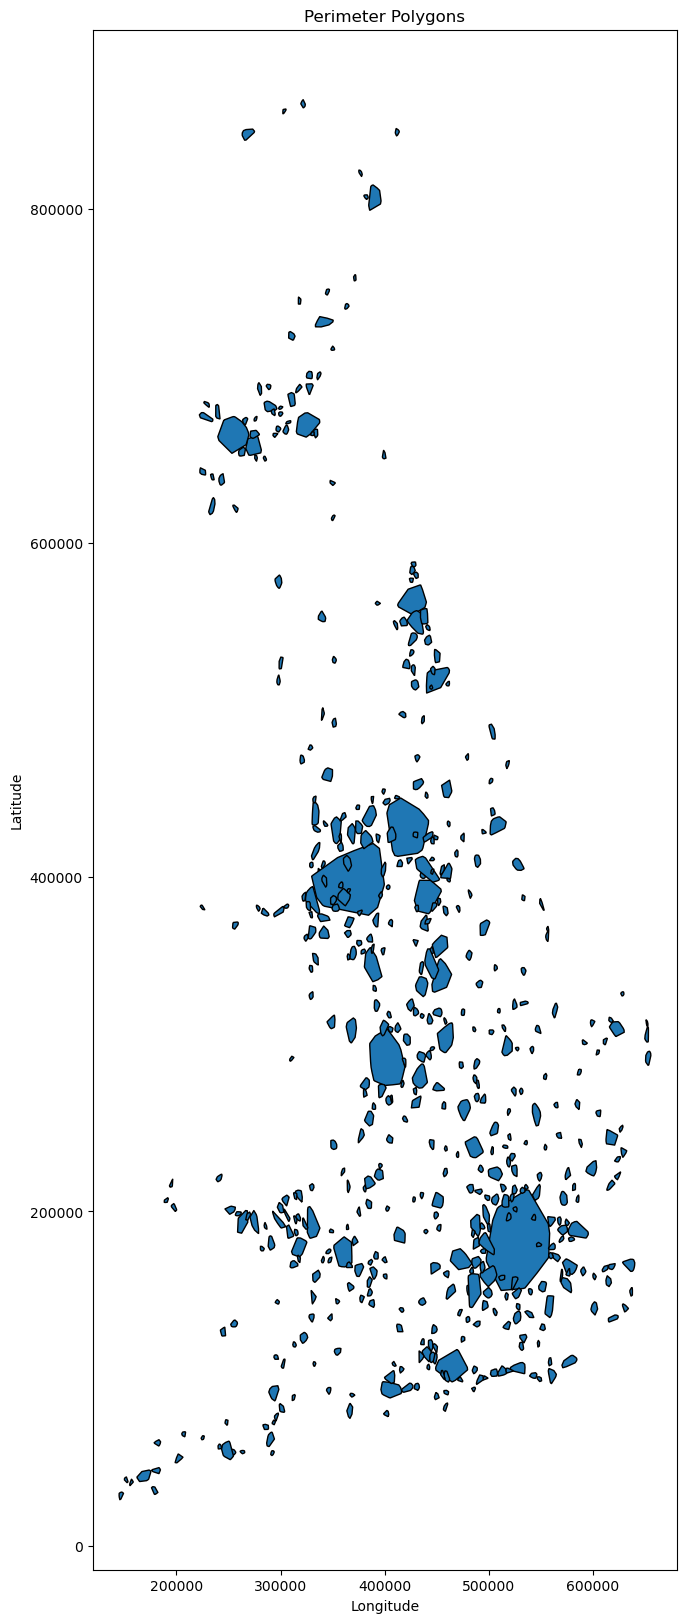

In [93]:
# Plot the perimeters to visually inspect the geometries
gdf.plot(figsize=(30, 20), edgecolor='black')
plt.title('Perimeter Polygons')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### C.3.3 Calculate City Level Metrics & Add to GDF

## D. Catgeorise Cities Based on Boeing's Topological Metrics

Leveraging a Silhouette Score, CH Index and the Elbow Method, we determine the most insightful number of clusters we should use for our analysis.

### D.1 Use Silhouette Score, CH Index and Elbow Method to determine Cluster no.

In [148]:
# Select relevant features for clustering
features = gdf[['diameter', 'cc_avg_dir', 'cc_avg_undir', 
                'prop_3way', 'prop_4way', 'prop_deadend', 'pagerank_max', 
                'self_loop_proportion', 'orientation_entropy', 'orientation_order']]

# Ensure all features are numeric
features = features.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values and check the shape
features = features.dropna()
print(features.shape)

# Standardize the features
if not features.empty:
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Verify the data types and check for any remaining issues
    print(features.dtypes)
    print(features.head())

    # Step 2: KMeans Clustering
    range_n_clusters = range(2, 30)  # Example range, adjust as needed
    silhouette_scores = []
    ch_scores = []
    inertia = []

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(features_scaled)
        
        # Step 3: Evaluate Clustering Quality
        silhouette_avg = silhouette_score(features_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        ch_score = calinski_harabasz_score(features_scaled, cluster_labels)
        ch_scores.append(ch_score)
        
        inertia.append(kmeans.inertia_)

    # Step 4: Visualize Results

    # Silhouette Score Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_scores, marker='o', label='Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calinski-Harabasz Index Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, ch_scores, marker='o', label='Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Calinski-Harabasz Index vs. Number of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Elbow Method Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, inertia, marker='o', label='Inertia')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("The features DataFrame is empty after dropping NaN values.")

(0, 10)
The features DataFrame is empty after dropping NaN values.


### D.2 Conduct Clustering / City Categorisation

Silhouette Score, CH Index and the Elbow Method Suggest an Optimal 11 Clusters. 

Below we cluster the UK cities in order to determine the categories of UK cities.

In [147]:
gdf = gpd.read_file('Data/clusterinfo_gdf.gpkg')

In [130]:
features_for_scaling = features.drop(columns=['cc_avg_dir', 'cc_avg_undir'])

In [132]:
# Select only the numeric columns from the DataFrame
features_for_scaling = features.select_dtypes(include=[float, int])

# Now apply the scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_scaling)

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming 'features_for_scaling' is your DataFrame with the problematic columns removed
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_scaling)  # Use the modified DataFrame here

# For example, let's assume the optimal number of clusters is 11
optimal_n_clusters = 11
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42)
gdf['cluster'] = kmeans_optimal.fit_predict(features_scaled)

In [134]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   cluster_id            534 non-null    int64   
 1   node_count            534 non-null    int64   
 2   diameter              534 non-null    float64 
 3   cc_avg_dir            534 non-null    object  
 4   cc_avg_undir          534 non-null    object  
 5   prop_3way             534 non-null    float64 
 6   prop_4way             534 non-null    float64 
 7   prop_deadend          534 non-null    float64 
 8   pagerank_max          534 non-null    float64 
 9   self_loop_proportion  534 non-null    float64 
 10  orientation_entropy   534 non-null    float64 
 11  orientation_order     534 non-null    float64 
 12  geometry              534 non-null    geometry
 13  cluster               534 non-null    int32   
dtypes: float64(8), geometry(1), int32(1), int64(2), ob

In [137]:
gdf.head(15)

,cluster_id,node_count,diameter,cc_avg_dir,cc_avg_undir,prop_3way,prop_4way,prop_deadend,pagerank_max,self_loop_proportion,orientation_entropy,orientation_order,geometry,cluster
0,0,1042,62.0,"(0.04936014625228519, 0.004366109403404768)","(0.04936014625228519, 0.004366109403404768)",0.619002,0.026871,0.263916,0.001860,0.002390,0.417481,0.939921,"POLYGON ((336134.63000 404540.13000, 336540.21...",5
1,1,4374,126.0,"(0.04331182325276168, 0.002108139483453271)","(0.04331182325276168, 0.002108139483453271)",0.579332,0.048240,0.281893,0.000472,0.008020,0.411411,0.950926,"POLYGON ((444716.05000 115895.68000, 444644.73...",2
2,2,15509,174.0,"(0.04032912272569243, 0.0010544292320391086)","(0.04032912272569243, 0.0010544292320391086)",0.603843,0.057064,0.257463,0.000138,0.003615,0.414861,0.957006,"POLYGON ((380562.50000 346131.19000, 388074.32...",0
3,3,9410,175.0,"(0.034497651568320464, 0.0013406480211598012)","(0.034497651568320464, 0.0013406480211598012)",0.564081,0.035175,0.313177,0.000210,0.006592,0.408580,0.955344,"POLYGON ((476785.14000 254341.90000, 481592.66...",2
4,4,140328,953.0,"(0.039533291439612074, 0.0003453284507100746)","(0.039533291439612074, 0.0003453284507100746)",0.591764,0.070627,0.248496,0.000017,0.003383,0.414306,0.965043,"POLYGON ((399654.84000 395804.48000, 394988.00...",3
5,5,5714,183.0,"(0.037726604605585495, 0.0017632857328100124)","(0.037726604605585495, 0.0017632857328100124)",0.575254,0.056003,0.273364,0.000346,0.005072,0.427690,0.950560,"POLYGON ((259419.37000 195788.52000, 258802.33...",7
6,6,71347,408.0,"(0.0384727425462872, 0.0004967171975710788)","(0.0384727425462872, 0.0004967171975710788)",0.588308,0.040576,0.294799,0.000031,0.005957,0.409205,0.963383,"POLYGON ((389877.80000 278217.78000, 400168.00...",0
7,7,3779,134.0,"(0.045402518122853876, 0.002323098172997538)","(0.045402518122853876, 0.002323098172997538)",0.585075,0.041810,0.275470,0.000516,0.007735,0.415329,0.949579,"POLYGON ((284227.28000 683843.65000, 285317.00...",2
8,8,10469,253.0,"(0.038873239436619716, 0.0013846939907927332)","(0.038873239436619716, 0.0013846939907927332)",0.560799,0.020823,0.328971,0.000216,0.010497,0.409208,0.955791,"POLYGON ((483722.13000 169028.89000, 478083.73...",2
9,9,692,63.0,"(0.0330188679245283, 0.004843431136456512)","(0.0330188679245283, 0.004843431136456512)",0.537572,0.027457,0.361272,0.002773,0.003886,0.421599,0.935531,"POLYGON ((311349.20000 89776.53000, 311263.010...",4


In [140]:
# Create a new GeoDataFrame to hold the cluster perimeters
clusterperim_gdf = gdf.dissolve(by='cluster')
clusterperim_gdf = clusterperim_gdf[['geometry']].reset_index()

# Ensure the geometry column is a MULTIPOLYGON
clusterperim_gdf['geometry'] = clusterperim_gdf['geometry'].apply(lambda geom: geom if geom.geom_type == 'MultiPolygon' else MultiPolygon([geom]))

# Rename the column for clarity
clusterperim_gdf = clusterperim_gdf.rename(columns={'cluster': 'cluster_no'})

/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_95494/4033473398.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.centroid


KeyError: 'size_scaled'

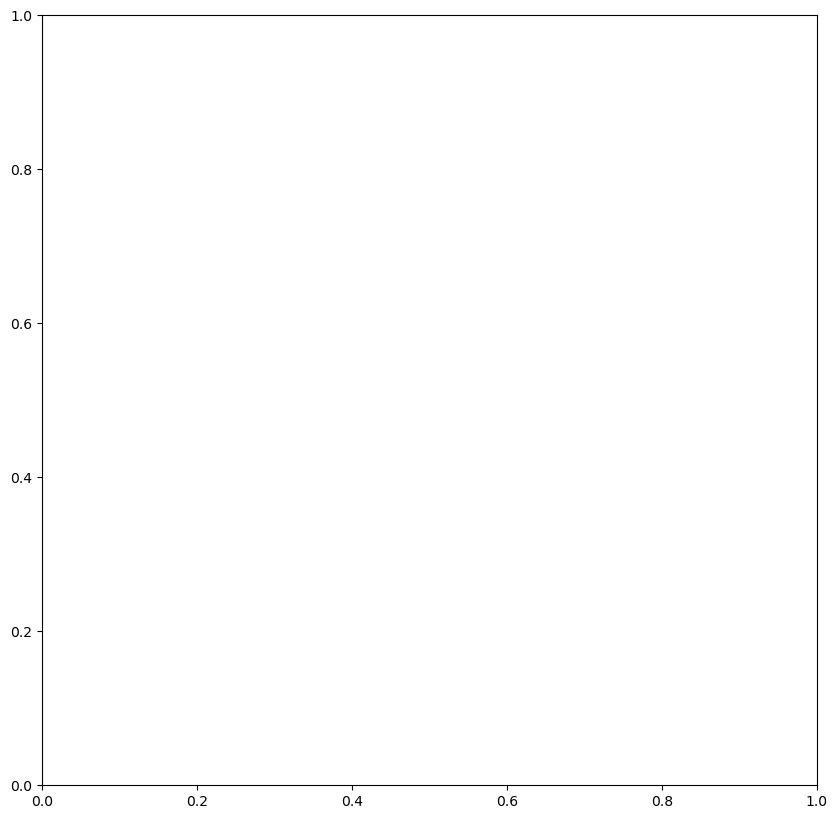

In [141]:
# Convert all geometries to their centroids
gdf['geometry'] = gdf.centroid

# Now you can use .x and .y
fig, ax = plt.subplots(figsize=(10, 10))

# Base map
gdf.plot(ax=ax, marker='o', color='none', edgecolor='k', markersize=gdf['size_scaled'], alpha=0.5)

# Overlay the bubbles with color based on orientation entropy
sc = ax.scatter(gdf.geometry.x, gdf.geometry.y, s=gdf['size_scaled'], c=gdf['orientation_entropy'], cmap='viridis', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax)
plt.show()

/var/folders/2b/wg0jj3c17h7_jxlfglq9nw100000gn/T/ipykernel_95494/846756475.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.centroid


KeyError: 'size_scaled'

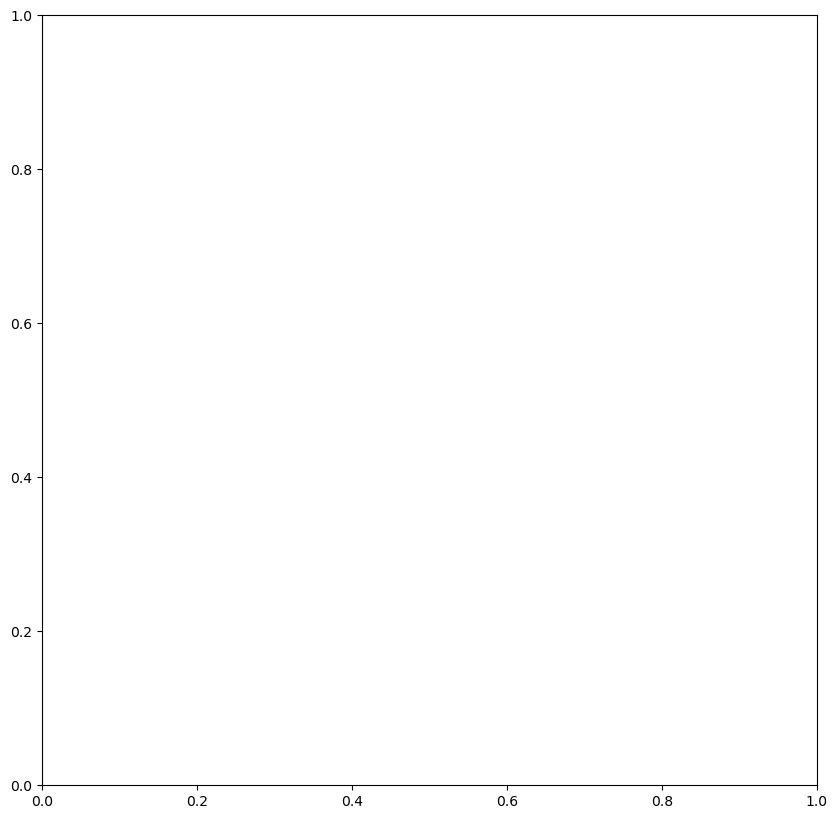

In [142]:
# Use centroids for plotting while keeping the original geometry
centroids = gdf.centroid

fig, ax = plt.subplots(figsize=(10, 10))

# Base map
gdf.plot(ax=ax, marker='o', color='none', edgecolor='k', markersize=gdf['size_scaled'], alpha=0.5)

# Overlay the bubbles with color based on orientation entropy using centroids
sc = ax.scatter(centroids.x, centroids.y, s=gdf['size_scaled'], c=gdf['orientation_entropy'], cmap='viridis', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax)
plt.show()


In [ ]:
clusterperim_gdf.info()

In [ ]:
clusterperim_gdf.head()

In [ ]:
# Assuming gdf and clusterperim_gdf are your GeoDataFrames
# Save the gdf GeoDataFrame to a GPKG file
gdf.to_file("city_categories.gpkg", driver="GPKG")

# Save the clusterperim_gdf GeoDataFrame to a GPKG file
clusterperim_gdf.to_file("citycat_perim_gdf.gpkg", driver="GPKG")

### D.3 Visualise Clusters

In [ ]:
# Fix invalid geometries
gdf['geometry'] = gdf['geometry'].buffer(0)

# Verify if the geometries are now valid
print("All geometries valid after fix:", gdf['geometry'].is_valid.all())

In [ ]:
gdf = gdf[gdf['geometry'].type.isin(['LineString', 'MultiLineString'])]

Plotting cluster 5 with color (0.127568, 0.566949, 0.550556, 1.0)
Plotting cluster 2 with color (0.253935, 0.265254, 0.529983, 1.0)
Plotting cluster 0 with color (0.267004, 0.004874, 0.329415, 1.0)
Plotting cluster 3 with color (0.206756, 0.371758, 0.553117, 1.0)
Plotting cluster 7 with color (0.266941, 0.748751, 0.440573, 1.0)
Plotting cluster 4 with color (0.163625, 0.471133, 0.558148, 1.0)
Plotting cluster 6 with color (0.134692, 0.658636, 0.517649, 1.0)
Plotting cluster 1 with color (0.282623, 0.140926, 0.457517, 1.0)
Plotting cluster 10 with color (0.993248, 0.906157, 0.143936, 1.0)
Plotting cluster 9 with color (0.741388, 0.873449, 0.149561, 1.0)
Plotting cluster 8 with color (0.477504, 0.821444, 0.318195, 1.0)


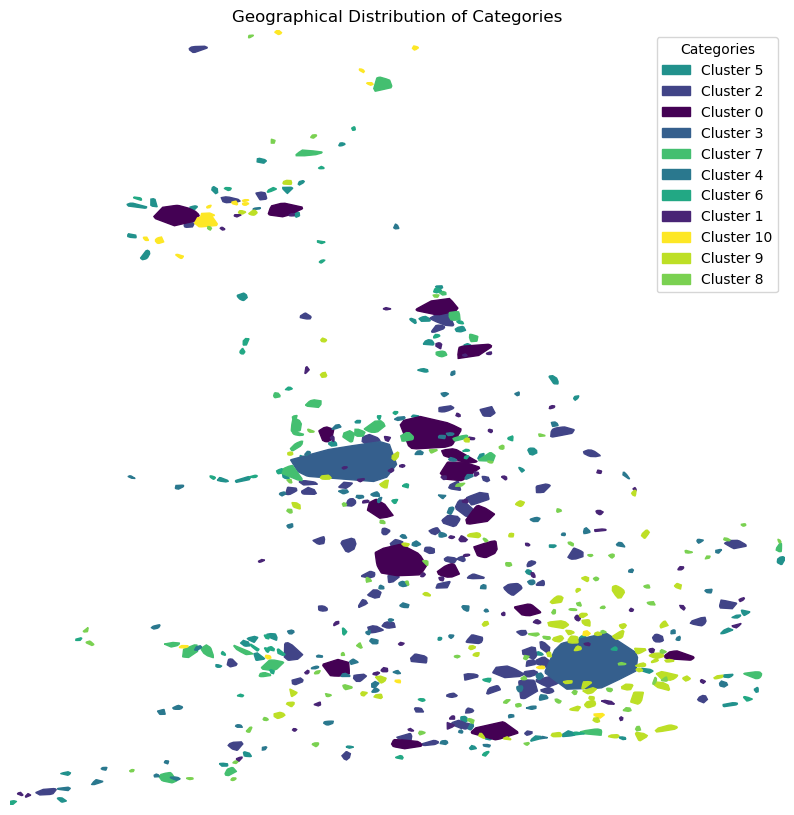

In [139]:
# define colormap
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=gdf['cluster'].min(), vmax=gdf['cluster'].max())

# create plot
fig, ax = plt.subplots(1, 1, figsize=(10, 20))

# manually plot clusters with a different color manually
for cluster_id in gdf['cluster'].unique():
    cluster_gdf = gdf[gdf['cluster'] == cluster_id]
    color = cmap(norm(cluster_id))
    print(f"Plotting cluster {cluster_id} with color {color}")
    for geom in cluster_gdf['geometry']:
        if isinstance(geom, Polygon):
            x, y = geom.exterior.xy
            ax.fill(x, y, color=color, label=f'Cluster {cluster_id}')
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:  # Correctly iterate over geometries in MultiPolygon
                x, y = poly.exterior.xy
                ax.fill(x, y, color=color, label=f'Cluster {cluster_id}')
        else:
            print(f"Unknown geometry type: {type(geom)}")

# aesthetics etc
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', title='Categories')
plt.title('Geographical Distribution of Categories')

# remove axis
ax.set_axis_off()

xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect((xmax - xmin) / (ymax - ymin))

# Show plot
plt.show()

### D.4 Biserial Correlation: Find metrics highly correlated to each cluster

In [ ]:
from scipy.stats import pointbiserialr

clusters = gdf['cluster'].unique()
metrics = ['diameter', 'cc_avg_dir_value', 'cc_avg_undir_value',
           'prop_3way', 'prop_4way', 'prop_deadend', 'pagerank_max',
           'self_loop_proportion', 'orientation_entropy', 'orientation_order']

correlation_results = {}

# Calculate point biserial correlation for each cluster and metric
for cluster in clusters:
    cluster_column = f'cluster_{cluster}'
    gdf[cluster_column] = np.where(gdf['cluster'] == cluster, 1, 0)
    correlations = []
    for metric in metrics:
        correlation, _ = pointbiserialr(gdf[cluster_column], gdf[metric])
        correlations.append(correlation)
    correlation_results[cluster] = correlations

# Create DataFrame from correlation results
correlation_df = pd.DataFrame(correlation_results, index=metrics)

# Debug: Inspect the correlation DataFrame before renaming columns
print("Correlation DataFrame (before renaming columns):")
print(correlation_df)
print("Shape of Correlation DataFrame:", correlation_df.shape)

# Transpose and rename columns
correlation_df = correlation_df.T
correlation_df.columns = [f'Correlation_{metric}' for metric in metrics]
correlation_df.index.name = 'Cluster'
correlation_df.reset_index(inplace=True)

# Debug: Inspect the final correlation DataFrame
print("Correlation DataFrame (after renaming columns):")
print(correlation_df)
print("Shape of Correlation DataFrame:", correlation_df.shape)

In [ ]:
from scipy.stats import f_oneway

# List of all metrics to analyze
metrics = ['diameter', 'cc_avg_dir_value', 'cc_avg_undir_value',
           'prop_3way', 'prop_4way', 'prop_deadend', 'pagerank_max',
           'self_loop_proportion', 'orientation_entropy', 'orientation_order']

# Calculate mean and standard deviation for each metric in each cluster
cluster_stats = gdf.groupby('cluster')[metrics].agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

# Perform ANOVA to test if there are significant differences between clusters for each metric
anova_results = {}
for metric in metrics:
    groups = [gdf[gdf['cluster'] == cluster][metric].dropna() for cluster in gdf['cluster'].unique()]
    anova_results[metric] = f_oneway(*groups)

print("\nANOVA Results:")
for metric, result in anova_results.items():
    print(f"{metric}: F-statistic={result.statistic}, p-value={result.pvalue}")

# Visualization
# Box plots
plt.figure(figsize=(20, 15))
for i, metric in enumerate(metrics, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='cluster', y=metric, data=gdf)
    plt.title(f'Box plot of {metric} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# Heatmaps of correlations within each cluster
for cluster in gdf['cluster'].unique():
    cluster_data = gdf[gdf['cluster'] == cluster][metrics]
    corr_matrix = cluster_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for Cluster {cluster}')
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# List of all metrics to analyze
metrics = ['diameter', 'cc_avg_dir_value', 'cc_avg_undir_value',
           'prop_3way', 'prop_4way', 'prop_deadend', 'pagerank_max',
           'self_loop_proportion', 'orientation_entropy', 'orientation_order']

# Extract features
features = gdf[metrics].dropna()

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=len(metrics))
pca_result = pca.fit_transform(features_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by each Principal Component:\n", explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(metrics)+1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, len(metrics)+1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - Explained Variance Ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# PCA Components
pca_components = pd.DataFrame(pca.components_, columns=metrics)
print("PCA Components:\n", pca_components)

Interpretation of PCA Results
The PCA results provide insight into which characteristics are most influential in explaining the variance in the dataset. Here's a detailed interpretation of the results:

Explained Variance by Each Principal Component:

The first principal component (PC1) explains 36.4% of the variance.
The second principal component (PC2) explains 21.5% of the variance.
Together, the first two principal components explain about 58% of the total variance in the data.
The first four principal components explain about 81% of the variance.
PCA Components:

Each row in the PCA components table represents the loadings of the original features on the principal components.
Higher absolute values in a row indicate that the corresponding feature contributes more to that principal component.
Key Observations from PCA Components
PC1:

Strong positive loadings on diameter, prop_3way, prop_4way, and negative loadings on prop_deadend and pagerank_max.
Indicates that cities with larger diameters and higher proportions of three-way and four-way intersections tend to have lower proportions of dead ends and lower pagerank_max.
PC2:

High positive loadings on cc_avg_dir_value, cc_avg_undir_value, and self_loop_proportion.
Indicates that cities with higher clustering coefficients and self-loop proportions are distinguished along this component.
PC3:

Positive loadings on cc_avg_dir_value, cc_avg_undir_value, and self_loop_proportion, and negative loadings on prop_3way and prop_4way.
Highlights the balance between clustering coefficients, self-loop proportions, and intersection types.
PC4:

Positive loadings on node_count and diameter.
Indicates that the size and geographic spread of the city's network are major factors in this component.

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc  # Import colorcet

# Add cluster labels to features
features = gdf[metrics].dropna()
labels = gdf.loc[features.index, 'cluster']

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features, labels)

# Feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': metrics, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", importance_df)

# Plot feature importance using the glasbey_cool color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=cc.glasbey_cool)
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier


# Add cluster labels to features
features = gdf[metrics].dropna()
labels = gdf.loc[features.index, 'cluster']

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features, labels)

# Feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': metrics, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Random Forest - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Interpretation of Random Forest Feature Importance
The Random Forest feature importance analysis provides a quantitative measure of how much each feature contributes to predicting the cluster labels. Here's the interpretation based on the importance values:

Orientation Order (0.140903):

The most important feature in predicting the cluster labels.
Indicates that the regularity and predictability of the street layout are key differentiators between clusters.
Proportion of Dead Ends (0.133395):

The second most important feature.
Highlights the significance of the network's structural composition, particularly the presence of dead ends, in determining cluster membership.
Clustering Coefficient (Undirected) (0.105552):

High importance suggests that the density and interconnectedness of the network, as measured by the clustering coefficient, are crucial in distinguishing clusters.
Pagerank Max (0.093969):

The importance of this feature indicates that the prominence and influence of specific nodes within the network play a significant role in cluster classification.
Clustering Coefficient (Directed) (0.092806):

Similar to the undirected clustering coefficient, this metric's high importance underscores the role of network density and interconnections.
Proportion of Three-Way Intersections (0.087037):

Indicates the importance of the type of intersections in the network structure.
Self-Loop Proportion (0.083658):

The proportion of self-loops also significantly contributes to the cluster classification, highlighting the presence of circular paths within the network.
Node Count (0.078848):

While still important, node count has less importance compared to other features, suggesting that while the size of the network matters, other structural characteristics are more influential.
Orientation Entropy (0.068986):

Measures the disorder in the street layout, contributing to the cluster classification but with lower importance compared to orientation order.
Proportion of Four-Way Intersections (0.066438):

Indicates that the presence of four-way intersections also plays a role in differentiating clusters.
Diameter (0.048407):

The least important feature in this analysis, suggesting that while the geographic spread of the network is relevant, it is less critical than other features in determining the clusters.
Summary and Conclusion
The feature importance results from the Random Forest analysis provide a nuanced understanding of which characteristics are most influential in determining the city clusters. Here are the key takeaways:

Orientation Order and Proportion of Dead Ends are the top two most important features, indicating that the regularity and structural composition of the street layout are crucial for cluster classification.

Clustering Coefficients (both directed and undirected) and Pagerank Max also play significant roles, highlighting the importance of network density, interconnections, and node prominence.

Intersection Proportions (three-way and four-way) and Self-Loop Proportion contribute notably to cluster differentiation, emphasizing the role of specific types of intersections and circular paths.

Node Count and Diameter are less influential compared to other features, suggesting that while the size and spread of the network matter, other structural and topological characteristics are more critical.

In [ ]:
correlation_df

In [ ]:
for metric in metrics:
    correlation_results[metric] = {}
    for cluster in clusters:
        binary_indicator = gdf[f'cluster_{cluster}']
        biserial_corr, _ = pointbiserialr(binary_indicator, gdf[metric])
        correlation_results[metric][cluster] = biserial_corr

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming correlation_df is your DataFrame

# Remove 'Correlation_' prefix from column names for the legend
correlation_df_renamed = correlation_df.rename(columns=lambda x: x.replace('Correlation_', ''))

# Set the figure size
plt.figure(figsize=(15, 10))

# Loop through each metric and plot it as a bar in the same plot
for metric in correlation_df_renamed.columns[1:]:
    plt.barh(correlation_df_renamed['Cluster'], correlation_df_renamed[metric], label=metric)

# Add title and labels
plt.title('Biserial Correlation Between Topological Metrics and Clusters')
plt.xlabel('Correlation')
plt.ylabel('Cluster')

# Add legend
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

In [ ]:
print(correlation_df)

## E. Local Betweenness Calculations

### E.1 Define Function 
To Calculate Local Betweenness Score for all Nodes & Edges in Network

### Step 1: Filter Edges Within Polygons

In [ ]:
# Ensure vertex positions are in the correct format
pos = G_gt.vertex_properties['pos']

# Function to get edges within a polygon with debug prints
def get_edges_within_polygon(polygon, G_gt, pos):
    edges_within_polygon = []
    vertices_within_polygon = set()
    for e in G_gt.edges():
        u, v = e.source(), e.target()
        point_u = Point(pos[u][0], pos[u][1])
        point_v = Point(pos[v][0], pos[v][1])
        if polygon.contains(point_u) and polygon.contains(point_v):
            edges_within_polygon.append(e)
            vertices_within_polygon.add(u)
            vertices_within_polygon.add(v)
    return edges_within_polygon, vertices_within_polygon

### Step 2. Calculate Local Betweenness Centrality

In [ ]:
start_time = time.time()

for i, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Calculating local betweenness centrality for cities"):
    polygon = row.geometry
    
    # Timing the edge filtering
    filter_start_time = time.time()
    edges_within_polygon, vertices_within_polygon = get_edges_within_polygon(polygon, G_gt, pos)
    filter_end_time = time.time()
    
    print(f"Cluster {i}: Number of edges within polygon = {len(edges_within_polygon)}")
    
    if len(edges_within_polygon) > 0:
        # Timing the betweenness calculation
        betweenness_start_time = time.time()
        edge_betweenness, subgraph = calculate_local_betweenness(edges_within_polygon, vertices_within_polygon, G_gt)
        betweenness_end_time = time.time()
        
        # Verify betweenness values
        betweenness_values = [edge_betweenness[e] for e in subgraph.edges()]
        print(f"Cluster {i}: Betweenness values = {betweenness_values[:10]} (showing first 10)")

        for e in subgraph.edges():
            edge_betweenness_prop[e] = edge_betweenness[e]
        
        # Print the timing for each step
        print(f"Cluster {i}: Filter Time = {filter_end_time - filter_start_time:.2f}s, Betweenness Time = {betweenness_end_time - betweenness_start_time:.2f}s")

# Set this new property to the graph
G_gt.edge_properties["betweenness"] = edge_betweenness_prop

# Total processing time
end_time = time.time()
print(f"Total processing time: {end_time - start_time:.2f}s")

In [ ]:
G_gt = gt.load_graph("graph_gt.gt")

In [ ]:
# Alternatively, you can save it in GT format
# G_gt.save("graph_gt.gt")

In [ ]:
import networkx as nx
import graph_tool.all as gt
from tqdm import tqdm

def gt_to_nx(G_gt):
    G_nx = nx.Graph()

    # Transfer vertex properties
    vertex_map = {}
    for v in tqdm(G_gt.vertices(), desc="Transferring vertex properties"):
        node_id = int(v)
        vertex_map[v] = node_id
        G_nx.add_node(node_id)
        for prop in G_gt.vertex_properties.keys():
            value = G_gt.vertex_properties[prop][v]
            if prop == 'geometry':
                value = str(value)  # Convert geometry to string
            elif isinstance(value, (gt.Vector_double, list, tuple)):
                value = ','.join(map(str, value))  # Convert lists to comma-separated strings
            G_nx.nodes[node_id][prop] = value

    # Transfer edge properties
    for e in tqdm(G_gt.edges(), desc="Transferring edge properties"):
        u, v = int(e.source()), int(e.target())
        G_nx.add_edge(u, v)
        for prop in G_gt.edge_properties.keys():
            value = G_gt.edge_properties[prop][e]
            if isinstance(value, (gt.Vector_double, list, tuple)):
                value = ','.join(map(str, value))  # Convert lists to comma-separated strings
            G_nx[u][v][prop] = value

    return G_nx

# Convert the entire graph
G_nx = gt_to_nx(G_gt)

In [ ]:
# nx.write_graphml(G_nx, "G_final.graphml")

In [ ]:
G_nx = nx.read_graphml("Data/Archive/G_final.graphml")

In [ ]:
# check size of G
print(f"Number of nodes: {G_nx.number_of_nodes()}")
print(f"Number of edges: {G_nx.number_of_edges()}")

In [ ]:
list(G_nx.edges(data=True))[0]

In [ ]:
list(G_nx.nodes(data=True))[0]

## Plot Betweeness Values

In [ ]:
# Extract edge betweenness values and geometries from G_nx
edges = []
betweenness_values = []

for u, v, data in G_nx.edges(data=True):
    if 'geometry' in data and 'betweenness' in data:
        geom = data['geometry']
        # Convert the geometry from string to LineString
        try:
            coords = [tuple(map(float, point.split())) for point in geom.replace('LINESTRING (', '').replace(')', '').split(',')]
            line = LineString(coords)
            edges.append(line)
            betweenness_values.append(float(data['betweenness']))
        except Exception as e:
            print(f"Error parsing geometry for edge {u}-{v}: {e}")

# Create a GeoDataFrame
gdf_edges = gpd.GeoDataFrame({'geometry': edges, 'betweenness': betweenness_values})


In [ ]:
# Print summary statistics of the 'betweenness' column
print(gdf_edges['betweenness'].describe())

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from shapely.geometry import LineString

# Extract edge betweenness values and geometries from G_nx
edges = []
betweenness_values = []

for u, v, data in G_nx.edges(data=True):
    if 'geometry' in data and 'betweenness' in data:
        geom = data['geometry']
        # Convert the geometry from string to LineString
        try:
            coords = [tuple(map(float, point.split())) for point in geom.replace('LINESTRING (', '').replace(')', '').split(',')]
            line = LineString(coords)
            edges.append(line)
            betweenness_values.append(float(data['betweenness']))
        except Exception as e:
            print(f"Error parsing geometry for edge {u}-{v}: {e}")

# Create a GeoDataFrame
gdf_edges = gpd.GeoDataFrame({'geometry': edges, 'betweenness': betweenness_values})

# Apply log transformation to betweenness values
log_betweenness_values = np.log(gdf_edges['betweenness'] + 1e-10)

# Plot histogram of the log-transformed betweenness values
plt.figure(figsize=(30, 20))
sns.histplot(log_betweenness_values, bins=100, kde=True)
plt.title('Distribution of Log-Transformed Betweenness Centrality Values')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Filter out extremely low log-transformed betweenness values
filtered_log_betweenness_values = gdf_edges[gdf_edges['betweenness_log'] > -23]['betweenness_log']

# Plot histogram of the filtered log-transformed betweenness values
plt.figure(figsize=(10, 6))
sns.histplot(filtered_log_betweenness_values, bins=100, kde=True, color='red', alpha=0.7)
plt.title('Filtered Distribution of Log-Transformed Betweenness Centrality Values')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import graph_tool.all as gt

# Compute betweenness centrality
node_betweenness, edge_betweenness = gt.betweenness(G_gt)

# Create property maps for vertex betweenness
node_betweenness_prop = G_gt.new_vertex_property("double")

# Assign values to the property map
for v in G_gt.vertices():
    node_betweenness_prop[v] = node_betweenness[v]

# Set the vertex betweenness property in the graph
G_gt.vertex_properties["betweenness"] = node_betweenness_prop

# Create property maps for edge betweenness (already assigned, if you have this)
edge_betweenness_prop = G_gt.new_edge_property("double")
for e in G_gt.edges():
    edge_betweenness_prop[e] = edge_betweenness[e]
G_gt.edge_properties["betweenness"] = edge_betweenness_prop

### Step 3: Loop Over Each City Cluster

In [ ]:
# Extract the node counts from the gdf
node_counts = gdf['node_count'].tolist()

# Sort the list in descending order
node_counts_sorted = sorted(node_counts, reverse=True)

# Print the sorted list of node counts
print(node_counts_sorted)

In [ ]:
# Extract the node counts from the gdf
node_counts = gdf['node_count'].tolist()

# Print the list of node counts
print(node_counts)

### E.2 Before converting gt graph back to an nx graph, we ensure all data is in the correct format

### E.3 Check

## D. Spatial Join: Clusters and POI Data

### D.1 Read in Retail Data

In [ ]:
# read retail data
retail = gpd.read_file('Data/OS_POIs/poi_uk.gpkg')
retail = retail.to_crs('EPSG:27700')

In [ ]:
# new object
retail['geometry'] = retail.apply(lambda row: Point(row['feature_easting'], row['feature_northing']), axis=1)

# drop 'feature_easting' and 'feature_northing'
retail.drop(columns=['feature_easting', 'feature_northing'], inplace=True)

# df to gdf
retail_gdf = gpd.GeoDataFrame(retail, geometry='geometry')

# EPSG:27700
retail_gdf.set_crs(epsg=27700, inplace=True)

# check
retail_gdf.head()

In [ ]:
retail_gdf.info()

In [ ]:
# check for for null & '0' values
null_counts = retail_gdf.isnull().sum()
zero_counts = (retail_gdf[['geometry', 'groupname', 'categoryname', 'pointx_class', 'classname']] == 0).sum()

# put into df
missing_data_summary = pd.DataFrame({
    'null_values': null_counts,
    'zero_values': zero_counts.reindex(retail_gdf.columns, fill_value=0)
})
# summary
missing_data_summary

### D.2 Remove Unneccessary Data
Here we remove unneccessary data from 'retail_gdf'. We only keep retail data. This includes 'Accommodation, Eating and Drinking' , 'Retail' and 'Commercial Services'

Secondly we keep only the columns 'geometry', 'groupname', 'categoryname', 'pointx_class' and 'classname'

In [ ]:
# Step 1: Filter rows based on the values in 'groupname'
filtered_gdf = retail_gdf[retail_gdf['groupname'].isin(['Accommodation, Eating and Drinking', 'Retail'])]

# Step 2: Keep only the desired columns
reduced_gdf = filtered_gdf[['geometry', 'groupname', 'categoryname', 'pointx_class', 'classname']]

# Optional: Save the reduced GeoDataFrame to a new file
reduced_gdf.to_file("reduced_retail.gpkg", layer='reduced_retail', driver="GPKG")

# Display the first few rows of the reduced GeoDataFrame for verification
reduced_gdf.head()

In [ ]:
reduced_gdf.info()

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(15, 12))

# Plotting each groupname category with a different color and smaller node size
reduced_gdf.plot(column='groupname', ax=ax, legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, markersize=0.5, cmap='tab20')

# Add basemap for better aesthetics
ctx.add_basemap(ax, crs=reduced_gdf.crs.to_string())

# Set plot title and remove axis labels for a cleaner look
plt.title('Filtered Retail Locations by Group Name')

plt.show()

In [ ]:
# Make a copy of the original gdf to ensure the original remains unchanged
gdf_copy = gdf.copy()

### D.3 Filter Complete Dataset Based on Cities

In [ ]:
# Initialize an empty list to hold the filtered points
filtered_points = []

# Check if points in reduced_gdf are within any polygon in gdf_copy
for idx, point in tqdm(reduced_gdf.iterrows(), total=reduced_gdf.shape[0], desc="Filtering points"):
    if gdf_copy.geometry.apply(lambda poly: poly.contains(point.geometry)).any():
        filtered_points.append(point)

# Create a new GeoDataFrame from the filtered points
filtered_gdf = gpd.GeoDataFrame(filtered_points, columns=reduced_gdf.columns, crs=reduced_gdf.crs)

# Verify the number of points after filtering
print(f"Number of points after filtering: {filtered_gdf.shape[0]}")

In [ ]:
filtered_gdf.to_file('Data/filtered_retail_locations.gpkg', layer='reduced_retail', driver="GPKG")

In [ ]:
filtered_gdf = gpd.read_file('Data/filtered_retail_locations.gpkg')

In [ ]:
# Plot the filtered gdf
fig, ax = plt.subplots(figsize=(12, 8))
retail_gdf.plot(column='groupname', ax=ax, legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, markersize=0.5, cmap='viridis')

# Add basemap with proper handling for CRS
ctx.add_basemap(ax, crs=retail_gdf.crs.to_string())

plt.title('Filtered Retail Locations within Cluster Polygons')
plt.show()

In [ ]:
# filtered_gdf.to_file("filtered_retail_locations.gpkg", driver="GPKG")

#print("Filtered GeoDataFrame has been saved to 'filtered_retail_locations.gpkg'")

In [ ]:
filtered_gdf.head()

## F. Spatial Join

At this point we have prepared the two datasets for a spatial join.

The Graph data read in below contains only the nodes and edges contained within the 534 clusters we have identified. 

#### F.0 Read in Data

In [ ]:
# read in both datasets
G_nx = nx.read_graphml("Data/Archive/G_urbclus_betw_full.graphml")

In [ ]:
filtered_gdf = gpd.read_file("filtered_retail_locations.gpkg")

### F.1 Ensure CRS of both Datasets are in the correct format

In [ ]:
# Check CRS of filtered_gdf
print("CRS of filtered_gdf:", filtered_gdf.crs)

# Extract CRS from G_nx node geometries
# Assuming geometries are stored in 'geometry' attribute and are in WKT format
sample_node = list(G_nx.nodes(data=True))[0]
sample_geometry = sample_node[1].get('geometry', None)

if sample_geometry:
    sample_geom = gpd.GeoSeries.from_wkt([sample_geometry])
    graph_crs = sample_geom.crs
    print("CRS of G_nx geometries (inferred from sample node):", graph_crs)
else:
    print("No geometry found in sample node to infer CRS.")

In [ ]:
list(G_nx.nodes(data=True))[0]

In [ ]:
list(G_nx.edges(data=True))[0]

In [ ]:
# Convert node geometries to GeoDataFrame
node_data = []
for node, data in G_nx.nodes(data=True):
    geom = wkt.loads(data['geometry'])
    node_data.append({
        'node': node,
        'geometry': geom,
        'pos': data['pos'],
        'betweenness': data['betweenness'],
        'form_of_road_node': data['form_of_road_node'],
        'degree': data['degree'],
        'angle': data['angle']
    })

nodes_gdf = gpd.GeoDataFrame(node_data, crs='EPSG:27700')

# Convert edge geometries to GeoDataFrame
edge_data = []
for u, v, data in G_nx.edges(data=True):
    geom = wkt.loads(data['geometry'])
    edge_data.append({
        'u': u,
        'v': v,
        'geometry': geom,
        'length': data['length'],
        'betweenness': data['betweenness'],
        'road_classification': data['road_classification'],
        'road_function': data['road_function'],
        'form_of_way': data['form_of_way'],
        'primary_route': data['primary_route'],
        'trunk_road': data['trunk_road']
    })

edges_gdf = gpd.GeoDataFrame(edge_data, crs='EPSG:27700')

In [ ]:
# verify conversion
nodes_gdf.head()

In [ ]:
edges_gdf.head()

### F.2 Using cityseer to assign POI data to associated edge

In [ ]:
G_copy = G_nx.copy()

In [ ]:
# Function to convert WKT geometry to shapely LineString
def wkt_to_linestring(wkt_str):
    return wkt.loads(wkt_str)

# Copy the 'geometry' attribute to 'geom' for each edge
for u, v, data in tqdm(G_copy.edges(data=True), desc="Converting geometry to geom"):
    if 'geometry' in data and 'geom' not in data:
        data['geom'] = wkt_to_linestring(data['geometry'])

# Extract 'x' and 'y' from 'pos' and add them to each node
for node, data in tqdm(G_copy.nodes(data=True), desc="Adding x, y coordinates to nodes"):
    if 'pos' in data:
        pos = eval(data['pos'])  # Convert string representation to tuple
        data['x'] = pos[0]
        data['y'] = pos[1]

# Now try running the cleaning functions again
G_cleaned = cityseer_graphs.nx_remove_dangling_nodes(G_copy)
G_cleaned = cityseer_graphs.nx_remove_filler_nodes(G_cleaned)
G_cleaned = cityseer_graphs.nx_consolidate_nodes(G_cleaned)

print("Network cleaning completed.")

In [ ]:
from shapely.geometry import LineString
import geopandas as gpd

def convert_geometry_string(geometry_str):
    geometry_str = geometry_str.replace('LINESTRING', '').strip()
    points = geometry_str[1:-1].split(', ')
    points = [tuple(map(float, point.split())) for point in points]
    return LineString(points)

for u, v, data in G_cleaned.edges(data=True):
    geometry = data.get('geometry')
    if isinstance(geometry, str):
        data['geometry'] = convert_geometry_string(geometry)

# Prepare the edges GeoDataFrame
edges = [{'u': u, 'v': v, 'geometry': data.get('geometry'), **data} for u, v, data in G_cleaned.edges(data=True)]
edges_gdf = gpd.GeoDataFrame(edges, geometry='geometry', crs='EPSG:27700')

In [ ]:
from rtree import index

# Build spatial index
spatial_index = index.Index()
for idx, row in edges_gdf.iterrows():
    spatial_index.insert(idx, row.geometry.bounds)

# Function to snap POIs to the nearest road segment using spatial index
def snap_pois_to_roads(pois_gdf, edges_gdf, spatial_index, max_snap_distance=25):
    snapped_pois = []

    for idx, poi in tqdm(pois_gdf.iterrows(), total=pois_gdf.shape[0], desc="Snapping POIs"):
        poi_geom = poi.geometry
        min_dist = max_snap_distance
        nearest_edge = None
        snapped_point = None

        # Use spatial index to find candidate edges within bounding box
        candidate_edges = list(spatial_index.nearest(poi_geom.bounds, 10))

        for edge_idx in candidate_edges:
            edge = edges_gdf.iloc[edge_idx]
            edge_geom = edge.geometry
            point_on_edge = nearest_points(poi_geom, edge_geom)[1]
            dist = poi_geom.distance(point_on_edge)

            if dist < min_dist:
                min_dist = dist
                nearest_edge = edge
                snapped_point = point_on_edge

        if nearest_edge is not None:
            snapped_pois.append({
                'poi_id': idx,
                'original_geometry': poi_geom,
                'snapped_geometry': snapped_point,
                'nearest_edge': nearest_edge
            })

    snapped_pois_gdf = gpd.GeoDataFrame(snapped_pois, geometry='snapped_geometry', crs=pois_gdf.crs)
    return snapped_pois_gdf

# Snap POIs to the nearest road segment
snapped_pois_gdf = snap_pois_to_roads(filtered_gdf, edges_gdf, spatial_index)

In [ ]:
snapped_pois_gdf.head(2)

Maximum Snap Distance: Some POIs in filtered_gdf might be too far from any road segment to be snapped within the specified maximum snap distance (100 meters in our case). These POIs would be excluded from snapped_pois_gdf.

Edge Cases: Some POIs might not have a suitable nearest edge to snap to, possibly due to issues in the road network data or complex spatial configurations.

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(30, 20))
edges_gdf.plot(ax=ax, color='blue', linewidth=0.2, label='Streets')
snapped_pois_gdf.plot(ax=ax, color="red", markersize=0.5, label='Snapped Retail Points')
plt.legend()
plt.title('Retail Points Snapped to Streets')
plt.show()

In [ ]:
snapped_pois_gdf.info()

### F.3 Conduct the Spatial Join

In [ ]:
# Function to normalize the nearest_edge format
def normalize_nearest_edge(row):
    parts = row['nearest_edge'].split()
    if len(parts) > 2:
        u = parts[1].strip()
        v = parts[2].strip()
        return (u, v)
    return (None, None)

# Apply the normalization function
snapped_pois_gdf['normalized_edge'] = snapped_pois_gdf.apply(normalize_nearest_edge, axis=1)

# Display the first few rows to verify the changes
print(snapped_pois_gdf[['nearest_edge', 'normalized_edge']].head())

In [ ]:
# Create the normalized_edge column in edges_gdf
edges_gdf['normalized_edge'] = list(zip(edges_gdf['u'], edges_gdf['v']))

# Check the first few rows to verify
print(edges_gdf[['u', 'v', 'normalized_edge']].head())

In [ ]:
# Ensure the geometries in snapped_pois_gdf are set correctly
snapped_pois_gdf.set_geometry('snapped_geometry', inplace=True)

# Perform a left join to assign each POI to the nearest road segment
joined_gdf = snapped_pois_gdf.merge(edges_gdf, on='normalized_edge', how='left')

# Count the number of POIs per edge
edges_with_poi_counts = joined_gdf.groupby('normalized_edge').size().reset_index(name='poi_count')

# Merge the POI counts back into the edges_gdf
edges_with_poi_counts = edges_gdf.merge(edges_with_poi_counts, on='normalized_edge', how='left')

# Fill any NaN values in poi_count with 0
edges_with_poi_counts['poi_count'].fillna(0, inplace=True)

In [ ]:
edges_with_poi_counts.info()

### Leverage betweeness values from OpenMapping

In [ ]:
betw_gpkg = gpd.read_file('filtered_ssx.gpkg')

In [ ]:
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
from tqdm import tqdm
from rtree import index
import geopandas as gpd

# Check CRS and geometries for both datasets
print("CRS of filtered_gdf:", filtered_gdf.crs)
print("CRS of filtered_betw_gpkg:", filtered_betw_gpkg.crs)
print("Geometries in filtered_gdf:", filtered_gdf.geometry.head())
print("Geometries in filtered_betw_gpkg:", filtered_betw_gpkg.geometry.head())

# Build spatial index for the road network
spatial_index = index.Index()
for idx, row in filtered_betw_gpkg.iterrows():
    spatial_index.insert(idx, row.geometry.bounds)

print("Spatial index built for the road network")

In [ ]:
# Function to snap POIs to the nearest road segment using spatial index
def snap_pois_to_roads(pois_gdf, roads_gdf, spatial_index, max_snap_distance=25):
    snapped_pois = []

    for idx, poi in tqdm(pois_gdf.iterrows(), total=pois_gdf.shape[0], desc="Snapping POIs"):
        poi_geom = poi.geometry
        min_dist = max_snap_distance
        nearest_edge = None
        snapped_point = None

        # Use spatial index to find candidate edges within bounding box
        candidate_edges = list(spatial_index.nearest(poi_geom.bounds, 10))

        for edge_idx in candidate_edges:
            edge = roads_gdf.iloc[edge_idx]
            edge_geom = edge.geometry
            point_on_edge = nearest_points(poi_geom, edge_geom)[1]
            dist = poi_geom.distance(point_on_edge)

            if dist < min_dist:
                min_dist = dist
                nearest_edge = edge
                snapped_point = point_on_edge

        if nearest_edge is not None:
            snapped_pois.append({
                'poi_id': idx,
                'original_geometry': poi_geom,
                'snapped_geometry': snapped_point,
                'nearest_edge': nearest_edge['id']
            })

    snapped_pois_gdf = gpd.GeoDataFrame(snapped_pois, geometry='snapped_geometry', crs=pois_gdf.crs)
    return snapped_pois_gdf

# Snap POIs to the nearest road segment
snapped_pois_gdf = snap_pois_to_roads(filtered_gdf, filtered_betw_gpkg, spatial_index)

# Display the first few rows of the snapped POIs GeoDataFrame
print(snapped_pois_gdf.head())

In [ ]:
import matplotlib.pyplot as plt

# Plot the road network
fig, ax = plt.subplots(figsize=(30, 20))
filtered_betw_gpkg.plot(ax=ax, linewidth=1, edgecolor='grey')

# Plot the original POIs
filtered_gdf.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Original POIs')

# Plot the snapped POIs
snapped_pois_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Snapped POIs')

# Add legend and title
plt.legend()
plt.title('Original and Snapped POIs on Road Network')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Count the number of POIs per road segment
poi_counts = snapped_pois_gdf.groupby('nearest_edge').size().reset_index(name='poi_count')

# Merge the POI counts with the road segments GeoDataFrame
road_segments_with_poi_counts = filtered_betw_gpkg.merge(poi_counts, left_on='id', right_on='nearest_edge', how='left')

# Fill NaN values in 'poi_count' with 0
road_segments_with_poi_counts['poi_count'].fillna(0, inplace=True)

# Display the first few rows
road_segments_with_poi_counts.head()

In [ ]:
road_segments_with_poi_counts.info()

In [ ]:
# Descriptive statistics for the 'poi_count' column
poi_count_stats = road_segments_with_poi_counts['poi_count'].describe()
print(poi_count_stats)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of 'poi_count' vs 'choice2km'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='choice100km', y='poi_count', data=road_segments_with_poi_counts)
plt.title('Scatter plot of POI Count vs Choice2km')
plt.xlabel('Choice2km')
plt.ylabel('POI Count')
plt.show()

# Calculate the correlation coefficient
correlation = road_segments_with_poi_counts['poi_count'].corr(road_segments_with_poi_counts['choice2km'])
print(f'Correlation between POI Count and Choice2km: {correlation}')

In [ ]:
# Sort the GeoDataFrame by 'poi_count' in descending order
sorted_road_segments = road_segments_with_poi_counts.sort_values(by='poi_count', ascending=False)

# Display the rows with the highest 'poi_count' values
sorted_road_segments[['id', 'poi_count', 'choice2km', 'meridian_road_name']].head(10)

In [ ]:
# Remove the highest and lowest 5% of streets based on 'poi_count'
upper_limit = road_segments_with_poi_counts['poi_count'].quantile(0.95)
lower_limit = road_segments_with_poi_counts['poi_count'].quantile(0.05)
filtered_data = road_segments_with_poi_counts[(road_segments_with_poi_counts['poi_count'] <= upper_limit) & 
                                              (road_segments_with_poi_counts['poi_count'] >= lower_limit)]

# Specify the columns to analyze
columns_to_analyze = ['choice2km', 'choice2kmlog', 'nodecount2km', 'integration2km', 'integration2kmrank',
                      'choice10km', 'choice10kmrank', 'choice10kmlog', 'nodecount10km', 'integration10km',
                      'integration10kmrank', 'choice100km', 'choice100kmlog', 'nodecount100km', 'integration100km']

# Create a list to store correlation and p-values
correlation_results = []

# Calculate correlation and p-value for each specified column
for column in columns_to_analyze:
    correlation, p_value = stats.pearsonr(filtered_data['poi_count'], filtered_data[column])
    correlation_results.append({'Column': column, 'Correlation': correlation, 'P-value': p_value})

# Convert the list to a DataFrame
correlation_results_df = pd.DataFrame(correlation_results)

In [ ]:
correlation_results_df.info()

In [ ]:
correlation_results_df.head(14)

In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to remove outliers
def remove_outliers(df, column, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers
filtered_data = remove_outliers(road_segments_with_poi_counts, 'poi_count')

# List of columns to analyze
columns_to_analyze = ['choice2km', 'choice2kmlog', 'nodecount2km', 'integration2km', 'integration2kmrank',
                      'choice10km', 'choice10kmrank', 'choice10kmlog', 'nodecount10km', 'integration10km',
                      'integration10kmrank', 'choice100km', 'choice100kmlog', 'nodecount100km', 'integration100km']

# Create a DataFrame to store correlation results
correlation_results = pd.DataFrame(columns=['Column', 'Correlation', 'P-value'])

# Calculate correlation and p-value for each specified column
for column in columns_to_analyze:
    correlation, p_value = stats.pearsonr(filtered_data['poi_count'], filtered_data[column])
    correlation_results = pd.concat([correlation_results, pd.DataFrame({'Column': [column], 'Correlation': [correlation], 'P-value': [p_value]})], ignore_index=True)

# Display the results
print(correlation_results)

# Visualize the correlations
plt.figure(figsize=(14, 8))
heatmap_data = correlation_results.pivot(index='Column', columns='P-value', values='Correlation')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of POI Count with Spatial Syntax Measures')
plt.show()
